# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (1920, 1080, 3)


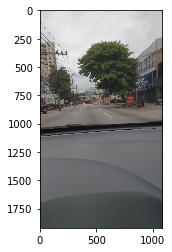

In [3]:
#reading in an image
image = mpimg.imread('test_images/geremarioMoment.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)# my modification
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [5]:
def average_lines(lines, img):
    '''
    img should be a regioned canny output
    '''
    if lines is None: return lines
    
    positive_slopes = []
    positive_xs = []
    positive_ys = []
    negative_slopes = []
    negative_xs = []
    negative_ys = []
    
    min_slope = .3
    max_slope = 1000
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            
            if abs(slope) < min_slope or abs(slope) > max_slope: continue  # Filter our slopes
                
            # We only need one point sample and the slope to determine the line equation
            positive_slopes.append(slope) if slope > 0 else negative_slopes.append(slope)
            positive_xs.append(x1) if slope > 0 else negative_xs.append(x1)
            positive_ys.append(y1) if slope > 0 else negative_ys.append(y1)
    
    # We need to calculate our region_top_y from the canny image so we know where to extend our lines to
    ysize, xsize = img.shape[0], img.shape[1]
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    white = img == 255
    YY[~white] = ysize*2  # Large number because we will take the min
    
    region_top_y = np.amin(YY)
    
    new_lines = []
    if len(positive_slopes) > 0:
        m = np.mean(positive_slopes)
        avg_x = np.mean(positive_xs)
        avg_y = np.mean(positive_ys)
        
        b = avg_y - m*avg_x
        
        # We have m and b, so with a y we can get x = (y-b)/m
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        
        new_lines.append([(x1, region_top_y, x2, ysize)])
    
    if len(negative_slopes) > 0:
        m = np.mean(negative_slopes)
        avg_x = np.mean(negative_xs)
        avg_y = np.mean(negative_ys)
        
        b = avg_y - m*avg_x
        
        # We have m and b, so with a y we can get x = (y-b)/m
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        
        new_lines.append([(x1, region_top_y, x2, ysize)])
            
    return np.array(new_lines)

def avg_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    avg_lines = average_lines(lines, img)
    #draw_lines(line_img, lines)
    draw_lines(line_img, avg_lines)
    return line_img

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'geremarioMoment.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'lopoSaraivaMoment.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

In [8]:
# To apply Canny Edged it is necessary to use the image on grayscale:
imageGray = grayscale(image)

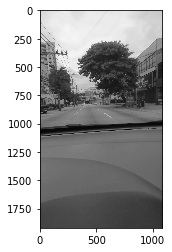

In [9]:
plt.imshow(imageGray, cmap='gray')

In [10]:
# Using Gaussian blur to "smooth" the image:
kernel_size = 5
blur_gray = gaussian_blur(imageGray, kernel_size)

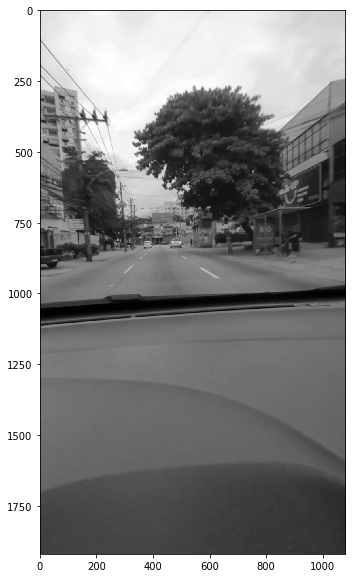

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(blur_gray, cmap='gray')

In [48]:
# Defining the Canny function thresholds:
low_threshold = 50
high_threshold = 120
edges = canny(blur_gray, low_threshold, high_threshold)

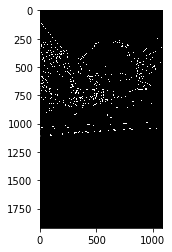

In [25]:
# Display the image:
plt.imshow(edges, cmap='Greys_r')

In [104]:
print(imshape[1],imshape[0]),
print(.03*imshape[1],imshape[0]),
print((.18*imshape[1],0.52*imshape[0]),
                       (0.32*imshape[1], 0.44*imshape[0]),
                       (0.46*imshape[1], 0.44*imshape[0]), 
                       (.75*imshape[1],0.50*imshape[0]))

1080 1920
32.4 1920
(194.4, 998.4000000000001) (345.6, 844.8) (496.8, 844.8) (810.0, 960.0)


In [61]:
500/1080

0.46296296296296297

In [179]:
#Defining the area (mask) that is used to apply the functions:
imshape = image.shape
vertices = np.array([[(.12*imshape[1],0.52*imshape[0]),
                       (0.35*imshape[1], 0.45*imshape[0]),
                       (0.43*imshape[1], 0.45*imshape[0]), 
                       (.85*imshape[1],0.50*imshape[0])]], dtype=np.int32)

# vertices = np.array([[(0+30,imshape[0]),
#                       (imshape[1]/2-20,imshape[0]/2+20),
#                       (imshape[1]/2+20, imshape[0]/2+20), 
#                       (imshape[1]-30,imshape[0])]], dtype=np.int32)

#vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)

In [180]:
# Applying the mask to the image:
maskedEdges = region_of_interest(edges, vertices)

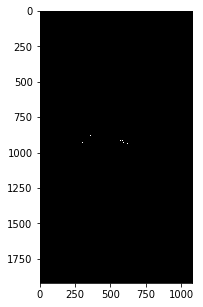

In [181]:
plt.figure(figsize=(10,5))
plt.imshow(maskedEdges, cmap='Greys_r')

In [182]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 15  #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

In [183]:
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
#`img` should be the output of a Canny transform.
#lines = avg_hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)
lines = hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)

572 908 634 945
293 926 325 901
562 910 616 945
303 927 330 902
295 926 313 911
617 945 633 946
571 908 612 933
302 927 328 903
305 926 330 903
599 933 619 946
305 916 323 902


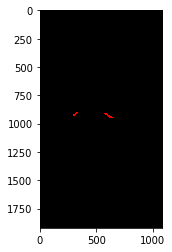

In [184]:
plt.imshow(lines)

In [185]:
final = weighted_img(lines, image, α=0.8, β=1., γ=0.)

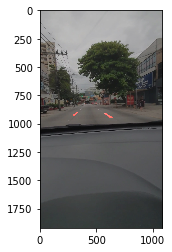

In [186]:
plt.imshow(final)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [188]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [193]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    imageGray = grayscale(image)

    kernel_size = 5
    blur_gray = gaussian_blur(imageGray, kernel_size)

    # Defining the Canny function thresholds:
    low_threshold = 50
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices = np.array([[(.12*imshape[1],0.52*imshape[0]),
                       (0.35*imshape[1], 0.44*imshape[0]),
                       (0.43*imshape[1], 0.44*imshape[0]), 
                       (.85*imshape[1],0.50*imshape[0])]], dtype=np.int32)

    maskedEdges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15  #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    #`img` should be the output of a Canny transform.
    #lines = avg_hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)
    lines = hough_lines(maskedEdges, rho, theta, threshold, min_line_len, max_line_gap)
    
    final = weighted_img(lines, image, α=0.8, β=1., γ=0.)
      
    return final

In [194]:
# def process_image(image):
#     # NOTE: The output you return should be a color image (3 channel) for processing video below
#     # TODO: put your pipeline here,
#     # you should return the final output (image where lines are drawn on lanes)

#     return result

Let's try the one with the solid white lane on the right first ...

In [195]:
white_output = 'test_videos_output/geremario.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/geremario.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

300 933 320 913
564 912 624 948
601 927 637 947
571 911 610 931
290 941 322 910
280 940 313 912
292 931 315 911
564 913 618 946
452 845 469 845
499 872 516 882
281 940 303 922
590 921 623 938
[MoviePy] >>>> Building video test_videos_output/geremario.mp4
[MoviePy] Writing video test_videos_output/geremario.mp4



  0%|          | 0/492 [00:00<?, ?it/s]

300 933 320 913
564 912 624 948
601 927 637 947
571 911 610 931
290 941 322 910
280 940 313 912
292 931 315 911
564 913 618 946
452 845 469 845
499 872 516 882
281 940 303 922
590 921 623 938
300 933 320 913
564 912 624 948
601 927 637 947
571 911 610 931
290 941 322 910
280 940 313 912
292 931 315 911
564 913 618 946
452 845 469 845
499 872 516 882
281 940 303 922
590 921 623 938



  0%|          | 2/492 [00:00<00:44, 11.09it/s]

502 873 520 884
571 916 600 933
582 916 651 955
273 948 312 914
284 947 317 916
596 932 622 947
348 885 373 859
586 917 613 932
285 947 311 922
633 955 649 957
273 947 308 916
620 937 644 950
612 942 637 956
571 917 611 940
350 885 370 864
633 945 667 964
579 921 652 966
589 920 632 943
277 954 315 919
265 954 306 919
506 875 523 885
278 953 298 933
463 850 479 860
501 876 516 885
292 941 315 917
348 886 374 859
458 851 475 862
614 934 646 951
502 874 522 885
283 938 305 919
501 877 517 885
596 932 611 931
635 955 653 966
585 924 624 948



  1%|          | 4/492 [00:00<00:44, 10.95it/s]

268 964 311 924
598 926 679 972
629 954 658 972
587 926 650 966
506 877 525 888
257 962 302 924
256 963 280 943
587 928 651 967
503 879 522 889
279 953 304 930
605 929 639 948



  1%|          | 6/492 [00:00<00:42, 11.37it/s]

597 932 661 972
654 957 679 971
245 972 297 927
607 930 648 952
260 972 307 926
454 844 484 865
504 879 521 889
259 972 282 949
510 878 528 888
460 852 483 865
631 944 647 952
245 973 275 947
264 955 292 931
634 956 658 971
658 959 678 970
595 931 612 942
274 959 306 926
458 850 485 865
249 982 303 930
233 983 294 930
616 936 680 971
507 881 525 891
605 937 661 972
253 978 283 948
235 982 276 946
514 880 534 890
618 936 663 961
454 845 469 845
265 954 289 933
519 883 535 892
611 940 626 949
274 959 302 930



  2%|▏         | 8/492 [00:00<00:41, 11.58it/s]

224 993 286 937
248 985 290 943
617 945 662 972
515 881 539 894
510 883 531 894
629 943 676 968
518 882 538 892
227 989 280 942
336 893 351 881
254 978 275 957
617 944 632 953
338 894 353 884
665 963 681 971



  2%|▏         | 10/492 [00:00<00:42, 11.46it/s]

238 993 290 941
525 885 543 895
630 953 662 972
227 988 278 943
513 882 535 896
646 951 666 962
251 981 289 943
643 950 681 971
221 994 241 977
518 882 543 896
335 894 350 882
338 896 353 883
255 964 280 942
513 883 532 895
334 893 349 882
631 952 658 969
222 994 239 979
643 959 659 969
243 987 283 949
462 851 491 868
223 992 276 947
643 960 662 972
654 958 680 971
525 885 547 897
516 883 540 899
222 993 274 947
517 886 537 898
238 993 272 960
660 959 681 971
518 883 547 898
642 960 660 971
518 886 541 899


238 993 258 973
524 886 552 901
229 986 263 956
222 994 266 954
520 888 544 902
251 981 279 953
523 886 540 895
259 972 275 956
663 968 679 971
525 890 545 902
248 971 266 955
523 890 543 902



  2%|▏         | 12/492 [00:01<00:41, 11.51it/s]

239 993 271 962
234 982 261 960
238 993 270 961
525 890 552 905
527 888 558 904
327 903 344 887
222 994 239 979
332 903 348 887
524 890 540 900
533 890 559 903
331 903 346 887
225 992 255 964
240 993 263 970
532 890 566 907
224 993 252 969
527 891 549 905
324 904 342 889
235 982 251 969
527 892 553 907
546 898 564 907



  3%|▎         | 14/492 [00:01<00:41, 11.47it/s]

531 894 564 912
224 993 239 979
320 907 335 893
535 892 550 900
550 899 571 912
326 908 343 892
321 908 338 891
535 897 562 912
539 893 556 903



  3%|▎         | 16/492 [00:01<00:40, 11.84it/s]

541 895 578 915
536 897 556 910
326 910 341 894
322 906 338 893
454 847 473 857
540 899 565 915
318 910 339 893
455 848 471 857
324 911 341 896
561 905 580 916
540 899 576 921
320 915 339 897
546 898 581 917
313 914 334 896
565 907 587 920
324 911 339 895
542 900 562 912
314 915 331 899
561 905 576 914


554 902 595 925
544 902 586 927
359 877 378 858
461 844 476 856
308 920 330 899
357 875 373 861
320 916 338 897
356 875 375 858
544 903 579 924
552 901 571 912
308 917 332 898
361 876 378 859



  4%|▎         | 18/492 [00:01<00:41, 11.37it/s]

554 908 592 932
493 868 509 877
555 904 606 931
304 923 328 901
314 922 335 902
550 907 589 931
357 878 378 858
305 924 329 901
312 923 334 902
455 847 471 857
556 904 578 915
577 922 595 933
304 922 321 907
566 909 617 938
580 924 606 940
555 909 584 928
300 927 325 904
309 928 332 905
457 847 475 859
300 928 326 904
308 928 333 903
355 878 373 860
358 880 378 859
462 847 480 858
555 908 594 934
356 880 378 861



  4%|▍         | 20/492 [00:01<00:40, 11.69it/s]

303 933 331 906
458 848 478 860
295 933 313 915
576 915 631 946
561 912 610 945
560 913 591 933
457 844 481 859
496 872 512 881
295 934 321 908
351 882 375 859
572 913 613 937
462 848 481 860
566 916 593 934



  4%|▍         | 22/492 [00:01<00:39, 11.84it/s]

568 917 623 953
577 916 643 954
288 939 319 909
600 937 626 954
300 937 326 909
498 874 514 883
350 883 375 859
502 872 518 881
356 882 377 860
458 848 480 861
297 938 327 909
287 939 303 923
459 849 477 860
462 847 478 857
576 916 595 927
293 943 324 912
576 922 638 962
584 920 652 960
282 942 316 913
503 873 521 884
594 925 658 963
285 941 318 912
505 873 521 883
298 937 323 912
349 884 373 860
500 874 515 884
360 877 377 860
460 844 482 861
605 940 643 964
500 873 516 884


582 926 653 972
507 874 525 884
593 925 636 949
352 885 376 861
637 951 663 965
296 940 319 915
586 928 657 973
274 949 294 931
273 951 313 915
501 876 519 886
457 846 483 861
296 931 314 915
654 961 673 972
360 874 375 860
461 849 485 860
359 874 374 860
503 876 521 886
591 925 608 934
632 948 648 956
361 874 376 860



  5%|▍         | 24/492 [00:02<00:41, 11.22it/s]

265 958 309 919
600 930 656 961
593 933 655 973
463 847 485 862
290 946 315 919
356 877 373 860
503 877 527 888
287 937 304 923
652 960 674 972
507 875 530 886
350 887 374 860
281 955 296 939
460 848 483 862
599 936 656 973
359 876 375 861
647 957 663 965
513 877 532 889
600 936 639 963
508 879 528 890
269 965 311 924
257 964 304 923
613 936 673 972
626 953 650 970
516 878 533 888
273 949 298 927
271 964 312 924
612 936 637 951
637 960 653 972
601 938 619 950
256 964 291 934
615 946 654 972
652 960 667 969
512 877 530 887



  5%|▌         | 26/492 [00:02<00:40, 11.50it/s]

610 943 655 973
247 973 300 927
623 942 674 972
266 969 307 928
513 877 536 890
462 848 487 863
510 878 530 891
261 973 308 926
265 956 297 928
621 949 656 973
260 961 284 940



  6%|▌         | 28/492 [00:02<00:40, 11.46it/s]

249 984 303 932
235 983 287 936
635 949 674 972
625 952 655 973
512 879 536 894
517 879 541 892
512 881 527 890
235 984 250 971
254 980 273 961
464 849 491 863
242 977 279 944
525 884 541 894
527 884 542 892
514 881 533 893
649 958 670 971
222 994 284 938
518 880 544 894
635 960 656 973
240 993 296 937
337 893 352 879
515 882 539 896
646 957 674 972
514 882 530 892
249 970 288 936
225 992 240 979
636 958 651 958
266 966 296 935
648 957 668 968
523 882 546 894
236 982 251 969
635 959 656 972


255 976 291 942
521 882 549 897
230 987 281 942
521 885 544 899
238 979 280 942
523 882 551 897
262 971 288 945
240 992 255 978
334 893 350 881
519 884 541 898
468 848 485 859
471 852 492 865



  6%|▌         | 30/492 [00:02<00:40, 11.43it/s]

526 883 556 900
241 990 285 947
221 994 274 947
523 886 548 902
254 976 281 950
332 895 349 882
465 849 494 866
472 849 490 865
230 985 254 964
238 977 258 960
527 889 542 899
239 993 269 963
246 984 262 968
334 899 349 884
222 994 265 955
530 885 561 903
239 993 277 953
525 887 553 905
227 988 263 956
473 853 497 867
529 885 561 905



  7%|▋         | 32/492 [00:02<00:40, 11.41it/s]

233 982 253 964
331 902 346 887
238 993 268 964
325 900 344 885
528 888 555 907
535 888 567 907
536 888 567 906
363 871 381 856
543 898 560 909
541 892 567 908
239 977 256 963
246 984 262 968
361 871 379 855



  7%|▋         | 34/492 [00:02<00:39, 11.55it/s]

239 993 259 973
457 845 472 854
532 891 563 912
221 994 247 972
329 905 345 888
360 873 381 857
540 891 573 911
320 904 344 887
241 990 259 972
533 891 562 911
322 904 340 888
458 845 474 854
541 892 571 910
243 974 258 970
544 893 569 907
326 907 342 891
537 895 571 916
324 901 339 889
358 873 375 856
320 906 340 889
362 873 379 857
490 862 506 869
324 908 342 889
543 893 580 914
231 984 248 980
536 893 574 917
318 907 338 889


547 895 571 908
540 896 578 921
312 910 334 892
359 875 374 861
321 911 337 895
550 896 591 920
361 870 376 856
553 899 588 921
322 903 338 891
492 863 507 870
542 898 569 916



  7%|▋         | 36/492 [00:03<00:40, 11.19it/s]

545 900 579 922
550 898 599 925
310 913 335 893
311 912 333 894
363 873 379 858
318 914 338 893
554 898 576 911
357 875 371 859
358 875 376 856
561 909 586 926
578 914 598 925
315 915 331 901
549 902 566 913
578 913 608 930
553 904 594 931
354 875 374 858
354 877 377 859
306 919 321 904
559 901 590 919
312 919 335 898
495 865 512 872
356 877 375 861
562 903 577 912
498 865 513 874
551 903 576 920
357 877 378 859
566 912 595 931



  8%|▊         | 38/492 [00:03<00:39, 11.46it/s]

556 905 586 926
567 905 621 937
299 921 330 897
357 877 372 863
311 920 331 900
358 877 377 859
500 866 515 875
571 908 614 934
557 905 591 929
588 926 606 938
353 878 375 857
352 878 373 858
299 923 318 905
363 870 378 859



  8%|▊         | 40/492 [00:03<00:39, 11.44it/s]

571 908 631 944
295 926 324 901
503 867 518 877
303 927 330 902
562 910 597 933
566 912 616 945
355 875 377 859
572 908 588 917
351 879 373 858
500 867 517 874
307 924 327 905
618 935 633 944
295 925 313 911
562 909 602 935
574 916 631 954
579 912 646 952
304 917 319 904
305 926 326 905
288 932 303 919
348 879 367 865
297 932 327 903
580 912 647 952
505 868 522 877
569 914 601 935
352 881 377 859
358 872 373 858
356 874 374 858
287 931 310 913
356 879 371 865
351 881 373 862



  9%|▊         | 42/492 [00:03<00:41, 10.89it/s]

347 882 376 858
585 916 657 958
281 937 316 907
576 918 648 964
352 882 373 862
507 869 526 879
577 919 613 943
348 882 370 860
350 879 366 863
586 916 613 931
356 879 371 865
624 939 663 962
302 928 323 906
510 870 526 878
504 870 520 880
349 882 369 865
281 938 302 920
612 932 678 971
584 923 660 972
275 942 312 910
294 936 321 909
595 921 631 942
584 924 600 934
509 870 528 880
284 944 320 909
358 878 370 860
275 943 294 927
345 881 366 867
506 871 521 880
512 871 530 880
618 946 659 972
633 944 654 956
295 926 313 910
661 962 679 972
276 942 291 929
608 929 641 948
266 950 310 913
294 936 315 915
592 929 659 972
509 874 524 883
277 951 316 913
602 926 679 972
344 885 369 861
471 848 489 860
510 874 527 884
347 885 375 861
512 872 532 883
352 883 367 867
606 927 622 936
348 885 371 861
594 929 610 939
516 873 533 882
292 927 308 914
627 940 657 958
349 885 370 861
517 874 533 884
279 950 298 931
607

 928 633 943



  9%|▉         | 44/492 [00:04<01:23,  5.34it/s]

511 875 530 886
612 932 679 972
267 960 311 919
513 873 536 885
256 960 304 918
601 933 658 972
272 957 307 923
341 887 368 863
601 935 657 972
511 874 532 886
514 873 529 880
346 887 374 862
617 934 652 955
608 933 623 937



  9%|▉         | 45/492 [00:04<01:34,  4.75it/s]

256 970 308 923
245 969 298 923
513 877 533 888
652 956 678 972
523 877 539 886
615 943 658 972
353 878 371 862
343 890 373 864
629 941 679 972
279 948 307 923
518 875 535 885
271 945 293 926
345 884 366 864
513 875 530 886
262 966 277 950
342 890 364 870
630 954 658 973
250 964 265 951



  9%|▉         | 46/492 [00:04<01:33,  4.79it/s]

246 981 303 926
234 979 292 928
634 945 677 970
626 951 657 972
248 980 302 928
519 876 545 890
351 880 378 855
366 870 384 853
643 961 658 972
337 892 365 865
338 893 365 870
369 864 384 852
642 949 658 958
278 939 294 927
659 960 677 971
265 951 281 937
332 894 347 881
220 990 284


 10%|▉         | 47/492 [00:05<01:28,  5.04it/s]

 933
243 983 296 933
518 879 542 893
364 871 383 853
342 891 382 851
526 879 549 892
237 989 257 970
640 961 658 972
523 878 549 893
650 958 666 963
466 846 498 863
221 990 237 977
656 958 680 971
359 871 383 852
246 966 273 944
339 893 362 868
275 951 293 935
640 960 659 972
661 960 678 971
238 988 288 940
245 967 278 939
333 898 349 886
469 845 499 865
525 880 556 895
225 986 279 939
467 847 486 858
521 881 549 897
330 896 345 883
237 990 258 970
218 994 236 978
348 883 365 866
521 882 547 897
222 989 240 973
274 954 290 937
536 886 555 895



 10%|▉         | 49/492 [00:05<01:34,  4.67it/s]

243 969 272 944
254 972 283 945
218 993 236 977
525 882 542 893
237 989 284 945
328 899 343 885
331 900 348 887
532 887 551 900
530 882 545 890
524 883 547 898
537 885 556 895
337 895 364 866
250 964 273 944
533 883 561 898
528 885 549 898
235 993 250 978



 10%|█         | 50/492 [00:05<01:28,  4.98it/s]

532 884 566 901
468 847 497 866
535 889 557 903
233 978 265 951
241 985 275 953
324 900 340 887
217 993 241 972
233 993 270 958
357 876 381 852
328 903 346 888
473 846 501 866
324 901 343 886
323 900 338 888
533 888 554 902
223 987 266 951
548 891 565 900
544 889 574 907
236 990 266 961
216 994 255 960
321 905 339 889
327 905 344 889
546 897 565 907
232 979 253 961
358 877 378 857
356 878 378 853
532 887 560 906
538 887 573 907
250 977 266 962



 11%|█         | 52/492 [00:06<01:30,  4.86it/s]

543 889 580 908
316 908 334 892
235 991 257 970
323 908 339 895
538 891 569 910
217 993 245 969
229 981 244 969
317 908 338 890
237 990 258 970
491 861 506 869
537 889 555 901
317 906 337 890
548 896 568 909
223 987 242 971
547 890 564 899
550 892 589 914
541 893 577 915
335 893 359 870
322 910 339 894
546 895 578 915
338 892 366 871
216 993 232 979
313 912 329 896
495 861 510 869
312 911 334 893
336 893 361 869
574 905 590 914



 11%|█         | 54/492 [00:06<01:27,  5.00it/s]

340 886 358 871
547 895 583 919
553 895 598 919
344 886 359 871
312 910 344 888
314 916 338 895
313 916 337 895
220 991 235 991
344 887 362 873
495 864 510 872
579 909 594 917
308 914 331 896
566 901 581 909
554 900 579 917
307 914 326 899
338 889 358 872
551 898 590 924
560 898 590 914
303 919 330 898
591 916 607 924
313 918 348 884
497 864 513 874
499 862 516 872
305 916 328 899
315 917 331 901
564 906 595 926
342 888 359 872
559 898 607 925



 11%|█▏        | 56/492 [00:07<01:30,  4.84it/s]

556 903 605 933
309 923 332 901
323 904 356 875
501 864 519 874
574 906 619 933
299 926 320 905
499 866 515 875
328 902 346 886
557 902 590 923
572 905 593 918
299 923 314 910
327 902 344 884
331 901 347 886
586 920 617 940
572 905 632 939
301 930 328 906
506 866 521 875
294 926 360 876
564 907 614 939
501 868 518 877
292 929 307 917
501 866 519 877
336 893 356 875
326 904 343 888
584 911 629 937
332 896 354 875
327 904 345 888
504 866 520 876
299 923 320 905



 12%|█▏        | 58/492 [00:07<01:38,  4.40it/s]

569 910 611 936
583 911 642 945
321 907 351 878
503 869 522 879
300 933 342 890
286 934 314 910
613 939 633 950
505 866 524 877
319 915 343 890
286 935 317 908
579 910 645 947
323 907 353 877
293 936 311 920
295 936 322 911
316 910 342 886
573 913 626 947
504 870 519 878



 12%|█▏        | 59/492 [00:07<01:31,  4.74it/s]

636 943 663 959
285 935 315 912
288 943 321 913
579 916 640 957
509 868 529 879
598 928 615 939
586 914 627 936
333 901 356 880
327 899 354 878
645 959 660 960
329 902 353 882
506 868 525 881
607 934 639 956
328 902 357 880
603 924 632 939
593 925 608 935
317 912 338 892
327 901 348 882
607 934 655 967
599 921 660 956
270 951 304 920
323 905 348 882
513 870 532 881
331 904 356 880
284 948 317 918
653 953 680 969
508 870 526 882
313 916 329 902
591 924 645 959
597 920 624 936
662 970 677 971
586 921 651 965
283 938 312 916
631 940 649 950



 12%|█▏        | 61/492 [00:08<01:36,  4.47it/s]

611 938 658 967
603 924 685 971
320 906 347 883
277 943 305 921
277 956 313 921
511 873 531 885
514 871 536 884
594 926 616 940
321 908 348 889
272 959 313 920
511 872 532 885
262 957 285 937
286 935 303 921
519 873 536 883
629 948 645 960
643 957 662 972



 13%|█▎        | 62/492 [00:08<01:30,  4.74it/s]

250 967 297 926
605 934 664 972
615 932 683 971
265 967 291 941
517 873 539 886
513 873 535 887
336 900 352 884
276 957 307 925
317 912 341 888
514 875 531 886
605 933 660 969
519 873 539 885
255 964 292 931
617 932 684 971
518 877 534 887
615 940 663 972
521 875 545 889
250 981 302 933
241 976 293 931
515 877 539 890
628 940 682 971
334 903 351 888
240 978 264 957
331 904 350 886
615 942 662 972
619 939 639 945
274 960 302 931
647 950 676 967
270 950 285 937
516 875 532 887
527 878 544 888



 13%|█▎        | 64/492 [00:08<01:28,  4.83it/s]

227 990 286 937
247 987 295 939
309 921 334 895
628 949 662 972
640 948 680 971
330 907 347 890
524 877 548 893
323 907 342 889
519 877 539 890
527 883 543 893
529 879 547 891
329 907 347 888
245 973 276 945
633 953 661 972
643 949 678 969
249 984 271 962
225 993 243 977
328 910 346 893
526 879 555 896
523 881 547 896
326 911 346 891
254 981 290 944
232 986 280 944
318 912 339 892
243 991 269 965
271 965 290 945
642 959 662 972
537 884 555 895
652 958 667 963
318 910 341 892
316 910 340 892
523 880 548 896
267 956 282 944
245 974 260 961



 13%|█▎        | 66/492 [00:09<01:29,  4.74it/s]

248 971 273 951
245 989 283 952
530 881 556 897
526 884 554 900
227 991 243 978
314 913 337 894
322 915 343 895
315 913 338 894
535 883 558 898
225 993 242 979
242 993 273 962
243 976 258 964
234 984 266 957
227 993 265 960
534 884 566 904
321 918 341 898
246 992 276 959
315 915 337 896
529 885 557 903
312 920 326 904
245 976 264 960
323 915 341 896
537 885 556 896
529 884 558 903
251 987 276 960



 14%|█▍        | 68/492 [00:09<01:30,  4.67it/s]

305 923 330 901
307 922 333 899
539 886 571 905
245 992 264 972
533 886 564 907
229 991 254 970
314 924 335 903
538 886 554 896
535 889 561 906
240 981 255 969
246 992 267 971
539 887 571 906
541 888 578 910
300 930 330 902
550 898 569 911
309 929 336 902
310 929 337 903
303 926 324 906
538 889 568 911
229 993 244 980



 14%|█▍        | 70/492 [00:10<01:29,  4.70it/s]

293 933 318 911
545 890 587 914
313 926 332 906
542 891 575 915
311 919 326 905
294 935 321 909
301 935 320 919
558 902 574 914
558 898 576 908
298 940 330 910
551 893 576 909
289 939 318 912
554 894 595 919
546 896 585 921
253 967 268 967
500 861 515 871
294 935 323 909
555 901 586 921
578 910 595 920
308 932 327 913
286 940 315 915



 15%|█▍        | 72/492 [00:10<01:29,  4.71it/s]

291 947 326 912
588 916 604 924
279 947 308 922
553 895 603 926
572 913 591 925
553 900 597 927
286 940 320 912
572 905 603 924
309 931 325 914
581 910 615 931
270 954 316 915
569 909 603 932
561 899 584 913
285 953 323 915
556 900 589 924
281 944 310 919
589 916 614 931
308 931 322 915
572 905 591 917



 15%|█▍        | 73/492 [00:10<01:30,  4.61it/s]

285 954 306 932
261 962 309 920
568 903 625 938
262 962 312 920
561 903 608 936
296 943 317 920
503 867 520 875
571 904 606 925
274 963 294 943
560 904 579 917
583 918 615 939
293 935 310 920
275 963 291 947
264 961 279 948



 15%|█▌        | 75/492 [00:11<01:49,  3.82it/s]

270 955 305 924
265 972 285 952
576 907 639 946
568 909 622 945
267 971 313 925
248 973 303 925
566 908 583 920
249 973 273 952
572 906 587 915
598 928 623 945
507 866 524 874
286 951 304 933
575 907 596 920
603 923 639 945



 15%|█▌        | 76/492 [00:11<01:42,  4.07it/s]

572 912 631 951
579 910 653 954
253 983 308 928
237 983 297 929
598 928 633 952
580 910 645 949
508 867 527 876
506 868 522 878
270 965 291 944
635 953 651 957
255 982 277 960
242 979 263 960
279 944 298 929



 16%|█▌        | 77/492 [00:11<01:34,  4.37it/s]

513 868 528 877
245 990 302 935
631 941 669 964
578 916 609 935
588 915 641 946
237 984 279 944
602 932 626 946
227 993 250 970
627 947 646 961
510 871 527 879
257 964 277 947
254 983 276 959
285 950 301 935
648 962 666 966
227 992 243 976
276 947 292 935
594 927 612 937
613 939 641 956
251 984 295 941
240 979 286 940
586 921 664 972
514 869 532 880
661 960 679 971
594 919 654 954
587 921 650 962
229 990 276 949
341 891 356 877
512 872 529 882
647 951 663 960
246 989 283 954
614 930 632 940



 16%|█▌        | 79/492 [00:12<01:34,  4.35it/s]

227 990 277 946
242 993 289 946
603 924 681 971
633 951 664 972
606 925 656 955
595 927 623 946
247 987 288 946
628 948 648 962
340 889 355 878
514 870 535 881
513 872 534 883
225 993 249 972
342 893 358 878
610 936 629 950
339 892 354 878
605 933 625 946
224 993 250 971
647 960 665 972
514 874 531 885
612 930 654 956
612 939 665 972
243 993 281 955
252 969 268 955
226 993 250 972
518 872 540 884
623 935 679 971
336 895 352 880
235 984 270 954
514 872 532 885
248 986 277 958
615 931 635 943
626 949 663 972
659 957 680 971
515 874 533 885
225 993 252 970



 16%|█▋        | 81/492 [00:12<01:40,  4.10it/s]

242 993 273 963
612 939 662 972
227 993 260 963
635 944 681 971
331 898 349 883
337 899 353 885
517 876 541 889
522 874 542 886
225 993 259 963
521 874 542 887
517 874 534 887
335 895 351 882
650 954 680 971



 17%|█▋        | 82/492 [00:12<01:32,  4.42it/s]

636 945 678 971
624 946 662 972
328 901 346 885
242 993 261 974
526 876 547 889
243 993 262 975
334 902 351 886
653 955 680 971
225 993 248 973
520 876 541 891
527 877 546 891
625 948 661 972
625 945 643 948
244 976 261 972
333 902 348 888
531 879 553 892
523 880 547 894
651 955 679 971
332 905 349 888
331 905 349 887
325 905 344 887
367 869 389 848
326 903 342 888
638 957 659 972
652 955 678 970
639 957 661 972
526 878 549 891



 17%|█▋        | 84/492 [00:13<01:30,  4.52it/s]

329 907 346 890
534 881 557 895
525 881 548 896
528 879 558 897
320 907 344 888
529 883 552 897
325 909 342 893
654 965 670 966
324 911 342 893
536 882 562 898
315 911 338 891
529 883 554 900
530 881 562 899
531 884 548 895
315 910 342 890



 17%|█▋        | 86/492 [00:13<01:30,  4.48it/s]

538 884 567 901
309 915 335 893
324 911 340 893
532 886 559 903
536 884 567 902
325 910 340 895
541 891 561 903
533 887 556 902
535 888 563 907
315 919 338 896
317 908 332 896
540 887 574 906
466 845 483 850
465 844 480 853
304 919 333 896
321 914 338 897
542 887 573 905
535 887 562 906
306 918 321 906



 18%|█▊        | 87/492 [00:14<01:36,  4.20it/s]

306 926 335 899
298 924 327 899
465 844 480 854
299 925 328 899
540 891 568 911
544 890 580 910
467 845 482 854
539 890 566 909



 18%|█▊        | 89/492 [00:14<01:45,  3.83it/s]

356 875 391 845
545 895 581 918
308 916 325 902
548 892 590 916
306 928 331 904
358 877 390 850
465 844 485 856
360 876 387 854
291 930 313 913
308 925 330 902
570 906 586 915
543 895 576 916
356 877 391 846
549 893 576 909
305 920 322 904



 18%|█▊        | 90/492 [00:14<01:37,  4.13it/s]

552 895 596 922
356 879 386 855
288 934 321 906
298 935 325 908
545 896 565 910
545 895 583 922
354 877 391 847
284 937 319 906
466 846 487 854
374 860 389 845
556 896 595 921
353 877 388 853
295 937 311 921
465 844 484 857
360 877 387 848
276 943 312 912
465 845 487 858
557 898 604 927
565 910 594 928
353 881 389 846
288 944 311 921
356 880 389 852
549 900 596 928
277 945 316 910
550 900 575 915
560 899 605 926
372 862 389 845
365 870 383 858
277 944 306 918



 19%|█▊        | 92/492 [00:15<01:47,  3.71it/s]

354 882 372 864
555 902 604 935
268 950 313 913
562 902 617 934
363 871 389 845
280 952 305 927
555 903 593 929
481 852 515 871
371 864 390 847
473 850 488 859
299 934 318 913
291 942 317 917
269 949 297 925
466 846 487 859
588 918 615 934


463 844 488 860
562 908 613 942
270 960 314 919
257 959 289 933
358 879 386 855
592 921 627 941
346 883 389 848
279 940 307 918
586 917 613 932
476 849 492 859
352 884 389 851
350 885 371 862
464 845 481 856
560 907 610 941
259 957 290 932



 19%|█▉        | 94/492 [00:16<01:42,  3.87it/s]

575 910 640 949
583 923 624 950
263 967 309 923
460 844 493 859
246 969 280 940
359 874 388 847
268 949 302 922
349 886 374 861
344 886 368 864
582 922 609 939
466 847 489 861
267 964 291 941
567 912 588 925
351 885 378 861
623 950 639 949
358 878 381 858
285 934 303 922
370 864 388 848
463 844 491 861
259 957 281 939



 19%|█▉        | 95/492 [00:16<01:45,  3.76it/s]

579 913 654 958
233 980 294 927
249 980 278 951
462 844 493 862
367 866 385 854
255 975 283 947
572 914 637 959
247 981 262 966
341 888 365 866
574 916 630 955
371 863 387 848
369 868 387 852
476 849 492 859
503 870 520 879
354 881 385 846
629 944 654 959
638 959 653 960
343 889 358 877
370 868 385 855
479 850 495 860
243 970 286 933



 20%|█▉        | 96/492 [00:16<01:37,  4.07it/s]

578 920 638 959
342 891 387 848
598 923 639 950
370 869 386 854
266 964 297 933
221 991 288 932
629 944 671 969
235 993 256 972
339 891 363 868
469 848 490 862
591 919 620 938
648 967 670 971
364 868 381 853
611 942 652 969
477 849 496 861
348 887 366 870
248 981 276 953
239 973 274 944
588 918 610 932
367 870 382 857
462 845 495 863
353 878 375 859
581 921 600 933
216 994 231 981
235 993 291 939
271 957 290 939
224 986 265 952
350 884 377 862
589 925 657 973
629 944 675 972
364 868 387 848
479 851 497 862
477 854 494 864
256 958 282 938
616 936 642 951
336 893 351 879
608 931 628 942
340 893 356 881
595 924 610 931
598 932 614 944
353 879 379 856
468 848 495 864
365 870 384 856
234 993 285 944
599 925 620 937



 20%|█▉        | 97/492 [00:16<01:43,  3.82it/s]

654 960 674 972
229 981 273 944
253 974 285 945
616 944 658 973
604 929 652 957
337 895 383 856
332 894 348 881
595 931 653 971
477 850 500 863
215 994 274 944
333 895 386 849
468 848 496 865
234 993 249 979
472 849 499 863
650 957 674 971
270 957 285 944
233 993 267 962
332 895 347 881



 20%|██        | 99/492 [00:17<01:54,  3.44it/s]

605 937 657 973
236 975 265 951
234 993 271 956
216 993 241 972
329 896 349 882
479 851 501 865
334 898 351 884
639 949 674 972
365 873 385 852
235 993 277 952
361 871 385 850
622 938 647 955
469 849 486 859
641 961 658 973
479 856 498 866
364 873 380 859
335 898 350 885
216 994 231 981
328 898 344 883
360 871 381 853



 20%|██        | 100/492 [00:17<01:43,  3.78it/s]

614 944 656 972
233 993 268 959
346 888 376 863
626 943 675 972
471 850 496 867
216 993 243 970
359 873 384 852
326 901 342 885
326 900 345 884
221 988 256 959
330 901 350 886
483 855 501 866
472 846 501 865
234 993 269 960
631 945 672 970
347 884 367 867
371 868 380 849
362 874 380 859
474 851 499 868
237 991

 258 970
225 985 246 967
359 875 383 851
626 952 654 972
479 852 503 867
362 875 383 856
470 850 501 869
324 902 340 887
637 951 674 972
234 993 256 971
329 904 347 889
479 851 504 867
216 994 246 968
331 903 346 887
628 953 657 973
629 950 644 953



 21%|██        | 102/492 [00:18<01:37,  3.99it/s]

470 850 504 871
324 908 345 890
317 906 343 888
478 851 506 868
358 874 383 853
357 877 372 867
653 960 674 972
360 877 378 861
362 872 379 854
216 994 232 980
486 857 504 868
641 963 657 973
318 907 333 893
368 865 383 851
652 960 673 972



 21%|██        | 103/492 [00:18<01:41,  3.82it/s]

472 846 508 870
321 911 342 892
313 910 337 891
359 873 383 852
483 859 504 872
365 874 380 859
359 878 382 856
471 851 486 860
486 857 503 868
326 907 344 892
355 878 371 863
472 851 505 872
218 993 234 993
361 871 382 852
314 910 336 891


309 914 336 893
355 881 380 859
353 881 382 852
476 848 493 862
468 850 507 874
353 880 381 850
487 858 505 868
319 905 334 893
366 867 381 851
495 863 510 871



 21%|██▏       | 105/492 [00:19<01:45,  3.67it/s]

488 863 508 875
322 909 337 896
303 918 332 896
470 851 487 861
479 852 513 874
349 881 367 867
310 920 326 907
352 883 378 861
360 872 380 857
322 910 337 898
482 859 511 875
488 859 512 874



 22%|██▏       | 106/492 [00:19<01:35,  4.06it/s]

347 883 380 854
476 848 508 876
299 923 328 899
306 924 334 900
348 884 380 855
471 852 513 877
349 885 375 864
473 846 514 876
350 885 369 870
299 922 320 904
354 878 371 863
481 849 502 872
349 882 367 866
345 885 366 868
484 861 512 879
480 854 516 877
301 930 328 905
291 929 313 910
543 894 577 913
291 931 318 906
356 883 378 861
470 852 490 864
535 895 570 916
487 859 512 875
353 885 379 858
542 894 577 914
302 930 329 903



 22%|██▏       | 108/492 [00:19<01:30,  4.25it/s]

348 888 375 863
295 935 327 904
473 853 515 880
474 848 519 880
342 887 378 857
547 896 567 909
287 933 317 907
555 908 575 920
550 897 579 916
297 934 320 912
357 876 377 853
344 889 358 874
285 934 310 912
489 864 506 875
349 888 365 873
494 868 514 880
480 853 497 865
490 861 523 881
277 941 307 915
469 850 516 882
344 887 377 855
365 874 379 858
288 941 324 910
552 899 590 923
277 942 306 916
562 913 581 925
362 872 377 853
544 901 570 917
304 926 324 909
472 850 509 872
572 910 593 924
475 849 523 882
279 943 296 935
473 854 503 874
477 855 492 865



 22%|██▏       | 110/492 [00:20<01:28,  4.33it/s]

550 905 588 930
496 869 520 884
293 938 315 916
269 949 310 913
355 878 377 856
339 893 359 873
469 853 495 867
343 892 371 868
500 868 526 884
483 856 498 865
268 948 290 929
344 892 373 866
495 864 512 874
475 849 490 851
487 863 510 877
346 891 364 875
502 869 525 882
268 949 303 918
260 955 294 927
554 908 597 937
340 895 375 863
271 957 313 918
473 854 497 869
284 934 305 917
476 850 528 885
494 868 525 887
335 895 365 869
341 895 371 868
341 889 372 861
274 955 315 917
496 865 513 876
482 855 510 874
499 872 520 885
340 891 361 873



 23%|██▎       | 111/492 [00:20<01:34,  4.05it/s]

262 965 308 922
333 895 359 874
475 849 511 875
559 912 611 945
335 898 351 887
248 965 302 920
499 872 528 889
352 886 372 856
567 910 597 927
355 883 376 859
603 932 623 943
498 865 528 886
469 850 493 851
353 878 373 865
477 856 493 866
484 861 526 889
365 873 374 855
589 924 611 936
259 955 301 921
287 941 310 921
333 896 355 877
578 923 599 939
286 932 303 920
516 877 531 887



 23%|██▎       | 113/492 [00:21<01:48,  3.51it/s]

497 864 516 878
248 975 305 926
476 849 495 864
582 927 622 953
330 899 374 861
237 973 293 926
472 854 528 890
342 894 358 878
565 916 597 936
249 975 281 947
238 974 253 961
360 877 375 861
475 855 496 868
518 878 535 890
331 897 374 858
564 915 584 927
347 890 370 868
239 973 296 924
488 858 509 874



 23%|██▎       | 114/492 [00:21<01:40,  3.77it/s]

240 984 299 931
572 919 629 960
581 918 650 961
332 902 353 884
325 902 346 885
491 866 510 878
239 971 284 933
515 878 538 891
496 864 512 876
326 903 373 861
475 847 500 868
358 879 374 861
469 851 491 852
354 882 370 868
235 976 287 931
623 945 646 959
274 952 294 935
372 865 372 850
470 852 498 870
523 888 538 893
468 850 485 851
325 903 373 860
225 984 244 967
608 944 625 957
469 855 484 856
280 946 299 930
367 871 371 855
499 872 514 876
336 898 361 877
571 920 609 945


580 926 629 959
507 873 543 895
226 982 285 934
268 957 293 935
322 906 357 875
329 905 365 872
637 954 665 971
231 993 253 973
623 945 644 957
473 853 535 896
606 934 625 945
480 855 506 871
627 959 651 973
245 979 265 962
585 923 608 934
321 905 337 892
218 989 233 977
580 923 596 927
350 880 369 867
343 886 372 862
272 954 293 936
469 852 494 852
468 855 485 857
496 864 511 875
355 882 371 858
620 954 636 964
333 902 354 883
474 857 489 859
236 973 284 934
512 881 540 897
250 961 275 940
498 867 538 891



 24%|██▎       | 116/492 [00:21<01:37,  3.87it/s]

218 989 274 942
234 990 270 957
512 877 547 898
636 954 666 972
585 930 644 970
474 857 506 876
319 910 371 861
340 895 370 868
267 958 286 942
613 939 635 952
505 872 547 897
596 928 612 937
475 854 492 862
322 910 347 890
469 853 494 853
508 879 543 900
475 857 502 869
616 952 648 973
318 910 333 895
258 967 287 942
333 902 362 876
347 883 371 865
225 984 240 972
461 844 497 852
624 946 641 956
491 866 508 873
507 878 527 890
251 974 285 941
339 890 357 876
589 932 609 945
635 953 650 962


594 936 643 971
253 971 279 948
224 986 267 948
332 904 370 866
328 901 366 866
484 858 518 881
468 852 547 903
225 985 249 962
610 946 647 973
520 882 551 901
240 986 260 964
525 884 544 896
466 855 492 853
489 865 508 873
340 895 359 879
463 845 489 850
314 911 329 899
487 859 514 878
261 963 279 947
321 911 337 898
602 941 646 973



 24%|██▍       | 118/492 [00:22<01:39,  3.75it/s]

474 848 518 882
474 855 509 879
217 990 261 954
309 916 356 876
603 944 643 970
240 983 271 956
345 892 369 868
506 872 521 884
528 892 546 905
482 853 500 854
315 917 333 903
604 945 646 973
357 875 369 860
536 893 557 904
503 876 521 887
310 917 342 889
466 856 484 859
353 883 369 866
469 857 487 860
477 860 492 863
246 978 267 960
322 906 337 893
233 976 250 962



 24%|██▍       | 119/492 [00:22<01:39,  3.75it/s]

479 857 527 893
304 920 341 890
616 952 645 973
486 860 562 909
314 919 347 890
349 881 368 865
311 921 367 870
345 885 368 867
477 857 518 887
462 846 505 854
213 994 239 971
231 993 246 978
471 855 486 854
234 991 260 963
526 892 555 910
216 993 246 965
305 921 353 879
628 960 646 973
525 887 544 897
507 873 524 886



 24%|██▍       | 120/492 [00:22<01:41,  3.68it/s]

301 926 368 864
473 856 559 914
307 925 361 876
300 926 319 908
231 993 248 976
489 862 531 891
548 900 567 914
216 993 239 972
530 889 546 900
483 855 501 855
470 859 492 863
495 865 538 895
309 924 326 909
479 852 495 852
234 991 250 975
467 858 487 861
344 893 367 868
214 994 232 977
505 878 554 911



 25%|██▍       | 121/492 [00:23<01:39,  3.72it/s]

307 920 377 855
302 930 330 906
470 855 566 919
518 882 575 918
482 855 509 855
294 931 315 911
351 881 371 855
334 901 356 881
483 860 520 882
480 852 497 852
213 994 229 983
364 854 391 852
473 856 567 919
332 898 366 866
475 861 494 865
538 894 573 916



 25%|██▍       | 122/492 [00:23<01:39,  3.72it/s]

492 864 554 905
323 913 363 873
415 851 431 852
516 886 571 923
327 902 365 867
563 911 582 922
302 932 326 908
464 856 495 855
486 862 502 876
308 919 324 903
303 923 318 908
469 849 485 849
464 858 479 859
360 866 375 852
494 866 512 883
562 909 577 919
481 854 495 871
531 891 556 905
486 866 515 884
350 880 365 864
524 891 542 903
489 867 508 875
331 904 353 884
358 879 370 856
543 904 564 918
499 869 535 894



 25%|██▌       | 123/492 [00:23<01:39,  3.72it/s]

293 939 339 898
474 857 563 917
281 941 364 869
489 863 587 926
340 895 358 879
484 856 500 856
524 892 558 914
540 903 580 929
465 859 487 862
294 938 362 874
475 862 493 866
351 886 361 863
481 852 497 852
300 925 346 885
497 867 526 886
576 918 591 928
520 889 539 901
470 860 490 864



 25%|██▌       | 124/492 [00:23<01:34,  3.88it/s]

518 882 599 933
272 948 362 870
474 857 585 934
299 935 360 876
483 856 512 856
482 853 501 853
484 862 524 885
274 948 348 883
475 851 492 851
496 871 588 935
466 860 482 861
275 949 295 938
532 892 549 903
311 922 341 895
576 920 599 934


491 865 534 892
475 858 593 940
277 953 356 879
306 919 346 884
264 955 310 914
473 858 506 878
468 857 495 857
496 856 512 856
589 927 608 940
347 883 370 853
542 899 573 917
482 853 501 853
301 932 335 899
582 924 600 934
264 953 290 933
466 849 481 848
349 879 364 857
324 902 340 889
511 878 538 895
554 912 594 940
287 935 309 915



 26%|██▌       | 126/492 [00:24<01:43,  3.54it/s]

321 914 340 894
543 900 587 926
483 863 605 948
255 963 359 872
329 907 358 875
493 867 519 882
266 962 305 929
484 857 516 857
466 861 481 862
590 928 620 949
525 886 547 902
483 854 505 854
471 851 491 851
466 849 481 848
287 944 307 926
351 885 360 855
535 901 558 916
340 890 358 869
519 883 541 897
267 953 302 923
485 867 500 874
598 933 620 947
555 915 591 939
274 957 288 942
597 944 612 949
503 876 527 893
345 891 358 874



 26%|██▌       | 127/492 [00:24<01:42,  3.56it/s]

476 859 615 956
267 953 345 885
497 869 632 956
316 917 354 881
262 968 286 946
485 854 505 854
247 969 265 953
476 852 494 852
470 851 489 850
322 912 344 892
295 936 315 920
467 850 484 849
483 867 498 870
574 918 632 955
467 862 488 865
333 894 357 875
245 972 288 933
481 858 501 858
266 964 294 937
343 892 356 867
304 922 322 904
280 951 304 930
506 879 523 890
479 862 495 873
607 951 624 957
524 885 550 904
570 925 586 934



 26%|██▌       | 128/492 [00:25<01:43,  3.52it/s]

498 870 647 967
532 898 614 954
247 980 265 964
249 968 343 886
297 936 351 884
453 851 473 851
592 929 647 966
467 862 495 858
480 862 549 909
232 981 295 927
267 964 324 909
477 865 496 869
487 858 520 858
616 957 635 967
485 854 505 854
474 852 492 851
621 961 640 967
347 887 352 870
469 862 492 871
501 871 535 892
479 853 497 852
334 895 356 873
479 859 496 870
595 942 612 953
525 893 574 926
491 871 506 878
340 890 355 869
234 983 249 978



 26%|██▌       | 129/492 [00:25<01:40,  3.62it/s]

220 992 355 875
584 933 641 973
238 990 347 888
579 923 641 961
452 851 480 849
524 890 553 913
522 885 572 917
496 869 519 888
488 858 509 858
458 852 486 850
592 939 614 955
478 853 494 853
326 902 355 874
474 864 502 876
643 964 658 973
576 921 603 936
548 908 577 930
474 852 493 851
471 860 502 872
508 880 526 886
339 896 361 855
486 854 505 854
564 919 598 944
491 867 530 889
224 988 286 936
313 921 327 906
614 945 639 960
591 930 621 948
637 960 655 970
506 874 522 890
270 959 287 945
225 987 242 972



 26%|██▋       | 130/492 [00:25<01:29,  4.06it/s]

548 902 602 937
216 994 353 875
481 853 496 853
486 865 641 973
233 993 347 886
510 880 531 895
468 863 494 872
593 930 658 972
383 855 398 854
520 883 542 896
480 863 519 881
282 938 336 891
459 852 475 851
234 993 252 976
333 901 352 878
510 876 573 918
340 887 351 869
605 938 639 961
243 984 336 897
506 878 549 908
486 854 505 854
291 930 311 912
588 927 612 943
483 865 508 875
489 867 640 973
506 874 658 973
217 994 352 877
265 965 281 950
234 993 339 895
491 859 521 859
441 851 463 853
469 851 508 855
509 880 536 899
618 946 658 972
471 864 501 876
243 983 263 965
293 929 332 895
482 854 497 853
341 891 348 872
487 867 505 874
218 994 285 934
576 920 595 933
512 877 564 911
573 927 637 971



 27%|██▋       | 132/492 [00:26<01:33,  3.85it/s]

233 993 335 897
508 875 658 972
486 866 569 922
216 994 350 877
596 943 640 973
539 902 560 916
493 859 509 859
459 852 490 851
488 855 503 855
561 918 589 936
483 854 498 853
614 955 641 973
338 894 350 878
491 868 524 890
470 851 489 850
571 925 590 937
483 869 500 872
383 856 398 855
318 912 338 893
239 973 277 940
608 951 636 969
237 990 258 968
296 926 315 907
594 932 636 957
531 889 565 911



 27%|██▋       | 133/492 [00:26<01:28,  4.04it/s]

517 880 622 950
237 988 343 889
512 882 637 972
216 994 289 929
479 849 494 859
598 933 658 973
291 929 316 906
218 992 260 954
494 874 515 879
233 993 251 975
328 897 347 874
481 869 499 872
495 859 524 859
489 872 504 874
490 855 509 855
468 866 490 868
592 938 636 971
337 895 349 877
281 948 310 920
471 852 487 851
492 873 509 876
502 878 521 887
483 854 500 854
529 887 560 908


233 992 336 895
215 994 334 890
513 883 606 950
517 880 620 949
622 949 638 961
610 951 626 965
479 854 501 854
493 859 524 859
471 867 498 871
484 855 509 855
229 981 246 981
501 877 527 892
573 917 615 944
338 893 347 878
562 917 616 957
475 867 491 869
259 968 273 953
305 917 327 897
517 881 567 912
244 968 287 930
528 893 567 921
231 978 249 963
287 934 304 917



 27%|██▋       | 135/492 [00:26<01:34,  3.77it/s]

527 885 658 973
212 994 308 911
230 992 337 892
515 883 582 930
310 911 345 877
584 933 641 973
230 993 322 907
486 867 519 880
329 892 345 878
576 927 595 940
473 866 494 873
471 851 493 855
484 870 499 875
494 858 520 858
538 900 589 935
566 910 607 938
252 960 288 929
224 983 261 951
630 953 656 971
620 946 635 957



 28%|██▊       | 136/492 [00:27<01:25,  4.18it/s]

525 884 599 932
212 994 290 926
519 886 630 966
230 993 329 900
303 917 346 876
600 934 642 961
549 906 590 936
477 865 512 878
472 868 499 876
523 888 641 973
496 859 524 859
213 994 234 976
503 879 521 882
486 855 505 854
323 905 338 891
224 984 267 947
622 949 658 973
501 878 517 880
540 894 597 932
231 993 254 969
314 908 332 890
475 868 490 869
265 959 285 942
474 867 495 875
524 884 638 958
228 993 332 896
541 900 615 955
488 869 519 881
216 988 323 898
443 851 462 853
497 859 524 859
227 993 273 950
533 894 557 913
481 869 520 886
215 989 270 944
334 893 343 877
537 891 600 932
466 868 487 869
520 882 536 898
610 951 625 961
636 958 653 968
325 902 335 879
309 919 334 892
511 877 526 891



 28%|██▊       | 138/492 [00:27<01:21,  4.32it/s]

316 902 343 878
227 993 330 897
527 891 597 940
528 886 562 908
221 984 319 901
599 943 629 964
552 900 597 931
228 992 290 934
471 852 498 856
479 867 518 881
614 941 642 962
472 869 509 881
321 898 338 886
498 859 524 859
611 952 637 971
213 991 254 957
608 937 626 951
258 952 321 899
574 925 616 954
572 913 590 926
465 869 484 871
331 896 341 878
447 851 463 854
380 855 395 857
631 953 651 968
332 895 342 878
549 907 571 922
517 886 532 889
585 922 600 933
540 892 626 948
209 993 314 904
534 894 622 958
226 993 320 905
641 960 659 972
479 870 502 874
511 878 528 892
225 993 252 967
503 879 524 884
304 911 344 878
483 854 500 853
500 859 524 859
476 869 494 871
330 895 342 878
615 954 640 971
628 951 652 966
503 875 519 887
535 895 564 917
498 877 516 880
245 961 284 929
512 883 531 887
327 897 340 878
577 917 635 954
312 905 337 880
314 902 328 887
490 874 512 878
284 938 311 913
232 987 248 970
598 941 626 961
640 959 660 972



 28%|██▊       | 140/492 [00:28<01:19,  4.44it/s]

208 994 317 899
277 945 297 925
534 889 662 972
560 912 638 970
300 924 318 905
489 874 507 880
238 981 267 952
482 867 521 883
260 961 275 945
503 859 524 859
321 903 342 875
641 959 661 972
543 900 562 915
508 882 524 885
207 994 228 975
614 951 641 972
379 859 394 858
218 985 242 963
318 906 325 889
611 938 626 947
532 888 612 938
549 904 572 922
505 880 523 884
309 915 328 896
255 952 276 934
299 916 322 893
206 994 278 932
419 874 476 871
543 900 611 948
253 967 326 897
532 888 635 952
490 868 512 867
280 932 320 896
224 993 250 968
463 869 495 867
345 879 379 877
602 943 632 963
482 854 502 857
628 948 647 962
469 868 493 875
573 922 645 973
314 900 337 880
485 869 522 883
441 851 469 855
379 860 395 860
524 866 542 866
249 970 267 952
488 873 535 895
293 930 330 892
609 935 625 947
274 937 293 919
540 892 592 924
208 992 254 952
328 880 344 880
311 905 324 888
225 993 249 969
607 935 640 956
548 904 576 924
294 919 320 895



 29%|██▉       | 142/492 [00:28<01:18,  4.46it/s]

547 902 645 973
236 980 251 966
546 895 618 940
204 994 305 909
276 945 327 894
396 873 411 873
425 875 490 871
641 957 665 972
588 922 627 946
240 978 264 954
485 870 552 866
325 882 356 880
477 869 524 889
506 859 524 859
327 880 360 876
480 869 521 884
224 993 250 967
353 880 371 875
395 876 412 876
490 856 505 857
364 879 379 875
211 989 249 957
310 903 331 879
317 896 338 878
613 938 628 947
497 878 536 896
543 901 562 912
611 947 646 973
281 941 299 923
648 961 663 972
479 869 496 878
252 953 276 933
222 994 311 911
640 955 667 972
496 870 513 881
205 994 315 898
540 892 612 935
550 904 647 972
486 871 555 867
461 871 483 870
408 876 494 873
379 861 395 861
304 917 334 882
344 882 371 879
483 854 508 858
312 885 350 881
622 943 654 963
545 902 566 914
599 928 618 939
258 949 304 909
377 856 394 859
221 994 248 968
487 874 530 892
506 877 556 900
513 884 545 901
312 909 325 894
472 873 494 874
279 942 297 923
633 963 648 973
302 912 316 896
538 892 559 902
256 963 273 945
492 870 


 29%|██▉       | 144/492 [00:28<01:16,  4.54it/s]

497 872 533 896
422 878 479 875
572 910 668 972
222 994 315 907
204 994 301 912
546 902 648 973
328 885 416 878
493 873 562 904
456 873 549 870
558 909 649 973
205 994 300 914
520 884 540 900
491 857 509 858
318 903 326 887
483 875 500 880
317 904 317 887
495 858 529 861
221 994 246 970
310 911 325 892
646 959 667 972
253 966 296 926
579 915 594 925
221 994 311 910
479 874 567 870
445 875 487 873
512 881 530 890
375 882 497 875
559 903 668 971
346 885 366 883
317 885 392 878
211 989 246 958
253 954 311 900
533 895 602 938
483 855 500 854
603 940 629 957
495 858 512 857
487 856 508 855
633 962 651 973
232 983 251 965
514 861 532 861
307 888 326 887
311 909 330 883
206 993 232 969
277 933 305 907
313 894 344 882
523 890 582 924
489 877 514 886
573 912 602 928
312 885 352 881
543 896 567 907
521 889 536 898
488 873 547 897
277 943 296 923
302 919 327 886
256 963 279 939
374 880 407 877
603 929 647 957



 30%|██▉       | 146/492 [00:29<01:15,  4.60it/s]

324 888 456 879
204 994 231 973
498 880 558 909
584 924 651 973
270 950 307 914
622 941 666 968
292 918 309 902
532 890 560 905
493 879 553 875
286 924 304 908
211 988 245 960
517 861 532 861
251 968 268 950
563 905 620 938
651 960 671 972
222 994 239 977
379 865 394 865
603 929 626 942
463 879 481 878
490 878 510 881
287 933 314 905
531 894 601 936
283 927 301 912
302 891 323 890
522 886 547 897
618 948 645 968
604 940 623 952
579 923 598 935
205 994 240 965
365 886 503 879
216 984 240 965
631 946 673 972
221 994 301 920
344 885 407 881
466 877 502 877
551 905 640 963
507 879 530 891
267 942 303 908
321 890 342 889
503 876 544 875
380 866 395 865
500 882 533 878
305 903 321 887
545 896 599 925
409 857 424 857
502 860 519 860
374 859 389 860
309 911 323 887
509 885 552 906
409 860 425 858
337 886 352 888
601 936 623 951
540 894 629 943
213 988 246 958
626 954 648 969
497 881 534 878
418 880 465 878
222 994 258 961
292 929 316 901
343 886 364 887
651 959 672 972
531 895 546 904



 30%|███       | 148/492 [00:29<01:16,  4.52it/s]

226 992 303 917
490 878 563 912
342 890 443 883
210 991 265 942
559 905 593 921
608 930 673 972
319 889 404 882
468 879 587 875
297 894 329 892
570 916 639 961
461 862 477 861
442 880 467 880
283 926 298 913
301 906 316 890
505 861 523 861
505 881 556 902
224 993 251 966
418 864 436 864
467 882 482 882
337 869 352 868
422 881 437 884
319 892 341 891
588 918 629 944
212 989 247 957
312 905 318 890
296 914 309 895
444 883 466 883
413 882 429 881
474 879 505 884
635 946 659 962
604 937 629 955
267 951 284 937
533 879 575 877
216 984 262 946
533 897 618 946
419 887 452 885
527 890 607 929
313 892 487 880
274 946 307 910
633 958 657 973
336 871 351 870
576 877 591 876
649 956 670 968
293 917 311 893
462 863 479 863
292 897 315 896
249 968 284 936
507 883 522 893
286 924 299 908
513 862 535 863
342 892 366 891
495 883 517 886
447 857 462 857
617 935 675 972
493 859 511 858
227 974 253 953
442 886 457 885
241 962 280 930
603 938 628 953
554 908 599 934
372 890 405 888
514 890 534 894
408 884 


 30%|███       | 150/492 [00:30<01:16,  4.48it/s]

435 888 491 885
553 908 605 938
208 992 284 925
321 893 366 890
313 897 395 890
376 869 394 868
249 970 289 931
603 927 676 972
448 884 564 880
528 863 544 864
263 955 302 915
510 885 610 941
565 879 580 879
520 888 572 911
642 962 657 973
268 938 291 918
654 957 677 972
629 953 656 972
303 912 318 897
393 887 431 885
489 858 514 863
510 884 543 899
598 935 616 945
285 924 300 905
636 959 653 969
212 989 261 946
277 942 299 919
635 945 659 961
463 887 493 885
304 910 319 894
317 897 374 892
592 922 625 940
429 890 471 889
506 889 539 886
345 893 409 889
526 883 548 883
282 903 369 894
511 885 605 929
271 937 292 913
578 884 598 884
249 970 278 942
511 864 541 864
214 988 232 970
522 894 579 923
333 873 349 872
466 865 482 864
225 993 253 964
568 882 602 880
380 894 412 891
607 930 674 969
597 935 624 950
448 858 463 858
282 937 312 896
422 868 438 866
288 917 307 897
450 861 466 859
291 913 305 897
477 885 532 884
211 989 249 957
599 883 618 883
452 886 476 886
575 922 591 930
627 


 31%|███       | 151/492 [00:30<01:20,  4.22it/s]

952 657 973
332 873 347 872
632 957 650 967
224 993 243 974
272 936 287 920
292 926 306 903
568 918 588 928
223 980 241 964
628 943 646 953



 31%|███       | 152/492 [00:30<01:15,  4.50it/s]

536 886 592 883
279 905 411 894
207 994 241 962
572 920 658 973
550 888 566 888
570 912 646 952
244 961 290 915
421 869 438 868
306 899 468 888
445 893 472 891
520 889 541 900
277 940 295 921
331 875 349 873
515 889 536 889
227 991 247 972
500 857 525 862
509 865 548 865
211 992 236 967
454 862 472 867
477 888 493 890
647 954 679 972
497 887 528 898
528 886 546 889
587 887 614 882
498 890 519 886
246 960 280 927
375 871 393 869
506 887 537 897
263 956 289 929
469 888 485 891
601 929 617 936
499 887 514 892
233 986 248 970
636 958 657 972
297 918 305 900
569 919 593 932
282 924 299 900
622 940 641 950
431 896 506 893
227 993 272 948
588 931 656 971
609 934 645 952
279 905 423 893
331 877 348 875
514 889 532 897
376 873 392 872
506 890 573 921
542 888 626 885
515 867 531 867
387 899 424 896
454 892 487 890
212 992 240 964
510 866 552 866
231 974 275 932
576 924 594 933
562 909 622 940
449 860 467 860
329 904 377 899
560 891 602 889
277 942 306 902
523 889 541 892
559 915 582 926
470 868 


 31%|███▏      | 154/492 [00:31<01:15,  4.50it/s]

338 902 387 899
481 893 633 888
233 988 282 935
552 906 580 920
525 892 545 904
244 962 271 935
579 918 678 972
439 895 459 895
375 874 393 873
557 914 656 971
280 922 295 906
263 941 280 924
576 893 645 890
369 866 384 865
374 903 392 901
324 907 364 903
421 896 438 896
533 866 551 866
518 868 534 868
440 898 461 898
212 992 234 969
330 878 346 876
287 912 307 908
513 867 528 864
553 912 568 921
268 912 283 907
534 904 550 905
450 861 466 861
527 894 560 894
463 894 481 897
297 911 332 903
614 947 658 973
414 863 435 867
573 922 613 945
360 904 377 899
262 958 284 931
501 893 534 903
538 867 555 867
376 902 401 901
660 961 679 972
496 893 518 896
241 978 260 960
316 910 364 907
228 993 282 933
458 897 482 897
268 912 431 898
511 895 560 917
210 994 234 969
424 873 442 872
519 869 538 869
572 923 600 939
586 923 673 969
530 866 547 866
598 892 616 891
536 867 559 868
611 944 649 969
483 900 507 898
465 868 492 871
236 969 278 924
494 861 513 860
375 906 395 904
513 895 531 894
551 894 


 32%|███▏      | 156/492 [00:31<01:14,  4.54it/s]

298 915 459 904
343 908 552 897
560 912 656 961
428 874 443 874
235 969 265 938
569 900 597 898
209 994 248 957
235 987 280 933
511 902 536 900
374 877 392 876
602 940 655 973
411 866 427 865
538 868 559 868
636 897 652 897
261 916 332 909
589 899 611 898
496 863 525 871
463 863 496 870
474 872 496 872
565 922 593 935
528 904 550 901
495 862 513 861
487 903 509 902
255 920 290 918
542 901 562 920
526 871 543 871
635 894 650 894
276 937 294 916
266 936 278 920
611 895 629 897
652 960 676 972
527 903 543 901
431 902 449 905
303 915 324 914
550 913 580 928
244 977 276 939
594 936 610 946
450 905 476 903
280 931 292 916
266 935 282 919
315 911 333 909
584 923 610 936
560 901 669 896
365 910 542 901
483 907 558 904
212 993 283 917
544 870 563 869
243 978 275 939
543 911 631 958
425 876 444 875
545 907 648 957
255 920 328 913
572 904 628 901
656 897 676 899
278 922 300 919
414 910 430 910
458 864 473 864
322 883 342 881
526 872 545 872
374 879 392 878
410 867 430 867
322 918 343 912
370 869 


 32%|███▏      | 158/492 [00:32<01:13,  4.56it/s]

551 908 607 906
329 917 446 909
313 922 442 913
539 905 658 963
620 905 645 905
529 905 644 966
211 994 278 922
427 878 446 877
229 993 266 949
321 885 341 883
505 906 520 906
617 952 652 971
491 911 518 909
481 868 497 872
610 902 630 902
291 921 309 919
368 871 385 870
243 929 265 923
524 872 548 874
649 904 679 903
652 900 685 900
458 868 485 875
478 875 497 875
269 929 291 924
649 960 673 972
447 909 465 909
212 994 254 949
562 905 578 904
469 912 497 910
466 908 487 908
262 953 274 935
579 904 595 907
495 907 510 910
231 990 261 954
548 916 571 926
463 912 478 911
555 912 572 920
625 946 642 956
412 915 495 912
517 914 543 913
272 926 319 923
547 909 631 950
309 927 469 916
567 925 654 973
530 909 580 909
216 990 271 927
614 907 648 905
238 984 282 926
532 875 554 875
459 867 475 866
374 883 391 882
412 869 432 869
342 921 382 917
657 905 672 904
320 887 341 885
636 954 671 971
514 910 529 910
589 908 605 907
544 915 617 910
589 912 642 909
516 864 556 874
270 932 297 928
230 993 


 33%|███▎      | 160/492 [00:32<01:10,  4.69it/s]

296 933 470 921
231 935 408 920
684 912 728 911
484 916 502 916
592 941 620 955
575 924 670 972
693 908 712 907
547 913 591 913
634 914 658 914
373 885 393 884
234 987 272 936
603 947 652 973
669 909 691 908
560 917 577 917
319 889 340 887
505 919 523 919
565 926 587 938
212 994 260 938
472 867 505 877
482 920 504 920
484 879 507 879
413 870 432 870
457 918 479 917
537 877 559 877
538 918 567 921
368 873 386 873
508 868 524 866
404 921 431 919
438 844 465 844
521 914 543 914
231 939 275 936
544 914 575 932
371 884 393 883
553 914 576 926
276 935 295 934
246 953 261 938
251 965 266 945
343 934 417 929
283 939 332 936
535 919 591 917
308 933 466 922
462 869 477 877
542 879 562 879
316 891 339 889
580 922 636 919
224 941 272 936
617 956 634 964
640 915 682 913
598 936 669 972
488 881 510 881
430 929 454 927
526 867 560 876
232 987 273 936
674 918 716 916
278 936 294 934
697 913 715 912
594 917 627 915
528 923 545 923
223 981 251 946
464 869 481 869
566 929 623 958
213 946 232 945
433 871 


 33%|███▎      | 162/492 [00:33<01:09,  4.77it/s]

443 934 543 929
476 927 574 923
702 923 758 921
220 947 391 932
625 952 666 972
261 948 294 945
556 923 647 973
490 883 506 883
567 930 607 927
316 894 337 892
221 983 249 945
415 873 435 873
546 881 570 881
398 932 418 930
547 929 564 928
641 926 657 925
334 942 374 938
650 919 704 918
437 886 455 884
705 917 724 917
303 945 327 942
319 880 337 879
403 937 419 935
583 932 633 955
228 993 259 951
213 993 229 971
632 920 649 920
205 953 237 951
322 880 338 880
211 948 259 944
582 922 598 922
369 876 387 876
464 872 479 870
449 845 469 845
378 889 395 888
280 947 298 945
420 935 442 935
469 928 484 927
571 932 603 950
322 943 339 941
606 950 644 971
225 951 247 952
314 939 350 936
235 951 284 947
358 940 590 928
444 940 498 938
308 950 352 947
593 934 612 933
551 883 567 883
578 937 646 973
313 896 333 895
611 928 638 926
710 929 785 926
189 961 240 958
428 885 447 888
643 926 659 925
642 933 684 930
577 929 662 972
529 869 548 874
434 888 457 886
466 872 484 871
441 845 469 845
227 993 


 33%|███▎      | 163/492 [00:33<01:10,  4.64it/s]

289 959 492 945
352 947 602 934
504 944 574 942
614 934 727 929
487 873 522 885
270 955 291 952
568 872 620 884
653 939 698 936
518 873 536 871
690 937 732 935
618 940 640 939
598 942 658 971
416 877 438 876
792 933 810 932
497 887 518 887
225 993 252 956
208 994 239 957
585 942 635 970
310 898 335 896
176 971 230 964
208 961 238 957
318 883 335 882
522 874 541 879
538 872 581 883
299 952 339 948
755 928 783 928
556 885 581 885
233 958 251 956
259 962 279 961
450 846 473 846
471 876 495 886
623 963 641 972
443 941 468 940
245 957 261 955
180 970 211 966
600 942 621 952



 34%|███▎      | 165/492 [00:33<01:22,  3.97it/s]

798 940 814 940
347 962 398 959
527 944 610 941
758 935 786 934
172 971 413 950
368 881 387 880
663 939 697 937
714 943 758 942
646 940 673 938
506 890 527 889
414 950 429 950
239 973 335 963
372 896 397 895
472 947 498 947
521 874 540 872
541 951 575 949
594 948 638 973
470 875 493 875
617 952 633 959
815 939 837 939
643 947 665 946
313 901 334 899
599 880 626 886
163 980 198 977
625 956 643 964
611 940 628 940
670 946 688 945
622 941 639 940
208 991 224 975
223 993 238 974
486 874 506 880
417 879 438 892
387 959 421 957
214 984 232 966
626 957 644 965
522 951 540 951
354 962 377 961



 34%|███▎      | 166/492 [00:34<01:18,  4.17it/s]

207 975 372 961
303 975 529 960
690 944 775 941
137 993 199 986
457 955 537 952
230 982 299 977
419 879 441 879
504 891 531 891
568 889 593 889
648 946 694 945
600 880 636 888
794 940 816 939
631 947 647 947
426 886 443 895
551 950 630 948
414 958 442 956
546 874 593 887
382 898 398 896
499 878 531 889
475 876 493 886
378 961 418 957
446 883 465 892
572 958 598 958
444 846 473 846
626 958 658 973
614 960 638 973
307 903 314 887
221 994 237 973
526 875 567 888
418 880 441 895
549 959 566 959
598 879 615 883
295 974 313 974



 34%|███▍      | 167/492 [00:34<01:11,  4.53it/s]

655 955 806 948
303 985 353 981
279 977 370 969
422 881 442 880
372 900 398 899
247 980 265 979
429 975 461 974
220 993 253 989
272 978 298 977
346 981 379 980
541 968 567 968
605 956 623 956
578 891 602 891
308 905 332 903
451 896 468 893
440 965 485 962
543 958 592 957
814 948 842 948
494 970 533 970
381 969 428 965
444 880 467 893
601 966 625 967
195 985 222 982
532 876 575 890
510 882 533 890
502 961 532 961
142 990 179 987
422 880 442 896
551 874 572 880
475 877 499 887
585 875 637 888
548 874 571 880
538 959 553 959
305 905 312 890
474 971 491 971
523 886 538 891
256 990 283 987
406 977 425 977
391 883 398 898
446 845 473 846
515 895 543 895
479 878 499 877
578 882 610 891
424 881 443 880
584 893 602 893
451 899 469 898
306 909 331 906
536 877 577 891
428 887 448 899
553 875 568 878
303 908 330 906
480 880 519 896
445 881 471 896



 34%|███▍      | 169/492 [00:34<01:13,  4.40it/s]

590 896 620 896
522 899 549 897
426 883 445 882
562 877 619 894
314 890 334 890
501 879 551 896
596 878 665 895
541 879 578 892
448 902 466 902
447 883 476 899
369 888 388 885
498 887 520 897
424 885 444 898
301 911 330 909
386 905 401 905
453 846 473 846
301 909 311 891
393 887 402 903
484 882 502 890
488 880 507 880
560 885 587 895
495 886 521 898



 35%|███▍      | 170/492 [00:34<01:08,  4.71it/s]

453 905 480 904
488 882 508 881
382 909 403 907
601 899 629 899
428 885 453 885
562 878 620 894
312 892 333 892
311 914 330 912
620 884 661 894
511 882 556 898
449 884 481 901
546 879 600 898
299 914 311 893
524 900 543 901
427 886 452 904
369 889 385 887
488 883 531 902
299 912 309 894
330 911 333 893
555 883 572 889
451 846 473 846
369 891 372 906
393 887 404 905
426 886 449 904
381 909 400 907
559 878 574 880
573 880 640 900
454 908 485 907
550 881 572 880
610 881 689 901
438 886 456 887
532 904 567 904
512 883 566 902
309 918 328 915
394 889 406 909
559 884 607 901
436 893 451 906
499 888 530 902
452 886 486 905
296 916 309 895
374 912 390 912
452 846 477 847
329 914 333 894
370 891 388 889
369 891 373 910
492 886 528 902
296 918 307 899
666 896 687 901
297 918 313 917
432 891 449 903



 35%|███▍      | 172/492 [00:35<01:08,  4.69it/s]

378 915 409 913
558 882 619 904
314 895 333 894
592 885 650 902
456 887 491 907
516 884 574 905
553 906 575 906
294 921 320 920
431 889 460 911
498 887 524 898
461 911 478 911
432 888 453 887
295 919 308 897
396 890 409 912
526 900 545 907
327 918 333 897
454 845 473 846
371 891 395 890
611 890 643 901
432 889 455 907
502 889 537 905
455 887 489 907
584 891 633 908
501 887 521 886
586 883 660 905
566 910 583 910
525 886 584 910
439 895 465 914
501 889 554 911
308 899 334 897
460 889 493 908
395 865 411 872
326 923 334 899
637 908 663 907
372 896 376 916
293 924 306 901
389 918 405 918
401 896 412 916
473 898 491 907
309 924 327 923
558 898 583 908
380 893 399 893
373 897 377 919
457 846 475 847
442 897 467 914
610 889 662 905
503 889 522 896
327 922 332 907
293 925 308 900
399 894 409 912



 35%|███▌      | 174/492 [00:35<01:08,  4.65it/s]

482 918 504 917
574 888 646 912
440 893 463 891
505 891 560 915
593 885 676 910
552 897 591 911
464 892 499 912
442 898 470 918
575 914 591 914
289 930 307 901
400 896 413 921
373 896 399 895
524 888 539 891
326 927 330 911
290 928 306 902
396 923 414 921
525 899 560 899
308 929 323 928
644 911 676 911
297 930 326 926
391 923 412 921
510 892 556 913
294 930 309 928
373 897 378 923
405 903 413 919
530 888 583 908
476 900 504 915
596 885 630 895
448 901 465 916
578 887 602 886
290 934 325 931
485 922 510 921
653 915 691 915
577 906 603 915
380 897 402 897
286 935 305 904
310 902 332 902
472 895 511 920
603 887 691 913
546 909 566 918
549 895 580 906
579 888 652 914
399 927 416 923
440 896 466 915
402 898 417 925
524 899 542 906
373 901 378 925
567 918 602 917
442 896 472 921
326 930 330 913
540 892 558 897
467 893 507 918
523 898 565 917
391 927 414 926
325 930 333 904



 36%|███▌      | 176/492 [00:36<01:10,  4.47it/s]

578 923 602 922
606 897 668 919
445 897 472 896
585 891 609 888
298 939 324 936
481 927 517 926
396 869 422 874
540 892 593 911
611 889 705 917
666 919 706 919
518 895 540 906
447 900 478 926
473 896 514 922
374 901 380 932
283 937 306 906
403 899 419 929
375 901 402 899
538 903 557 914
596 913 613 919
381 932 398 932
325 935 332 904
587 889 612 900
402 867 423 873
284 940 305 906
284 938 299 915
407 904 418 926
286 940 313 937
376 914 379 931
519 896 545 908
493 908 516 923
588 892 603 897
458 908 480 927
304 908 333 906
684 924 722 923
618 891 695 913
587 927 623 926
388 937 423 935
546 893 624 923
448 900 486 931
488 932 525 930
474 897 507 916
596 894 612 898
543 905 562 914
492 909 518 923
281 943 304 909
376 903 405 901
522 897 585 926
593 891 611 891
323 942 332 909
376 904 379 928
406 902 423 932
217 950 245 926
635 906 683 923
280 945 324 941
406 903 419 927
448 899 466 898
281 944 294 925
465 915 485 931



 36%|███▌      | 178/492 [00:36<01:10,  4.48it/s]

308 910 331 909
396 942 427 940
679 921 702 929
552 909 580 910
277 951 322 947
483 900 535 934
627 893 714 918
452 903 481 926
568 900 642 929
514 936 534 936
378 905 409 904
277 950 302 912
551 908 588 927
401 871 421 875
481 927 496 937
703 929 741 928
466 900 482 900
635 905 663 915
213 955 243 927
528 897 557 896
409 905 425 936
618 899 638 907
322 946 333 910
613 893 639 895
402 868 430 875
611 932 627 931
489 934 504 937
377 907 382 937
211 956 233 935
528 899 587 926
656 912 700 928
565 899 594 911
279 951 318 948
628 931 644 932
410 905 419 923
644 897 693 911
180 966 204 964
618 938 655 937
390 949 431 947
380 908 408 907
281 958 321 954
645 896 744 926
562 898 659 935
613 897 722 934
463 911 500 942
498 


 36%|███▋      | 179/492 [00:36<01:15,  4.15it/s]

910 547 940
536 900 612 937
273 958 300 916
412 907 431 942
227 944 248 924
302 914 320 912
216 954 233 937
460 907 499 941
322 953 333 912
625 895 648 897
405 869 425 877
739 934 762 932
526 942 545 942
380 910 382 925
502 943 525 943
536 901 551 899
287 938 301 915
403 872 418 875
493 906 518 921
538 902 566 916
382 929 387 948
699 913 739 925
211 959 225 944
301 916 330 911
593 927 613 937
403 869 427 874
546 900 563 899



 37%|███▋      | 180/492 [00:37<01:11,  4.39it/s]

653 898 783 938
544 903 571 901
636 944 674 943
702 927 743 941
604 912 678 942
196 972 250 923
596 929 628 944
270 966 301 918
462 909 514 951
303 917 333 915
623 900 652 909
497 907 559 947
650 909 697 924
415 910 437 952
382 912 412 909
382 913 389 956
744 941 767 940
318 962 334 918
567 914 630 944
270 964 300 919
615 917 673 941
511 950 552 949
549 906 567 915
301 963 321 961
418 955 435 954
470 906 495 906
662 900 767 932
177 974 199 970
405 870 434 876
627 898 652 898
572 902 603 912
271 966 291 965
498 908 519 922
473 919 509 948
522 924 558 947
195 972 220 951
653 952 669 952
468 910 500 909
668 901 811 944
792 946 811 947
469 912 524 958
410 871 437 877
323 956 335 921
190 980 249 925
554 906 648 952
636 903 691 921
419 913 444 960
629 921 694 948
267 975 300 922
502 909 562 949
410 874 439 880
700 925 737 937
301 921 333 918
393 965 409 965
266 974 280 951
386 928 391 961
587 905 626 921
268 975 320 970
522 958 557 957
531 927 570 954
634 901 667 901
157 984 172 984
467 912 


 37%|███▋      | 182/492 [00:37<01:09,  4.45it/s]

266 984 287 983
397 974 450 971
785 954 807 954
389 917 406 917
751 925 823 946
492 930 515 951
509 912 588 963
595 907 718 956
561 909 670 960
180 991 213 960
728 933 778 950
690 959 719 960
223 953 246 931
425 918 449 966
288 944 300 925
680 903 738 921
648 904 679 903
561 908 582 907
263 982 284 947
388 923 391 947
808 955 827 954
509 946 525 958
676 914 708 926
318 981 336 924
135 996 158 995
695 907 735 920
414 873 443 882
474 913 495 912
318 923 334 921
824 948 839 952
641 948 668 960
389 937 396 973
488 928 515 950
482 922 500 936
414 872 433 876
538 930 581 958
297 929 315 923
183 989 247 931
263 983 295 931
159 994 176 993
193 978 209 963
616 916 638 923
411 974 432 971
756 943 791 955
634 922 653 929
438 945 451 968
481 918 546 976
682 915 818 964
608 911 743 965
392 923 396 967
694 907 809 940
300 930 336 927
401 984 459 981
515 916 597 967
418 873 451 882
850 954 876 961
630 942 679 966
261 990 296 935
692 970 734 968
180 993 245 934
431 924 445 951
310 928 330 927
574 915 


 37%|███▋      | 184/492 [00:38<01:11,  4.30it/s]

180 994 241 939
320 989 338 933
712 910 884 962
677 912 828 964
525 920 558 942
617 914 686 941
421 874 455 883
452 963 460 978
566 945 609 975
262 991 275 970
657 953 690 969
299 934 338 931
648 925 725 957
492 926 552 978
419 877 450 885
727 957 753 968
274 973 286 953
433 925 451 958
395 927 432 925
585 916 616 914
585 918 656 951
194 983 236 944
397 953 403 985
678 910 711 910
288 952 298 935
549 934 564 945
440 935 448 951
451 960 463 981
800 955 826 964
583 918 671 959
394 928 397 944
225 939 241 940
751 921 860 954
524 920 544 931
267 984 276 969
183 992 218 962
528 921 611 975
679 937 696 944
597


 38%|███▊      | 185/492 [00:38<01:14,  4.10it/s]

 921 636 919
699 918 833 964
753 920 890 961
538 925 613 975
182 995 238 946
594 922 699 971
267 989 300 939
496 926 551 976
676 934 758 968
499 926 531 924
444 936 459 967
440 882 456 887
646 941 685 938
323 984 333 958
430 876 459 884
398 932 435 929
567 943 614 975
638 920 662 930
454 959 466 982
701 915 735 915
400 939 403 965
298 940 327 936
668 931 693 942
600 924 621 933
398 933 405 985
214 945 230 943
535 924 569 947
554 949 572 948
644 941 660 952
665 930 686 943
265 991 292 949
333 956 339 936
646 944 694 942
510 940 530 956
669 940 684 940
424 876 441 883
853 951 887 961
323 988 339 939
680 963 698 971
433 877 459 885
442 934 450 950



 38%|███▊      | 186/492 [00:38<01:09,  4.43it/s]

403 935 443 933
745 917 863 951
731 927 819 956
648 922 762 968
448 937 470 982
504 930 556 977
268 991 299 943
185 995 234 950
609 926 703 970
545 928 601 963
861 951 896 961
300 943 333 940
428 878 453 886
517 929 543 928
327 987 335 960
402 936 408 979
809 954 839 963
559 937 616 974
608 924 632 923
712 918 752 918
428 876 447 880
207 950 232 947
218 966 233 951
713 921 758 935
445 934 464 970
533 955 557 977
335 962 340 940
631 922 647 922
508 934 528 953
330 979 340 944
720 950 759 966
735 927 844 964
738 924 756 924
773 923 831 940
680 960 700 959
435 939 452 940
710 959 738 957
665 928 733 954
623 932 699 966
814 934 900 961
514 937 531 952
557 934 598 959
600 962 618 972
410 963 412 983
190 995 231 955
196 957 228 954
276 983 299 950
533 955 555 972
297 950 328 947
453 883 471 888
733 955 767 967
444 883 465 890
453 941 473 978
134 998 158 980
335 973 342 947
623 930 664 928
406 944 411 968
596 961 620 974
690 954 732 954
407 942 429 940
680 959 696 965
208 979 231 956
432 878 


 38%|███▊      | 188/492 [00:39<01:06,  4.54it/s]

802 946 848 963
526 944 541 957
640 936 688 934
712 963 759 963
209 962 226 961
829 937 891 955
182 965 208 963
192 995 227 964
158 981 180 966
753 967 771 967
275 991 297 957
683 958 712 967
527 941 573 940
460 947 478 980
323 954 342 953
437 879 455 887
442 879 475 889
601 960 625 974
658 946 673 952
640 938 656 944
779 938 813 951
731 968 752 967
689 935 758 962
871 950 894 956
334 987 343 956
413 948 417 982
779 928 794 928
144 991 168 975
534 952 560 975
758 929 778 929
458 945 478 981
567 939 589 950
438 881 472 892
279 984 289 969
194 993 227 962
681 957 698 964
547 963 563 976
441 879 463 886
145 991 184 964
569 939 594 954
442 953 467 953
783 938 857 963
173 974 222 970
597 953 628 974
555 947 580 946
446 881 483 892
679 940 700 939
416 956 432 954
142 997 166 978
667 948 685 956
751 957 776 967
537 951 558 969
717 944 748 957
584 946 623 972
315 962 345 961
700 964 716 970
886 953 908 958
468 954 483 980
197 995 221 972
461 889 482 894
856 944 876 949
679 954 694 960
799 935 


 39%|███▊      | 190/492 [00:39<01:06,  4.56it/s]

548 954 595 952
164 980 215 977
812 940 830 939
721 945 780 967
613 961 630 973
808 944 865 963
441 960 461 959
445 881 489 894
293 971 311 969
141 997 167 979
700 946 716 945
676 949 718 970
446 884 484 896
473 960 487 981
199 995 214 980
604 955 631 974
281 991 296 971
679 948 694 946
423 961 451 959
475 962 486 978
554 960 571 977
822 940 837 939
819 948 847 958
341 988 345 968
420 964 425 980
809 945 829 952
156 993 208 990
562 965 606 962
435 971 458 971
294 982 317 981
449 886 493 899
452 884 496 898
324 979 343 979
754 956 780 966
695 959 720 969
710 956 746 954
831 951 865 962
840 949 863 947
697 957 714 966
845 949 869 947
455 884 494 896



 39%|███▉      | 192/492 [00:39<01:02,  4.80it/s]

434 981 450 980
863 959 879 958
455 885 501 898
868 957 908 957
748 962 776 962
472 893 501 901
722 964 744 964
455 887 474 893
454 887 476 894
461 890 507 904
464 887 512 902
462 890 485 897



 39%|███▉      | 193/492 [00:40<01:04,  4.60it/s]

486 897 513 907
366 855 382 860
388 857 403 862
472 889 518 905
465 889 486 898
368 855 404 858
393 861 415 860
251 938 257 919
483 896 507 906



 40%|███▉      | 195/492 [00:40<01:15,  3.95it/s]

469 891 522 911
474 891 526 909
237 945 243 928
375 859 402 858
250 942 256 920
370 858 388 857
500 899 526 908
504 904 524 911



 40%|███▉      | 196/492 [00:40<01:10,  4.17it/s]

377 856 405 860
481 893 537 912
478 895 531 914
368 858 417 864
249 943 254 922
234 948 243 927
371 856 394 858



 40%|████      | 197/492 [00:41<01:04,  4.55it/s]

482 897 540 918
372 859 397 861
517 905 547 916
373 856 423 861
230 957 243 927
248 943 253 926
490 896 506 902
244 954 249 939
497 898 522 908
493 898 542 914
225 962 242 928
488 900 529 914
241 961 252 925
225 964 240 962
534 917 552 922
225 963 239 937
541 914 558 922
239 963 249 939
522 908 540 914



 40%|████      | 199/492 [00:41<01:05,  4.47it/s]

219 971 242 929
499 900 569 925
496 902 535 918
234 971 245 947
239 959 247 941
219 969 241 929
496 903 524 914



 41%|████      | 200/492 [00:41<01:00,  4.81it/s]

526 914 572 933
511 905 583 932
386 859 432 863
382 861 437 868
230 980 247 939
213 982 240 934
392 845 408 845
402 861 437 864
504 906 570 933
551 919 582 931
214 979 226 957
213 983 229 981
532 912 597 937
547 924 586 939
225 989 237 960
383 861 455 869
217 974 235 939
387 859 420 863
538 920 564 930
415 862 453 868
522 909 596 937
392 845 412 845
206 992 215 975
510 910 540 920
237 962 244 943
395 863 447 869



 41%|████      | 202/492 [00:42<01:01,  4.73it/s]

524 914 598 945
398 859 415 865
221 994 239 957
527 911 595 936
204 994 234 943
394 845 416 845
417 862 458 868
387 861 458 870
574 929 609 942
533 917 603 945
205 993 232 944
233 967 241 951
545 922 611 951
571 928 622 947
203 994 228 950
221 993 239 950
411 862 461 868
533 914 582 931
404 864 461 871
400 845 418 845
228 979 234 964
529 916 573 935
395 860 436 864
210 983 226 954
391 862 435 867
232 971 239 949
602 940 628 950
567 926 605 940



 41%|████▏     | 204/492 [00:42<01:00,  4.76it/s]

558 927 636 961
616 945 646 957
397 862 426 866
570 931 622 954
218 994 236 956
202 994 225 955
437 867 464 871
544 917 604 939
397 859 448 865
537 920 555 926
617 945 638 953
219 993 232 968
448 866 465 868
597 937 618 945
204 989 215 974
434 864 451 866
417 865 466 871
585 939 656 969
640 955 659 962
553 922 581 930
405 882 423 885
401 860 472 869
621 947 640 954
648 959 667 966
547 924 606 947
221 986 231 966
200 995 220 962
403 863 447 868
601 939 616 944
549 924 598 943
205 989 223 961
453 867 471 869
226 978 231 963
202 993 221 962
653 969 668 969



 42%|████▏     | 206/492 [00:42<01:00,  4.72it/s]

600 944 661 972
570 927 679 971
400 862 474 872
408 886 428 890
403 860 475 869
422 885 455 892
200 995 213 973
217 994 226 971
559 929 581 936
432 890 448 894
578 929 647 957
415 884 433 888
651 960 678 971
412 861 432 863
577 935 642 964
414 845 434 844
201 994 214 972
444 865 475 871
587 932 680 971
414 860 431 863
408 863 437 866
602 944 652 968
460 870 481 872
566 877 586 879
216 993 223 976
198 995 209 977
449 865 480 871
594 941 632 959
573 877 605 881
413 884 459 893
572 931 589 940
660 962 681 971



 42%|████▏     | 208/492 [00:43<01:00,  4.67it/s]

585 939 602 945
407 863 448 869
639 953 673 969
606 941 629 949
425 887 459 898
412 861 440 864
454 866 484 872
627 956 661 972
415 886 436 893
592 942 612 949
436 867 462 870
657 961 679 971
434 889 465 896
613 943 680 971
602 945 663 972
424 861 451 866
412 863 491 874
458 866 492 872
418 844 443 844
599 945 659 971



 43%|████▎     | 210/492 [00:43<01:00,  4.64it/s]

425 892 479 903
415 864 496 875
626 950 651 960
615 953 661 972
426 890 477 901
465 868 496 873
413 844 430 845
592 882 619 885
654 960 678 971
417 861 493 873
342 874 371 874
382 852 398 850
614 951 630 951
436 895 475 903
436 891 457 896
634 958 663 972
603 883 626 885
659 962 675 968
430 893 489 906
421 864 502 876
423 861 503 873
434 891 489 903
440 846 458 844
636 960 653 968
347 874 365 874
650 958 682 971



 43%|████▎     | 212/492 [00:44<01:00,  4.63it/s]

437 862 464 867
427 864 447 867
471 870 506 876
472 867 495 871
435 844 459 844
469 870 491 874
449 898 505 911
360 876 379 876
437 863 516 875
446 894 505 909
431 865 468 871
442 845 465 844
475 872 494 874
442 897 500 911
473 871 489 874
480 902 507 909



 43%|████▎     | 214/492 [00:44<01:00,  4.61it/s]

418 863 517 878
443 863 523 877
450 899 508 914
447 896 513 911
437 863 476 869
490 870 517 875
468 903 495 910
451 896 490 905
440 863 514 874
357 877 394 877
421 863 527 879
455 901 493 910
458 898 524 915
494 911 511 915
450 845 467 845
235 946 238 931
455 898 479 904
508 915 525 917



 44%|████▍     | 216/492 [00:45<00:59,  4.61it/s]

458 869 508 876
643 892 665 895
465 904 534 922
440 844 459 845
464 901 509 912
360 878 390 878
451 864 491 871
427 864 457 868
508 912 525 917
474 872 490 874
233 950 237 931
482 869 497 872
449 864 476 869
462 904 531 922
639 892 656 894
482 906 507 912
443 867 464 869
468 906 523 920
471 903 545 923
431 864 547 882
461 865 545 879
231 956 236 936
524 921 545 926
628 893 665 895
365 879 381 880
445 844 473 846
216 958 223 940
522 917 547 924
229 959 237 931



 44%|████▍     | 218/492 [00:45<01:00,  4.55it/s]

495 874 528 879
435 864 547 883
456 865 554 880
480 906 559 928
474 908 556 931
229 960 236 932
392 880 411 880
212 967 219 950
449 844 473 846
368 880 388 881
437 865 462 869
487 873 557 884
505 873 540 878
485 911 572 937
226 968 235 937
510 915 559 930
443 866 502 875
208 974 222 940
397 881 414 881
642 897 681 899
441 865 461 868
487 870 531 876
463 866 484 868
374 882 392 883
538 923 573 933
504 914 519 918



 45%|████▍     | 220/492 [00:46<00:59,  4.57it/s]

493 915 583 942
460 868 492 873
495 912 586 938
494 871 571 883
510 877 549 883
221 980 232 948
447 866 505 876
202 984 217 954
470 867 506 872
653 899 670 899
223 974 234 939
496 915 536 927
562 932 590 940
210 969 221 942
526 879 541 881
453 868 558 885
474 868 549 879
574 937 604 946
219 984 233 941
569 940 590 947
196 995 218 949
504 873 581 885
564 887 581 887
548 933 580 943
528 923 554 930
558 932 573 936
500 916 515 919
501 918 525 925
215 994 220 979
503 919 529 927
471 867 495 870
200 988 215 957
576 942 601 949
457 868 497 874



 45%|████▌     | 222/492 [00:46<01:01,  4.37it/s]

577 944 616 956
544 933 571 941
514 920 622 953
457 868 558 884
196 995 211 966
479 868 591 887
563 886 590 890
218 986 231 945
511 923 552 935
684 904 704 905
387 887 428 886
203 980 222 944
513 878 556 884
215 994 220 978
604 954 621 956



 45%|████▌     | 223/492 [00:46<00:59,  4.56it/s]

476 870 573 887
597 947 643 962
589 949 635 965
196 995 217 950
520 923 578 940
545 934 588 948
214 993 229 953
486 869 573 883
463 868 529 880
571 887 599 891
522 927 547 934
519 875 545 879
514 874 581 885
464 869 483 872
605 949 624 955
522 923 550 931
473 870 520 877
362 854 379 856
531 930 651 973
523 875 589 886
555 933 663 970
651 903 683 905
495 870 518 873
655 906 670 907
583 947 652 973
530 880 582 888
542 929 583 943
402 892 418 892
195 995 213 957
213 994 226 961
586 890 609 893
400 890 418 891
525 879 562 884
632 960 666 972
585 948 600 954
195 994 212 958
471 869 486 871



 46%|████▌     | 224/492 [00:47<01:07,  3.97it/s]

547 935 649 972
484 867 622 891
477 869 530 878
547 932 645 964
531 879 596 890
402 889 419 892
194 995 209 964
645 965 665 972
212 994 224 962
368 850 390 853
216 986 224 963
407 893 424 893
542 934 565 942
400 889 419 896
195 995 209 965
604 951 647 965



 46%|████▌     | 226/492 [00:47<01:06,  3.98it/s]

610 889 635 894
508 870 635 892
554 939 648 973
561 937 593 947
381 851 396 853
537 879 603 890
619 956 662 972
607 892 625 895
196 990 206 972
368 853 395 856
411 894 429 898
212 994 218 978
513 874 529 877
372 850 397 855
608 953 626 959
562 941 601 955
380 855 395 855
370 849 402 855
587 887 616 892
513 870 616 888
394 886 418 893
573 942 602 951
510 873 576 885
568 944 645 973
395 889 435 899
695 909 711 911
637 964 660 972
625 896 646 896
605 953 625 959
366 851 396 856
712 911 732 912
417 896 432 896
192 995 203 980
541 875 609 887
559 883 581 885
601 951 619 958



 46%|████▋     | 228/492 [00:48<01:01,  4.30it/s]

597 885 658 895
366 851 401 856
582 950 619 964
588 948 630 962
621 960 658 972
580 885 627 894
715 912 733 915
590 883 610 887
496 870 582 886
401 888 442 899
372 848 392 852
405 891 434 901
521 871 592 884
634 897 655 899
481 855 496 854
622 966 640 972
192 995 207 988
619 888 643 894
404 888 439 902
591 947 608 955
714 912 743 915
522 874 637 896
540 874 671 899
602 954 634 965
372 848 397 852
599 958 621 966
410 893 434 901
727 915 748 918
420 893 449 902
727 918 766 922
382 853 407 856
632 965 651 971
603 960 631 970
600 888 636 895
503 871 546 879
642 899 657 900
418 894 444 904
559 878 596 885
620 888 638 892
615 965 636 972



 47%|████▋     | 230/492 [00:48<00:58,  4.49it/s]

580 883 651 895
568 885 597 890
366 851 389 854
440 904 456 905
541 878 567 883
371 848 415 855
621 893 646 898
748 923 781 927
542 875 558 877
749 920 770 922
617 965 633 974
601 890 626 895
666 900 684 900
667 904 685 904
377 853 392 855
624 965 649 973
544 876 564 878
627 965 647 972
542 879 568 884
613 888 647 894
610 891 632 896
594 884 640 891
545 878 598 888
370 850 418 858
447 902 462 907
547 875 584 881
609 891 628 893
753 922 778 928
368 850 414 858
374 847 422 856
679 905 698 905
339 868 359 874
344 866 360 872
644 892 661 896
625 893 640 895
442 905 462 908
579 881 598 884
767 922 782 925
445 902 461 907



 47%|████▋     | 232/492 [00:49<00:58,  4.44it/s]

528 873 612 887
373 847 427 857
527 875 678 904
351 868 366 874
343 869 364 876
423 899 468 914
643 892 679 900
654 898 676 903
777 930 822 935
421 895 471 911
371 851 421 859
687 908 715 909
775 927 794 928
539 874 569 879
565 878 616 888
346 867 365 874
655 894 699 904
421 898 452 908
342 869 357 874
535 875 694 906
535 873 562 877
346 869 368 876
385 851 425 858
641 891 677 898
430 897 455 906
351 867 369 874
576 879 636 891
426 900 481 917
375 847 404 851
500 859 521 860
409 853 425 854
428 900 451 906
467 914 483 914
808 934 824 937
600 888 636 895
443 901 458 907
563 878 585 881
427 897 452 906



 48%|████▊     | 234/492 [00:49<00:55,  4.67it/s]

542 874 586 881
542 875 616 890
436 899 453 905
375 846 413 853
707 909 735 914
582 880 668 896
351 870 368 876
826 938 845 941
507 859 528 860
662 899 703 906
451 907 482 919
375 850 394 852
450 905 492 918
407 855 426 854
446 906 464 913
643 896 661 898
357 868 374 875
422 858 437 858
542 876 588 885
543 877 559 880
356 871 372 877
435 899 454 906
718 913 736 914
553 875 661 894
375 848 438 859
413 851 441 856
549 877 626 891
622 891 687 902
377 845 443 858
474 912 499 921
357 867 379 876
437 903 497 923
692 903 709 907
442 901 457 906
461 912 494 923
354 870 376 878
439 901 460 908
645 896 691 903
483 916 499 922
356 870 375 877



 48%|████▊     | 236/492 [00:49<00:55,  4.58it/s]

610 887 665 899
444 906 493 919
559 876 635 888
564 876 584 879
380 848 414 855
360 871 384 880
388 847 416 851
625 887 649 891
467 915 507 927
422 853 444 856
558 878 588 883
485 916 509 926
450 904 467 910
646 896 700 904
360 869 386 878
413 854 435 859
411 851 447 856
361 872 383 880
704 905 720 909
577 882 604 886
568 880 652 895
463 913 505 924
652 896 697 904
568 877 631 887
380 847 447 860
474 918 519 932
385 845 419 852
423 852 454 859
456 907 475 914
363 872 379 879
501 869 535 875
363 870 391 879
451 909 474 914
623 886 643 890
408 849 430 854
636 888 657 893
367 870 392 880
516 871 537 875
488 919 507 925



 48%|████▊     | 238/492 [00:50<00:55,  4.61it/s]

576 880 700 904
392 850 430 856
621 885 638 888
463 912 521 935
459 911 491 925
381 845 428 852
579 878 619 885
462 909 532 935
424 852 459 857
374 876 392 882
369 871 389 878
370 874 393 881
513 868 532 870
437 858 457 860
505 924 522 931
461 909 497 923
656 895 691 902
592 880 634 887
479 918 535 941
587 879 620 884
409 848 451 856
469 912 494 921
515 870 558 877
602 884 657 895
541 871 556 874
391 844 406 848
394 849 456 861
466 913 503 929
372 873 397 884
510 927 544 940
377 872 392 878
373 872 393 879
398 851 424 854
466 914 501 929
630 889 655 894
589 882 623 889



 49%|████▉     | 240/492 [00:50<00:55,  4.52it/s]

399 849 439 856
398 845 472 859
519 931 559 946
522 871 565 877
377 875 401 885
638 890 681 899
598 880 618 883
489 922 547 947
526 869 566 874
377 872 405 884
484 917 516 931
598 881 639 891
186 977 194 958
444 858 470 860
475 916 511 933
379 872 394 878
377 873 402 885
524 868 540 870
390 844 405 851
382 873 412 885
489 919 562 954
604 884 661 894
535 872 570 878
401 848 422 852
532 936 575 953
394 844 476 859
381 875 407 886
532 869 566 874
179 990 192 960
454 859 475 861
484 921 509 930
515 934 541 945
162 991 170 973
406 850 429 854
495 921 510 928
426 853 446 857
163 991 178 990
543 946 568 955
483 921 503 929
542 871 570 875
515 935 533 942
385 873 411 884



 49%|████▉     | 242/492 [00:51<00:55,  4.49it/s]

409 850 478 862
493 925 577 962
407 845 484 860
497 923 522 933
540 870 579 877
174 996 191 960
415 848 438 852
562 877 583 880
385 877 412 888
387 875 416 887
544 942 588 961
617 886 644 890
155 997 169 973
499 927 534 941
628 888 649 891
496 923 522 934
428 850 482 859
529 943 552 950
645 891 661 894
519 936 590 970
414 846 491 861
559 949 606 969
397 877 421 889
547 874 589 881
507 928 533 939
634 889 649 891
416 851 470 860
172 993 190 960
152 997 166 975
554 872 591 879
392 879 416 890
475 862 490 862
561 955 595 971
153 997 167 974
394 879 414 889
630 888 653 892
171 996 184 973
581 959 607 969
554 952 587 968



 50%|████▉     | 244/492 [00:51<00:54,  4.56it/s]

513 934 538 946
418 850 487 863
570 955 616 975
415 845 497 861
556 875 596 882
512 933 581 966
397 877 427 890
150 997 163 977
515 932 546 945
169 996 186 965
571 874 599 879
570 960 594 971
401 882 421 892
563 873 584 877
169 995 187 962
539 941 564 959
154 993 164 976
577 878 600 882
534 939 559 958
472 860 488 863
442 851 471 857
469 859 493 864
571 874 598 878
587 963 615 975
575 877 619 885
471 856 502 860
401 878 433 892
429 852 472 859
523 938 557 954
400 881 428 893
535 940 562 951
572 961 600 975
170 992 184 964
150 996 160 979
424 846 446 851
404 878 426 888
559 954 596 974
409 844 424 849
171 989 179 973
353 859 368 862
532 938 549 947
571 964 586 963
583 879 610 884
399 879 431 894
551 947 575 965



 50%|█████     | 246/492 [00:52<00:52,  4.66it/s]

577 877 614 884
536 945 574 963
434 848 508 861
543 943 577 959
473 859 505 864
444 853 472 858
583 875 602 879
406 879 432 890
406 882 436 896
165 995 179 970
149 995 158 980
417 845 441 853
586 969 606 972
591 879 618 884
405 882 435 896
170 985 180 968
147 997 156 982
442 853 458 856
544 948 559 955
536 946 568 961
541 943 576 959
432 847 455 851
581 878 638 888
558 951 592 967
440 849 477 855
452 854 490 862
417 882 446 897
432 850 447 854
411 884 441 898
547 952 583 969
162 996 174 976
416 882 445 897
469 857 502 864
554 950 591 967
482 857 514 861
432 845 454 855
411 883 430 892
569 962 585 969
547 951 566 960



 50%|█████     | 248/492 [00:52<00:52,  4.62it/s]

573 958 609 975
444 848 522 862
439 851 520 865
561 959 577 967
417 885 451 901
418 883 443 893
591 879 630 886
564 956 596 976
366 860 384 866
446 849 521 863
569 957 585 970
416 885 446 900
561 956 584 970
434 890 454 898
481 859 498 862
425 844 451 854
572 958 592 969
443 851 527 866
422 887 456 903
450 849 526 862
429 885 461 902
579 968 595 976
588 966 606 974
576 968 592 976
441 849 458 844
576 967 593 976
482 859 499 862



 51%|█████     | 250/492 [00:53<00:54,  4.45it/s]

438 845 539 864
428 887 461 905
461 853 526 866
429 885 467 903
441 847 458 853
522 865 538 865
445 897 460 905
514 859 536 863
447 897 463 905
475 855 520 864
442 845 536 862
436 887 476 906
454 851 540 866
434 890 472 908
384 863 399 868
447 897 462 904
364 855 383 854
509 862 535 866
488 854 515 859
443 846 465 854
442 894 463 905



 51%|█████     | 252/492 [00:53<00:55,  4.32it/s]

388 863 403 871
506 860 534 865
456 899 477 911
483 851 525 860
445 889 483 909
465 853 505 859
439 889 470 908
480 851 495 854
439 891 459 901
466 848 484 852


504 858 553 870
445 892 481 913
469 901 487 910
483 854 501 858
469 848 516 857
451 845 478 854
391 866 407 872
449 894 488 915
391 864 410 870
363 853 389 855
446 890 468 899
450 845 473 854
468 847 486 855



 51%|█████▏    | 253/492 [00:54<01:08,  3.51it/s]

456 893 502 917
489 855 554 868
452 895 494 918
471 851 491 851
371 855 396 855
457 897 495 918
396 864 413 871
462 848 485 855
458 893 474 901
457 845 509 855
469 899 485 907
456 844 473 847



 52%|█████▏    | 254/492 [00:54<01:26,  2.75it/s]

458 897 502 921
465 895 507 919
477 852 528 861
368 854 401 855
531 862 553 867
458 896 477 906
462 844 481 848
468 896 512 920
401 865 418 871
480 908 503 921
529 862 559 868



 52%|█████▏    | 256/492 [00:55<01:23,  2.84it/s]

485 910 513 925
468 897 495 909
380 856 401 856
483 852 548 865
480 907 517 926
465 899 484 908
404 867 419 874
473 897 521 925
405 865 424 873
466 845 488 854
503 855 531 861


472 901 491 910
409 868 425 876
413 866 429 874
478 899 532 929
382 855 409 855
500 917 525 930
495 914 530 931
492 912 508 920
477 899 499 909



 52%|█████▏    | 258/492 [00:55<01:16,  3.05it/s]

481 904 520 925
507 913 544 933
413 869 430 876
416 866 434 875
388 856 412 856
384 855 400 855
415 869 431 876
517 924 532 934
489 902 511 915
483 901 522 920
521 927 538 935
527 925 544 934
481 902 497 912



 53%|█████▎    | 259/492 [00:56<01:12,  3.20it/s]

494 905 533 925
489 907 545 940
509 913 544 932
418 868 439 876
417 868 434 877
489 906 546 940
539 930 557 940



 53%|█████▎    | 260/492 [00:56<01:04,  3.62it/s]

426 868 443 877
542 930 568 945
500 907 531 922
521 918 551 934
496 909 518 921
424 871 439 879
496 908 560 947
396 857 422 857
166 980 182 965
515 913 571 946
528 927 561 947
424 869 441 879
504 913 576 954
566 942 586 953
432 870 450 879
515 912 564 939
536 932 574 954
386 845 408 858
159 990 182 968
428 872 446 881
397 856 425 857
174 975 190 960
504 912 519 920
142 991 161 989
428 870 443 879
564 949 585 956
545 930 565 940



 53%|█████▎    | 262/492 [00:56<00:58,  3.95it/s]

513 917 555 941
521 915 603 962
156 997 198 955
434 873 451 883
513 916 541 932
405 859 433 858
553 941 575 953
155 997 195 957
579 949 602 962
584 960 601 965
137 997 153 983
391 845 410 858
573 953 591 963
545 928 578 947
580 950 600 961
444 873 460 882
525 922 559 942
157 997 201 953
532 920 595 955
601 961 623 973
560 944 614 975
438 873 457 884
394 845 417 860
401 857 422 859
404 


 53%|█████▎    | 263/492 [00:57<00:59,  3.83it/s]

857 435 859
137 998 156 981
397 844 412 861
440 872 460 883
541 932 557 941
572 950 596 966
554 931 589 952



 54%|█████▎    | 264/492 [00:57<00:54,  4.15it/s]

541 924 611 963
534 926 613 975
138 998 161 978
443 873 463 882
173 983 193 962
442 876 462 886
420 860 438 860
593 954 615 966
180 976 198 957
139 998 155 984
448 874 467 885
399 847 414 857
578 945 598 956
547 926 582 946
553 930 632 974
544 931 615 975
555 930 588 948
165 991 197 960
445 875 466 888
450 875 472 888
142 997 169 973
164 993 184 974
414 860 445 860
605 960 631 974
584 957 613 975
149 992 167 975
548 933 591 960
449 875 472 886
599 956 630 973



 54%|█████▍    | 266/492 [00:57<00:53,  4.19it/s]

581 943 632 974
450 877 473 890
558 938 596 962
163 996 189 968
416 860 433 860
143 997 176 969
555 937 614 975
454 876 479 888
420 862 447 861
571 937 596 953
453 879 469 889
405 848 425 863
587 957 607 969
557 935 572 938
145 996 165 979
569 936 587 948
464 879 484 891
581 952 609 969
148 995 167 978
580 942 632 972
456 879 


 54%|█████▍    | 267/492 [00:58<00:56,  3.97it/s]

481 893
569 945 597 961
163 996 182 978
407 845 431 864
456 880 475 891
595 961 617 974
470 882 486 891
585 945 616 963



 54%|█████▍    | 268/492 [00:58<00:52,  4.28it/s]

583 952 619 974
465 880 492 895
460 880 482 894
595 950 636 973
429 864 449 862
411 848 434 865
607 957 637 974
468 881 490 893
423 861 458 862
596 959 618 972
610 957 638 973
429 863 461 863
465 884 493 897
468 881 497 896
466 882 491 897
474 883 498 895
415 847 436 865
471 886 489 897



 55%|█████▍    | 270/492 [00:58<00:49,  4.49it/s]

471 884 489 895
473 883 505 898
439 864 466 864
472 884 499 900
616 967 636 971
418 846 438 866
478 884 500 897
484 886 514 904
476 886 505 903
431 862 466 864
433 863 452 864
420 849 444 867
475 885 494 896
421 845 438 866
489 888 510 900



 55%|█████▌    | 272/492 [00:59<00:47,  4.64it/s]

500 895 520 906
435 862 450 869
480 889 513 907
486 887 520 905
435 861 461 866
483 890 498 898
492 890 528 910
486 890 519 911
238 935 253 921
427 848 450 870
443 867 461 866
458 866 475 867
496 896 518 910



 56%|█████▌    | 274/492 [00:59<00:48,  4.53it/s]

494 892 536 913
491 894 525 914
440 865 455 872
232 941 258 918
489 892 527 915
514 901 536 914
496 896 520 910
225 949 261 916
515 902 545 918
459 871 479 869
496 897 535 920
501 894 521 904
220 950 235 941
446 864 461 873
450 870 482 869
504 895 522 905
497 897 536 920



 56%|█████▌    | 276/492 [01:00<00:47,  4.59it/s]

503 900 546 925
224 953 263 917
535 912 555 923
206 956 237 931
447 867 462 874
503 898 547 925
508 898 528 907
454 870 492 870
209 957 228 950
221 954 242 937
249 931 263 916
205 956 221 942
509 901 553 929
244 936 261 921
517 901 565 927
215 962 261 922
201 962 240 929
451 867 467 876
454 866 469 875
458 872 497 871
534 916 554 929
519 901 553 920
202 963 243 927



 57%|█████▋    | 278/492 [01:00<00:46,  4.61it/s]

193 972 241 929
557 922 576 933
244 937 259 923
516 903 566 935
230 950 258 925
547 916 567 927
455 868 500 870
205 972 226 955
522 903 549 916
461 872 500 871
518 906 563 934
195 969 216 950
203 972 228 953
457 866 473 876
183 980 233 940
523 907 545 922
200 981 257 928
549 917 573 930
558 929 575 941
463 873 505 874
225 945 247 928
459 871 474 878
528 907 564 924
185 979 214 956
461 868 479 879
525 910 549 923
219 950 235 938
464 869 479 877
202 979 226 956
183 981 204 965
184 983 201 981



 57%|█████▋    | 280/492 [01:01<00:48,  4.36it/s]

188 993 250 937
171 993 234 939
544 913 604 947
531 911 575 939
532 913 588 949
236 949 250 933
468 875 510 875
539 911 604 948
550 924 591 949
205 977 252 934
461 871 477 880
178 988 206 964
464 869 482 880
468 870 483 879



 57%|█████▋    | 281/492 [01:01<00:51,  4.11it/s]

191 977 211 961
189 995 248 940
539 915 604 957
554 917 618 955
207 963 237 939
468 874 502 873
473 877 515 876
197 987 234 951
544 919 597 954
221 951 239 938
601 956 619 957
601 946 618 956
547 915 582 933
194 975 212 960



 57%|█████▋    | 282/492 [01:01<00:48,  4.31it/s]

177 991 227 947
605 947 636 966
583 943 613 963
557 919 600 942
191 995 242 946
172 996 193 978
548 919 620 966
474 872 492 882
580 932 604 945
469 874 486 883
299 893 316 882
206 980 228 958
476 877 501 877
470 874 487 883
592 939 612 950
473 872 491 883
570 934 617 965
558 


 58%|█████▊    | 283/492 [01:01<00:50,  4.14it/s]

926 635 974
599 942 619 953
569 924 608 946
195 991 236 952
174 996 225 950
192 995 211 977
502 879 525 878
624 958 651 973
300 894 316 883
473 874 493 885
479 873 494 885
606 957 634 974
173 996 198 973
562 927 592 946
620 955 636 964
202 985 223 965
208 966 226 950


582 930 635 962
198 989 232 958
591 944 634 974
295 899 321 879
174 996 218 958
482 874 502 887
565 930 580 937
488 882 513 880
294 899 315 885
625 957 653 973
193 995 233 958
175 996 196 978
476 875 497 887
571 932 626 969
188 983 208 967
299 897 323 878
215 973 230 959
583 931 623 955



 58%|█████▊    | 285/492 [01:02<00:57,  3.61it/s]

484 875 506 889
577 934 637 974
175 996 213 964
611 946 653 973
495 886 517 882
480 877 510 878
297 900 317 882
201 990 226 964
298 900 324 878
594 936 652 973
487 881 504 881
299 900 316 886
492 884 511 881
205 985 224 966
293 901 308 887
179 993 205 971
479 876 502 889
188 986 214 964
294 901 315 883
603 952 631 971
487 876 506 888



 58%|█████▊    | 286/492 [01:02<00:52,  3.95it/s]

600 941 654 971
298 902 324 881
586 941 638 973
177 996 204 973
490 877 513 891
196 995 218 973
288 904 304 890
490 882 540 883
587 940 623 963
197 995 217 975
295 902 326 876
486 880 539 880
291 904 309 887
485 879 509 892
597 941 614 947
178 996 207 972
585 941 602 941
297 902 312 890
198 977 213 972
286 903 331 873
485 877 500 888
292 902 311 885
286 907 316 882
492 879 515


 58%|█████▊    | 287/492 [01:02<00:53,  3.82it/s]

 892
617 949 657 973
177 996 192 985
599 949 638 973
489 881 513 894
297 904 330 874
489 882 545 882
304 895 322 879
495 885 523 885
304 899 331 875
603 951 637 972
490 879 508 893
487 881 509 893



 59%|█████▊    | 288/492 [01:03<00:49,  4.16it/s]

496 885 536 884
624 955 658 973
285 909 324 878
500 887 548 887
302 901 331 873
282 909 311 885
498 881 517 892
281 909 298 894
491 880 515 895
293 908 316 882
616 959 631 969
616 954 631 957
286 909 301 897
618 960 639 973
284 909 312 885
618 954 635 959
495 880 520 895
616 955 637 960
500 887 535 885
292 911 333 872
502 888 555 889
278 913 309 890
495 883 519 898
276 913 317 883
641 964 657 973
286 912 322 884
501 882 526 899
300 900 339 868
292 900 309 887
497 882 513 894
295 906 313 892



 59%|█████▉    | 290/492 [01:03<00:47,  4.25it/s]

289 914 342 866
296 902 324 877
502 883 525 894
498 885 527 901
319 883 339 868
295 902 319 880
277 916 294 899
289 905 304 904
535 887 562 888
541 891 563 890
501 883 533 899
292 910 312 895
284 910 306 889
311 891 329 877
294 908 311 895
295 899 314 885
551 890 567 890
285 918 339 868
507 889 557 889
273 919 326 876
514 893 543 893
291 907 324 878
552 893 569 892
512 886 538 903
281 913 296 909
504 887 535 904
310 897 335 872
272 919 316 882
294 907 316 890
284 918 332 873
304 893 320 883
290 907 306 893



 59%|█████▉    | 292/492 [01:04<00:46,  4.28it/s]

512 890 554 890
520 895 576 893
295 906 339 868
269 922 326 876
266 922 321 879
277 921 308 898
505 887 542 906
561 890 576 891
523 891 541 905
528 894 544 906
279 921 307 898
301 894 319 880
293 906 327 876
304 897 329 878
520 894 535 893
270 922 286 906
284 904 301 902
263 927 339 868
520 895 564 897
277 925 345 864
299 896 323 878
517 893 580 893
262 927 315 883
531 897 552 907
512 889 546 910
308 896 342 866


 60%|█████▉    | 293/492 [01:04<00:44,  4.48it/s]


270 920 297 896
287 910 300 894
260 924 278 925
520 890 540 900
307 896 327 878
281 920 314 893
301 894 319 882
296 902 321 880
516 892 553 913
258 931 328 876
531 900 571 899
303 899 350 861
282 916 301 905
541 902 558 910
563 895 591 896
521 894 538 896
299 897 329 874
274 930 310 895
315 888 345 864
527 894 544 902
279 916 322 880
517 892 544 895
255 931 276 929
319 887 334 875
540 898 558 911
306 898 325 883
295 898 313 894
287 913 303 895



 60%|█████▉    | 295/492 [01:04<00:40,  4.89it/s]

252 937 328 876
525 897 559 898
266 936 350 861
551 902 589 903
540 904 555 915
551 905 566 915
303 902 342 867
358 856 383 844
282 917 294 901
270 935 293 906
291 908 321 882
249 937 265 928
256 937 273 921
309 890 329 874
248 942 358 856
260 941 314 896
536 903 578 906
281 921 326 885
307 892 333 872
525 896 569 922
252 938 296 901
548 902 575 921
566 900 603 902
250 942 266 940
297 901 353 859
590 906 607 905
314 893 344 868
530 895 564 912
262 941 289 918
273 921 292 907
265 928 293 913
533 901 552 901
302 903 324 886
276 917 294 905



 60%|██████    | 297/492 [01:05<00:44,  4.35it/s]

294 908 334 871
539 905 566 905
255 949 354 860
531 899 573 925
271 926 296 904
588 910 606 910
536 898 579 921
270 926 293 905
244 949 272 922
589 904 615 907
289 906 304 907
238 946 261 948
542 907 583 910
309 892 336 872
314 894 352 861
356 859 372 853
373 847 402 844
258 949 281 923
555 909 575 919
320 885 335 872
291 916 305 897
305 905 344 865
282 917 300 902
245 949 263 931



 61%|██████    | 298/492 [01:05<00:42,  4.60it/s]

322 887 363 853
288 912 345 864
310 898 332 882
584 914 623 912
232 957 250 944
258 935 310 902
537 901 555 914
238 964 301 911
556 908 572 918
563 909 597 933
600 908 624 910
262 931 311 900
569 909 586 907
372 848 402 844
536 903 569 922
268 937 303 908
233 957 272 924
236 957 255 951
327 880 361 858
240 964 260 947
229 964 262 933
302 897 321 886
261 944 292 918
266 927 283 927
292 908 307 898
325 880 342 866
309 895 337 876
325 883 347 863
319 891 345 869
233 971 362 855
219 970 270 927
259 939 328 881
230 972 360 855
551 905 608 937
258 939 341 867
542 905 594 938
350 861 383 850
305 900 347 863
375 847 407 844
553 913 577 913
218 970 267 929
605 911 632 914
585 918 625 918
559 915 595 938
573 912 601 911
563 917 584 917
219 972 234 963
219 971 245 962
277 934 295 913
220 972 266 931
230 964 245 963
546 904 608 938
346 864 363 858
296 907 318 894
258 948 282 915
281 920 298 916
261 939 281 927
359 859 384 850



 61%|██████    | 300/492 [01:05<00:42,  4.53it/s]

232 974 263 944
559 916 608 915
297 906 364 857
563 919 599 922
291 918 313 901
236 956 285 919
621 923 644 922
575 924 606 946
279 921 321 892
555 908 621 946
324 883 357 857
281 927 297 916
628 916 647 921
212 973 236 958
313 892 336 879
280 919 304 903
370 849 408 844
620 916 644 918
352 864 393 845
214 974 233 961
591 927 618 943
260 936 284 919
577 917 596 916
273 935 293 921
550 908 565 920
244 949 263 943
213 969 231 974
287 924 351 865
299 902 320 890
325 881 340 869
225 966 250 945
233 974 250 957
229 975 365 853
247 950 300 902
557 914 572 923
248 950 349 862
203 984 250 943
605 934 634 952
243 946 266 945
564 917 614 950
202 984 227 980
371 848 401 844
583 922 601 933
347 863 369 856
304 905 365 852
627 919 660 923
621 928 637 927
597 937 613 949
576 918 604 927
355 858 388 850
572 915 596 931
245 951 260 937
591 925 622 946
566 912 586 925
224 968 252 942
277 922 293 919
609 920 626 919
375 848 408 844
263 946 285 922
283 922 304 900
226 980 242 965
212 977 237 955
290 921 


 61%|██████▏   | 302/492 [01:06<00:42,  4.50it/s]

332 882 373 849
292 912 355 859
239 968 298 916
194 993 278 927
571 916 650 961
580 927 636 963
239 955 300 909
622 924 642 924
298 914 318 897
360 862 380 848
224 982 250 960
633 934 654 934
274 927 299 909
652 925 669 931
368 858 383 847
593 929 623 933
323 882 342 866
318 895 375 849
564 917 585 931
261 939 290 921
370 849 413 844
212 981 245 951
322 885 343 868
573 916 590 926
600 940 623 956
253 953 289 925
283 927 302 912
241 958 260 950
350 861 389 851
601 934 625 933
302 904 318 891
635 952 651 961
243 965 255 944
582 923 603 935
201 989 297 911
601 939 623 955
291 912 317 892
213 994 279 931
620 929 675 931
590 927 607 937
267 932 296 911
276 937 338 877
368 850 421 844
609 937 665 971
326 876 380 853
633 960 651 973
243 968 279 930
617 941 667 972
320 887 339 871
647 941 670 940
318 894 372 849
625 955 641 967
596 930 626 939
194 995 218 976
228 963 250 961
273 939 287 924
320 888 356 859
235 966 256 945
285 918 317 893
261 938 280 924
228 966 244 966
624 955 647 971
354 861 


 62%|██████▏   | 304/492 [01:06<00:41,  4.48it/s]

218 989 302 913
365 860 386 844
343 875 378 845
219 976 351 861
601 933 626 948
357 864 380 845
195 995 236 958
258 937 277 937
632 950 667 972
618 943 670 947
295 917 369 850
606 942 652 973
598 939 637 935
579 926 651 973
350 861 387 852
621 944 661 969
214 994 244 967
664 935 699 938
296 915 327 889
368 850 415 844
309 899 337 869
253 948 295 911
593 927 615 941
217 976 232 974
327 883 347 865
285 915 302 912
285 929 299 907
198 992 227 965
288 912 304 910
261 934 280 934
308 899 328 876
297 914 313 902
226 965 248 951
218 972 240 970
319 885 341 867
214 993 336 879
207 986 242 955
255 947 287 916
330 874 346 867
628 956 647 970
352 862 380 853
324 882 376 855
366 851 420 844
594 929 667 971
667 941 688 941
282 922 300 904
588 929 603 942
195 995 233 962
248 962 268 941
304 903 329 874
608 945 654 941
515 868 530 880
322 894 347 871
652 953 688 954
334 871 364 855
283 922 330 878
512 871 527 883
204 982 231 981
251 943 274 929
689 953 710 953
287 922 308 907
333 872 364 857
333 877 


 62%|██████▏   | 306/492 [01:07<00:42,  4.34it/s]

324 891 381 846
230 967 347 865
370 859 386 846
702 963 725 963
640 956 678 963
246 947 268 947
252 960 332 883
596 937 651 972
665 949 686 948
215 992 234 976
619 943 669 972
234 975 268 948
367 860 390 852
325 886 353 862
718 952 735 955
314 890 341 867
191 992 209 985
313 902 330 888
368 851 429 844
516 873 531 885
695 949 717 951
200 994 227 968
637 962 653 973
191 994 222 990
623 946 644 959
281 926 299 906
246 951 276 938
307 906 330 887
243 950 258 950
217 993 273 939
304 905 327 876
273 929 288 926
220 974 247 954
319 880 363 859
679 963 697 964
373 847 395 844
240 957 255 953
238 961 286 919
318 890 332 872
244 954 265 952
192 995 216 992
321 893 359 864
196 995 283 922
296 919 333 883
254 960 307 905
297 909 332 873
521 871 537 883
301 908 331 879
640 956 675 970
214 994 285 927
613 948 655 973
365 852


 62%|██████▏   | 307/492 [01:07<00:46,  4.01it/s]

 432 844
648 960 664 970
339 868 363 859
321 885 350 870
321 879 351 866
259 957 279 930
317 882 342 872
331 873 352 865
273 928 308 900
261 940 274 925
520 875 535 887
373 847 398 844
355 866 384 853
625 945 654 965
663 969 678 970
275 931 295 909
304 909 331 884
244 961 260 941
235 957 257 956
228 982 243 967
633 961 649 970
282 928 300 916
320 888 333 873
303 910 320 898
334 877 385 853
336 882 354 863
303 902 318 891
269 932 291 923
302 908 315 892
200 993 222 972
329 882 345 865



 63%|██████▎   | 308/492 [01:07<00:43,  4.27it/s]

204 988 275 930
276 938 342 875
227 983 245 964
245 968 279 932
289 915 371 848
283 920 303 907
524 873 543 886
350 871 376 847
217 979 278 924
363 853 437 844
631 949 663 970
623 953 641 966
318 886 338 869
218 991 254 961
277 936 300 912
296 912 325 884
351 869 385 854
374 847 406 844
283 931 305 908
315 902 356 862
634 950 667 972
336 881 363 860
197 


 63%|██████▎   | 309/492 [01:07<00:45,  3.99it/s]

995 323 885
245 964 375 847
243 956 343 870
232 977 297 918
311 885 351 864
214 994 243 973
363 853 424 845
529 874 548 889
372 848 404 844
630 958 653 973
296 916 342 875
526 876 541 891
636 956 656 963
313 885 340 873
339 868 371 860
216 992 241 973
352 864 373 859
345 869 364 864
222 970 242 970
645 957 667 972
221 979 245 966
208 987 230 969
386 851 408 844
305 897 337 870
199 994 218 975
528 874 548 890
258 936 274 937
318 892 345 865
204 990 229 969
342 871 359 866
291 916 316 892
347 873 362 860
220 971 239 959
375 852 418 846



 63%|██████▎   | 310/492 [01:08<00:42,  4.25it/s]

218 989 325 889
252 947 319 887
327 883 351 861
346 873 374 847
344 870 371 848
205 986 232 965
252 941 267 942
360 861 390 854
363 853 438 844
212 980 291 911
302 899 317 887
531 875 548 887
287 919 340 868
372 848 403 844
310 906 356 863
257 947 283 930
349 870 385 854
202 985 220 984
529 877 544 892
312 890 339 868
215 994 225 979
303 911 328 887
290 919 317 894
313 895 350 861
291 920 308 907
211 980 234 963
238 958 254 947
291 914 312 889
311 888 331 875
294 914 316 894
221 982 241 969
242 968 256 953
300 914 373 848
220 


 63%|██████▎   | 311/492 [01:08<00:44,  4.06it/s]

973 285 916
250 958 341 876
202 990 345 866
360 867 384 847
241 967 278 934
330 875 385 855
211 994 229 980
336 870 368 862
540 878 558 894
360 855 421 846
310 886 346 874
242 948 262 951
537 885 552 896
310 892 342 866
281 923 319 881
221 985 238 971
237 951 254 956
329 876 362 866
253 957 270 940
189 994 212 982
300 907 328 881
374 848 392 847
285 923 316 894
537 877 557 894
332 872 359 863
299 902 322 892
287 926 309 891
333 877 350 872
533 880 549 895
329 881 345 875



 63%|██████▎   | 312/492 [01:08<00:41,  4.31it/s]

226 967 336 874
216 990 320 893
353 869 404 845
326 884 362 854
363 854 446 844
294 919 328 887
209 982 244 954
305 893 339 868
541 886 557 899
213 994 233 976
293 909 313 896
197 993 219 975
279 923 300 908
336 881 349 864
332 876 358 856
541 879 562 896
347 874 371 849
306 894 324 885
382 852 398 845
304 891 333 876
313 902 334 882
245 962 270 939
355 869 405 845
368 850 416 844
229 959 250 948
276 936 295 905
278 928 303 912
231 957 255 959
263 935 282 919
537 881 554 898
254 944 298 908
231 963 252 959
214 994 235 973
347 873 364 865
199 990 


 64%|██████▎   | 313/492 [01:08<00:42,  4.19it/s]

360 855
234 972 369 850
316 882 383 856
248 960 273 937
543 887 560 901
361 855 449 844
216 974 278 922
290 911 339 871
546 880 569 902
368 850 418 844
214 993 242 963
344 869 365 864
290 922 306 890
302 896 345 865
303 908 313 884
222 964 237 966
543 880 568 899
295 914 342 876
292 920 309 887
544 887 563 902
292 914 309 899
209 982 229 967
219 968 236 967
302 895 318 882
383 857 399 845
275 936 292 911
299 893 322 893
553 888 569 900
289 923 335 882
229 978 246 960
270 933 304 899


242 951 359 856
254 952 279 929
308 903 349 872
208 979 267 933
360 856 393 852
551 883 575 904
310 886 353 868
371 862 390 847
221 981 258 950
192 995 214 977
545 887 569 906
201 986 229 964
295 895 328 882
393 851 453 844
399 847 424 844
264 938 305 894
211 994 232 971
290 918 308 905
250 945 288 916
330 885 348 872
403 846 418 844
329 874 357 861
267 939 293 919
369 851 398 846
363 866 385 849
550 892 566 905
199 990 208 974
234 970 253 954
549 883 574 904
319 884 341 867
299 903 355 858
284 915 306 902
375 860 390 852
310 901 326 888
200 987 242 953



 64%|██████▍   | 315/492 [01:09<00:50,  3.53it/s]

208 994 227 976
251 945 341 867
337 876 357 857
294 904 323 878
193 989 230 962
256 949 334 881
339 878 408 846
358 857 453 844
401 847 428 844
555 885 581 908
366 851 396 847
220 971 239 952
326 883 355 858
548 888 573 909
383 858 398 847
269 938 303 909
192 987 213 976
282 922 306 898
222 981 237 968
315 891 342 867
250 945 282 916
284 922 306 903
286 925 311 888
210 979 227 963
316 882 334 882
280 922 295 905
329 878 357 863
354 862 369 863
390 857 406 846
273 935 288 923
331 878 354 867
281 922 296 905
386 849 404 846
314 899 356 865



 64%|██████▍   | 316/492 [01:09<00:49,  3.55it/s]

193 992 336 872
211 991 244 961
244 959 332 882
189 994 261 934
343 875 408 846
380 854 396 847
294 896 327 879
557 887 587 910
554 892 579 912
418 848 444 846
401 847 429 844
265 941 300 912
339 878 355 871
317 889 334 878
279 926 305 904
368 851 397 854
399 854 423 844
288 901 320 883
289 902 307 892
322 885 344 871
321 879 338 872
287 900 294 916
315 891 331 878
329 886 343 871
209 994 228 974
391 848 419 844
552 890 567 902
301 908 327 886
277 920 294 908


191 992 216 971
353 859 460 844
260 945 300 908
261 935 306 896
225 977 241 961
363 853 433 844
329 886 346 871
268 939 319 892
233 959 259 935
557 893 586 917
308 896 337 869
560 889 588 909
574 900 594 914
338 879 368 865
322 886 341 869
284 909 298 893
269 932 286 922
284 910 299 893
196 989 240 948
285 912 306 890
350 869 367 865
207 993 255 947
393 852 425 848
334 878 352 860
292 918 327 886
287 915 310 893
393 848 432 844
300 893 335 882
338 873 363 867
271 929 294 896
292 903 321 879
288 920 298 896
237 959 250 942
257 947 280 925



 65%|██████▍   | 318/492 [01:10<00:45,  3.81it/s]

230 959 301 900
352 860 459 845
245 957 273 931
342 877 371 864
288 921 317 893
279 920 341 868
188 995 214 971
362 854 419 846
209 977 232 955
565 892 603 920
560 894 591 921
208 992 239 958
284 919 314 884
319 881 340 879
402 849 439 844
312 892 329 875
335 882 350 862
268 939 288 900
287 909 302 893
275 931 289 915
289 916 330 884
316 884 351 874
278 908 313 884
260 937 295 897
278 920 309 888
279 913 297 899
321 892 350 869
277 930 291 914
372 863 389 851
242 958 264 942
436 849 461 845
334 876 350 870
564 897 588 918
230 956 261 937
324 879 345 870
277 907 297 897
267 939 279 912
334 883 351 869
574 899 600 919
191 990 335 873
335 881 380 862
336 877 361 855
283 921 382


 65%|██████▍   | 319/492 [01:10<00:47,  3.67it/s]

 844
350 861 423 850
245 956 261 945
420 847 444 844
569 902 586 915
424 850 441 849
572 896 612 927
254 945 284 923
232 958 254 937
273 916 334 873
276 924 297 903
372 854 415 847
215 973 235 965
322 886 349 862
254 941 273 921
273 915 300 895
325 884 345 867
272 914 298 896
268 928 282 913
289 900 327 877
222 965 250 945
445 847 462 846
250 953 284 924
402 844 419 851
596 916 611 925
302 891 331 873
356 871 380 861
330 881 350 864
373 853 388 852
245 947 271 934
324 890 352 868
298 909 322 890
323 884 344 878



 65%|██████▌   | 320/492 [01:10<00:47,  3.64it/s]

327 887 362 869
372 855 451 844
251 950 309 900
201 980 269 927
306 896 352 870
295 906 328 875
350 861 427 851
267 931 290 908
569 900 608 934
577 900 622 934
286 906 309 887
264 915 371 854
310 895 332 875
213 983 253 951
414 853 450 848
190 992 212 972
264 919 288 905
321 884 340 876
217 970 234 955
376 845 391 844
454 848 469 845
290 909 299 894
346 869 364 869
358 856 380 853
265 921 283 903
324 889 372 865
242 952 263 928
578 900 598 915
191 992 215 970
266 931 286 911
371 867 394 851
285 906 303 890
289 910 304 890
304 899 331 875
273 915 287 900
272 934 277 918
568 901 599 927
294 906 311 887
261 932 275 917
289 905 322 879
224 975 240 962
376 854 392 859
377 864 397 851
395 851 448 844
329 882 347 866


234 952 267 930
314 898 351 870
222 976 264 939
345 864 389 858
344 879 419 849
256 931 348 869
584 904 632 942
575 906 617 941
269 911 369 856
265 936 289 918
442 850 473 846
355 858 458 844
257 928 279 907
203 992 222 977
291 903 306 889
294 914 309 900
283 909 305 889
319 894 349 863
232 969 247 953
329 874 358 869
390 856 465 848
303 896 334 871
264 936 291 916
292 903 317 882
603 928 620 942
224 962 253 950
375 846 398 844
203 979 347 863
266 920 281 907
342 882 357 870
201 982 241 950
201 995 218 981
256 919 261 943
301 897 325 877
280 910 299 893
334 881 352 869
379 864 396 853
340 876 369 868
276 911 292 897
308 902 343 867
261 936 275 920
305 899 324 882
281 925 300 907
583 904 616 930
305 903 333 885
609 923 626 937
594 921 609 934



 65%|██████▌   | 321/492 [01:11<00:49,  3.48it/s]

185 994 223 966
258 918 343 873
311 900 365 858
354 859 465 844
201 995 288 917
592 909 645 950
424 854 473 847
218 969 253 937
284 922 312 898
249 927 306 895
254 937 275 921
302 899 355 871
581 910 617 939
301 902 339 868
245 946 261 926
593 921 634 952
252 950 266 934
603 919 644 950
342 881 390 858
276 907 304 892
303 895 319 880
360 863 383 860
280 916 292 901
195 987 224 960
331 873 352 873
378 866 398 857
317 884 341 883
286 912 301 901
240 950 249 935
312 885 342 868
316 897 347 870
248 943 264 944
374 846 391 845
241 958 263 942
370 868 389 863
281 925 299 908
248 929 253 950
275 914 293 897
372 862 418 854
215 971 233 954
338 872 353 859
597 923 613 936
290 908 309 890
372 867 393 861
259 940 259 919
327 876 344 865
422 854 441 846



 65%|██████▌   | 322/492 [01:11<00:50,  3.36it/s]

285 919 369 858
183 995 228 957
595 912 657 960
326 878 344 874
585 913 645 962
442 852 465 850
224 962 271 922
236 963 263 937
269 912 319 891
350 861 467 845
340 868 449 851
238 951 328 875
324 891 373 868
608 933 643 961
203 994 215 976
225 961 250 932
310 896 349 866
276 927 293 914
216 980 249 950
266 919 295 895
246 950 276 928
327 886 364 858
250 923 250 952
201 995 217 982
373 847 396 845
184 995 206 977
299 904 342 867
279 911 297 905
207 977 223 972
310 891 341 867
267 919 296 895
307 888 337 886
201 974 218 966
332 878 368 871
329 875 364 869
260 920 288 900
287 911 321 879
263 920 279 905
293 903 310 887
280 910 297 895
353 876 375 868
280 923 323 892
590 913 603 929
637 945 654 957



 66%|██████▌   | 324/492 [01:12<00:46,  3.59it/s]

242 930 352 861
302 907 361 859
213 982 243 956
593 920 656 971
227 955 299 901
216 966 241 949
345 880 376 868
377 847 402 847
235 958 253 944
207 985 280 922
603 917 671 970
365 865 390 860
321 889 358 860
394 860 417 856
314 894 350 861
311 895 337 869
434 850 467 845
186 986 207 974
273 915 354 861
334 888 373 848
284 907 334 871
377 859 417 852
458 851 477 848
299 908 320 880
225 955 242 939
189 991 206 985
263 938 295 910
300 901 338 879
183 995 204 975
229 942 239 957
593 919 629 949
288 906 303 900
229 949 249 948
271 916 295 898
237 948 254 936
318 881 341 876
319 894 344 882
641 946 671 969
408 854 423 856
202 986 217 978
213 970 242 941
259 925 282 904
343 882 365 859
369 865 386 861
188 992 202 976
357 860 381 858
318 884 346 877
602 917 636 944
241 929 243 957
294 902 314 884
318 895 333 888
229 944 234 963
273 913 291 898


286 902 311 893
257 940 363 860
179 994 339 869
610 923 675 972
600 924 656 971
337 885 373 870
365 874 384 867
382 858 449 849
383 862 417 857
423 857 479 848
211 981 242 952
285 913 308 895
310 897 356 861
207 985 229 967
243 931 354 862
221 966 265 935
234 934 254 921
293 898 349 862
224 966 255 943
317 892 336 878
307 898 346 868
371 848 400 848
361 860 378 864
213 964 233 944
281 920 316 897
232 934 251 929
217 967 245 940
270 912 287 906
320 891 342 879
600 926 639 958
619 939 649 965
217 952 220 974
231 937 274 908
264 920 282 910
332 890 348 877
266 924 287 911
218 946 222 963
437 850 455 848
225 957 252 935
343 879 364 874
262 920 277 911
299 903 336 875
633 939 650 954
392 861 428 856
196 982 214 967
256 941 273 929
329 884 345 875
325 889 341 880
296 900 320 882
248 927 275 908
327 892 351 878
628 936 656 957



 66%|██████▌   | 325/492 [01:12<00:47,  3.49it/s]

232 960 292 912
226 955 319 880
345 864 473 846
176 995 207 972
381 863 425 857
609 931 658 972
419 858 475 850
314 894 332 880
267 923 294 896
302 901 348 863
619 929 668 967
283 914 318 884
206 977 255 941
311 900 350 869
269 915 321 884
328 892 344 882
323 894 345 878
207 977 233 959
611 933 648 965
294 912 356 862
620 929 677 972
284 913 306 889
235 936 270 911
340 870 378 865
344 879 364 875
304 899 333 872
256 940 272 926
195 995 213 978
271 915 288 900
281 915 296 896
175 996 201 973
229 936 248 936
241 935 269 912
220 969 220 942
370 849 399 849
350 879 383 868
304 895 321 879
199 973 217 971
392 857 420 853
176 996 204 972
329 881 348 881
258 924 279 905
312 899 336 870
300 898 315 884
290 914 307 903
320 887 335 877
273 915 298 895
647 950 666 965
321 891 337 882



 66%|██████▋   | 326/492 [01:12<00:49,  3.37it/s]

207 968 234 947
284 918 336 879
208 976 273 924
243 938 278 913
367 867 456 853
273 920 319 882
625 945 659 972
654 956 676 972
438 851 473 846
311 890 338 878
302 891 317 882
308 901 349 880
381 859 445 851
274 908 290 899
236 944 251 934
631 936 650 953
336 872 352 863
332 885 363 862
239 931 293 899
253 942 280 919
271 921 316 882
320 882 340 878
308 887 325 883
308 898 326 886
316 889 344 865
228 961 245 948
229 942 246 926
362 876 375 861
206 966 235 946
239 941 269 921
361 876 379 860
244 927 261 916
641 946 658 958
463 853 478 849
206 976 207 950
419 859 441 856
311 897 339 881
635 952 650 966
230 958 246 947
380 864 412 859
305 898 324 880
369 850 395 849
635 940 670 967
322 895 340 881
637 954 652 966



 67%|██████▋   | 328/492 [01:13<00:46,  3.56it/s]

640 943 677 971
331 873 485 849
269 912 319 893
360 864 473 847
624 942 653 968
197 986 245 945
262 931 302 905
195 975 268 918
306 893 343 872
335 888 359 864
303 893 320 882
638 942 674 970
230 936 256 920
306 904 357 870
309 903 339 885
278 914 299 893
315 891 351 871
270 927 306 903
254 930 284 902
369 851 390 849
258 928 298 893
272 917 336 883
251 925 268 912
194 986 212 974
304 893 330 878
419 860 476 851
314 891 349 871
251 940 260 923
257 924 277 910
229 936 255 920
193 975 193 959
364 863 389 859
206 977 275 923
292 907 346 865
232 936 251 932
337 877 360 878
310 892 343 884
261 932 277 922
289 908 312 897
319 885 338 886


333 890 349 882
347 876 364 864
278 921 337 887
224 949 253 931
195 985 255 936
265 922 294 905
328 875 484 850
649 950 678 972
244 931 259 923
358 865 477 847
239 931 281 906
638 954 658 972
216 956 235 943
312 894 327 884
268 929 315 891
185 995 257 935
374 867 413 861
254 924 286 905
185 982 200 969
297 896 318 885
219 943 277 906
270 915 288 905
341 877 357 875
345 879 360 879
304 895 322 885
375 851 390 849
302 903 348 873
261 917 278 906
175 989 177 970
292 905 312 887
320 888 341 883
648 950 677 972
277 909 303 907
342 880 357 880
294 896 310 886
313 894 332 887
640 956 656 971
338 874 355 876
210 973 230 957
225 949 243 936
318 891 336 885
427 860 445 856
312 902 328 888
277 923 294 910



 67%|██████▋   | 330/492 [01:13<00:43,  3.69it/s]

164 996 228 945
258 935 281 918
187 991 236 949
261 920 278 909
306 897 344 875
312 901 353 882
350 878 366 871
352 867 477 848
291 899 307 889
236 936 273 910
370 870 386 867
387 866 438 859
232 937 272 910
257 927 325 890
292 899 314 887
300 898 318 887
345 886 368 876
227 937 253 938
163 996 217 953
265 922 289 899
270 913 288 915
319 898 345 867
258 918 280 920
271 910 302 908
205 951 226 948
337 875 370 871
580 874 589 890
314 901 333 887
367 853 390 850
450 857 489 850
378 844 393 844
224 950 239 935
306 906 318 889
228 955 294 911
297 898 313 901
240 935 276 915
234 943 249 928
304 907 317 887
211 971 227 957
256 927 275 916
290 914 314 890


189 972 230 944
317 898 364 878
267 917 282 911
245 934 323 891
219 960 293 912
325 878 420 862
336 870 481 848
293 901 315 889
451 858 487 851
243 934 284 911
185 989 201 977
423 862 444 858
158 997 174 984
208 969 226 957
363 853 378 844
287 902 309 889
297 901 325 887
369 853 386 851
246 926 268 913
265 928 290 913
160 996 220 950
397 848 416 846
660 970 678 969
468 854 486 851
579 876 585 893
583 875 594 891
231 944 258 918
190 986 213 965
282 903 323 887
300 900 316 894
253 924 270 913
427 862 446 858
325 895 362 880
295 901 312 892
374 869 403 864



 67%|██████▋   | 331/492 [01:14<00:46,  3.44it/s]

192 980 262 929
167 987 218 951
451 859 483 852
333 872 423 858
322 896 373 877
310 902 327 895
277 917 294 908
277 921 292 914
366 872 400 866
229 940 245 934
419 858 457 852
286 905 303 893
587 878 598 897
391 868 407 865
203 971 236 947
273 917 299 905
462 852 480 848
424 863 445 859
156 996 174 983
319 880 376 872
235 932 259 918
291 904 310 893
288 917 303 906
190 982 206 970
294 904 316 891
297 904 324 892
185 973 207 958
283 905 298 896
368 854 386 853
581 880 588 895
358 882 378 870
292 904 311 893
232 950 250 939
297 903 326 891
362 854 377 845
367 868 384 863
193 967 210 956



 67%|██████▋   | 332/492 [01:14<00:47,  3.39it/s]

168 981 205 957
365 871 417 863
223 944 266 919
269 925 307 902
189 977 265 926
325 893 342 888
415 858 478 848
270 919 299 901
281 906 309 894
449 858 478 852
290 908 310 896
277 906 308 893
358 868 403 860
421 863 445 858
167 996 191 976
319 880 347 876
453 858 488 851
585 883 595 899
592 881 603 898
366 853 385 852
311 900 353 883
279 906 298 894
170 995 190 977
261 929 276 920
244 930 260 920
287 905 309 893
243 931 264 919
151 996 167 982
302 906 323 891
352 874 373 872
227 941 246 930
273 918 306 898
404 860 425 857
349 869 381 863
149 996 164 986
284 906 302 896
282 903 297 894



 68%|██████▊   | 334/492 [01:14<00:43,  3.67it/s]

164 996 247 936
316 882 406 865
213 951 255 924
248 936 330 892
349 870 473 849
146 997 183 971
447 859 490 851
272 910 290 898
158 987 182 971
275 910 295 898
295 900 313 900
410 865 446 858
262 924 290 906
593 880 606 899
211 951 235 936
283 909 308 898
588 883 598 902
363 854 383 852
355 883 370 871
333 872 450 852
234 947 252 934
291 911 306 904
268 921 294 905
289 905 310 902
202 968 230 949


160 997 243 939
373 867 485 849
270 915 290 902
248 931 280 914
328 881 407 867
297 895 349 888
451 861 497 852
141 997 168 979
414 867 443 861
253 936 285 915
280 905 307 905
592 888 601 904
322 888 365 882
300 990 342 988
188 965 241 932
305 906 331 874
321 888 341 872
311 893 332 874
599 885 614 906
273 911 302 903
598 885 612 904
295 895 321 883
283 991 299 990
286 902 316 884
263 930 287 914
451 855 482 850
326 882 343 890
329 874 377 867
215 947 233 939
303 906 322 898
450 861 492 852
301 894 318 892
170 991 194 974
339 891 362 870
200 958 227 942
340 879 364 875
186 978 203 966



 68%|██████▊   | 336/492 [01:15<00:44,  3.49it/s]

262 928 288 913
445 856 466 852
268 918 286 909
245 940 293 911
401 869 475 856
259 924 289 908
313 895 335 887
309 895 331 881
296 897 316 885
298 908 320 898
328 875 370 869
173 974 231 937
308 887 378 872
323 898 341 888
256 919 272 913
168 991 205 962
594 890 608 912
601 887 617 912
203 963 223 952
249 930 271 919
476 855 497 852
320 894 340 888
387 866 438 856
298 988 329 987
463 853 484 849
208 962 227 948
274 990 305 989
303 896 323 884
256 927 301 892
238 943 278 919
330 986 347 986
358 856 374 854
418 867 438 862
173 973 206 952
297 909 323 897
348 873 373 868
602 888 618 912
266 918 284 907
231 946 248 938


241 941 298 909
165 992 216 954
324 898 343 891
307 888 359 878
309 904 324 899
439 863 490 853
280 990 350 987
326 877 473 851
601 888 623 913
180 968 200 957
362 876 427 866
226 943 283 911
599 896 613 914
253 924 273 912
181 968 208 954
214 956 240 943
255 932 295 910
446 863 497 852
358 987 380 985
359 856 375 857
256 919 278 914
598 896 612 914
347 880 364 870
246 939 272 922
420 868 438 863
606 891 624 916
601 886 623 917



 68%|██████▊   | 337/492 [01:15<00:45,  3.42it/s]

213 951 239 935
205 955 260 921
369 865 435 853
331 985 369 985
414 864 435 858
139 998 192 960
316 895 338 887
330 878 345 869
451 852 473 846
600 896 618 918
276 988 306 985
280 911 298 904
308 890 334 871
266 913 295 901
177 972 194 959
307 985 322 984
607 888 629 917
446 858 463 853
338 877 375 868
325 891 355 881
605 888 628 917
277 913 294 906
599 890 617 918
340 871 387 861
316 888 335 871
450 852 472 846
439 859 474 851
346 883 356 867
599 891 614 915
412 864 436 858
660 971 675 970
296 904 312 898
143 996 179 970



 69%|██████▊   | 338/492 [01:16<00:47,  3.27it/s]

403 860 475 848
455 857 489 850
159 983 232 942
603 893 623 923
336 878 401 867
406 867 423 863
304 988 347 988
335 873 373 865
610 891 635 920
424 861 450 859
318 881 351 882
206 955 232 941
390 863 410 859
611 891 624 909
604 896 620 920
362 868 381 864
196 961 230 943
326 882 342 880



 69%|██████▉   | 340/492 [01:16<00:46,  3.26it/s]

433 861 489 850
131 998 167 976
217 945 293 906
329 874 472 848
319 882 384 869
606 896 629 929
613 894 630 912
178 971 228 938
350 869 386 863
305 901 325 894
328 881 355 884
334 890 362 882
402 868 421 865
178 970 194 962
440 861 465 854
401 860 443 853
371 872 386 869
606 898 619 917
333 880 348 877
208 952 245 929
324 882 343 879
130 998 158 980


129 998 177 971
317 885 344 880
405 869 489 850
614 908 638 937
616 897 650 935
362 874 378 872
173 972 194 960
617 914 637 937
330 881 347 879
310 886 334 881
630 914 651 937
182 966 197 958
433 862 454 859



 70%|██████▉   | 342/492 [01:17<00:45,  3.31it/s]

384 873 461 858
470 855 493 851
138 994 185 963
206 950 249 928
339 881 377 873
623 902 657 941
614 906 643 943
254 927 270 918
389 873 415 868
129 998 159 981
149 988 190 960
623 903 652 937
214 946 235 936
260 925 275 916
618 912 632 928


215 945 252 928
377 876 393 874
313 890 368 876
332 877 354 874
436 866 465 858
269 919 291 911
398 864 485 849
625 920 654 953
626 907 669 953
417 867 435 866
476 856 493 852
396 874 412 871
130 998 153 983
206 950 234 937
198 955 213 948
619 911 635 930
238 934 269 920
351 874 394 866
646 929 669 954
639 937 659 954
435 858 466 853
437 865 455 860
276 916 303 905



 70%|██████▉   | 343/492 [01:17<00:45,  3.27it/s]

391 876 444 865
654 938 681 965
228 940 274 918
623 918 660 964
303 893 355 881
363 881 388 876
206 950 247 929
643 925 659 942
286 901 319 892
665 967 680 966
284 902 300 898
629 925 663 966
411 873 434 868
201 953 253 927



 70%|███████   | 345/492 [01:18<00:43,  3.35it/s]

627 920 666 968
632 909 654 935
656 935 688 971
655 954 669 971
660 941 680 963
627 918 640 938
662 941 678 957


641 923 668 950
372 882 398 877
630 925 651 950
669 954 688 971
368 882 401 875
342 885 358 882
647 947 666 968
415 871 436 868



 70%|███████   | 346/492 [01:18<00:44,  3.28it/s]

643 926 686 971
638 937 666 972
670 955 685 970
638 934 646 949



 71%|███████   | 347/492 [01:18<00:43,  3.31it/s]

260 928 336 902
432 874 477 862
349 883 432 866
277 906 335 892
296 911 349 895
381 887 397 882
360 984 388 984
273 918 295 906
297 894 323 888
212 949 228 943
324 985 342 984
640 943 664 972
652 940 682 971
384 887 408 879
482 862 503 856
293 988 319 984
276 907 348 890
192 959 211 951
253 931 285 920
239 937 267 927
400 848 428 848
298 893 315 889
281 917 296 912
287 990 305 987



 71%|███████   | 348/492 [01:19<00:44,  3.25it/s]

308 984 398 983
243 927 267 921
433 873 495 859
264 927 334 903
345 885 497 853
289 915 304 909
319 904 355 895
216 949 237 938
345 892 368 892
393 881 414 881
262 923 284 912
658 947 681 971
278 919 295 912
295 895 343 885
273 909 305 901
647 952 663 972
311 898 330 895
488 860 509 855
333 904 355 891
341 902 358 891
190 960 219 947
281 991 302 985
380 889 395 874
366 984 382 984
405 848 424 849
405 882 425 878
662 952 680 971
289 919 339 902
180 966 209 952
272 921 287 915
344 893 359 891
243 936 264 928
264 917 285 910
329 888 344 885
409 871 424 868



 71%|███████   | 349/492 [01:19<00:44,  3.24it/s]

352 884 434 867
279 907 340 894
400 883 448 869
231 941 253 933
299 984 325 984
314 983 354 983
321 889 353 885
280 922 315 911
295 895 315 892
210 950 229 943
364 983 397 982
474 864 509 855
359 894 381 888
465 866 488 860
397 883 415 880
651 954 661 972
436 873 453 868
663 954 679 969
665 954 679 971
396 849 420 849
253 932 271 927
280 991 298 985
216 947 251 933
358 882 418 869
276 908 294 904
318 897 336 895



 71%|███████   | 350/492 [01:19<00:43,  3.27it/s]

257 932 277 924
231 943 265 928
421 877 509 855
194 958 223 945
331 983 351 983
271 910 298 904
365 984 400 984
308 901 346 896
319 892 366 882
376 890 394 886
372 886 387 885
368 893 387 891
306 895 325 890
295 987 319 984
480 863 499 858
190 960 206 953



 71%|███████▏  | 351/492 [01:20<00:43,  3.26it/s]

245 937 329 908
274 922 388 889
414 880 508 856
339 889 482 858
185 963 211 951
365 891 386 888
368 889 384 887
287 908 334 899
214 951 230 943
302 987 379 986
299 897 336 891
437 867 501 853
620 885 627 901
383 852 411 852
229 939 308 911
395 888 419 883
227 939 246 927
224 940 245 927
320 902 336 899
209 953 225 945



 72%|███████▏  | 352/492 [01:20<00:43,  3.25it/s]

218 943 323 907
263 915 285 910
405 883 499 859
332 891 479 859
382 891 416 885
347 901 374 897
359 893 379 889
364 895 389 891
211 951 318 912
298 898 326 894
378 852 407 853
311 988 347 988
306 905 330 903
444 866 487 857
225 945 291 921
339 903 374 896
492 855 507 856
623 889 628 906
186 963 206 953
615 891 621 906
363 894 378 889
487 856 502 858



 72%|███████▏  | 353/492 [01:20<00:42,  3.24it/s]

190 960 217 950
371 897 396 889
405 884 431 876
281 904 303 899
302 919 320 913
288 923 303 918
248 933 329 907
399 854 417 845
354 887 390 880
256 934 282 926
401 854 419 845
432 876 502 858
470 861 501 853
273 914 319 906
423 873 484 857
357 897 372 897
345 903 371 899
219 948 243 940
395 890 411 887
379 853 406 853
212 947 229 940
357 893 376 893
327 893 359 887
404 877 442 867
616 892 622 910
340 904 367 900
490 862 508 856



 72%|███████▏  | 354/492 [01:21<00:42,  3.28it/s]

341 906 370 896
185 963 284 925
279 905 298 901
206 950 239 938
252 932 338 906
295 902 371 884
403 884 490 862
435 870 480 858
379 883 410 875
382 894 411 888
414 875 431 870
376 855 396 855
351 900 386 894
255 920 300 910
467 862 486 857
438 846 454 844
624 892 635 915
402 848 417 846
233 939 249 934
362 902 376 883
286 925 313 910
617 896 624 914
293 923 312 916
357 903 373 884
336 893 380 882
217 945 235 939
469 868 487 862



 72%|███████▏  | 355/492 [01:21<00:41,  3.28it/s]

309 899 492 856
462 870 509 855
227 946 261 935
422 880 439 875
278 928 305 920
261 930 344 906
180 966 212 952
253 921 281 915
397 849 420 845
282 905 303 902
203 952 219 945
344 899 361 897
440 844 465 844
207 951 227 942
353 905 374 897
372 898 408 889
378 844 396 844
238 939 265 929
364 855 396 855
269 918 289 914
404 847 424 844
626 896 636 919
619 903 627 918
404 884 423 879
240 938 255 932
314 898 348 891
387 856 403 847
275 929 294 924
618 898 624 914



 72%|███████▏  | 356/492 [01:21<00:41,  3.26it/s]

203 952 275 926
226 947 265 934
248 924 287 916
296 903 448 867
381 892 480 865
351 904 402 891
278 925 306 918
476 860 501 853
430 845 447 845
624 897 640 924
287 922 311 916
406 847 422 844
191 961 213 953
334 905 361 903
381 845 397 848
618 900 625 917
439 875 486 863
333 901 352 900
628 902 641 922
415 881 433 877
315 914 346 908
336 902 366 901
218 950 234 945
268 932 291 925
410 847 426 844
414 874 434 870



 73%|███████▎  | 357/492 [01:22<00:41,  3.24it/s]

485 858 500 853
217 947 309 917
326 907 346 902
395 888 414 882
236 944 282 929
376 845 392 845
376 899 396 893
290 905 439 870
322 914 342 910
429 845 454 844
627 900 644 928
432 878 508 855
195 960 210 955
210 954 226 949
401 848 422 844
338 907 365 902
248 925 278 920
620 903 632 928
323 906 339 903
443 868 484 858
377 857 400 844
368 901 388 889
375 895 392 888
330 913 362 902
313 917 330 896
452 873 485 863
235 940 288 923
310 917 325 914
482 858 497 853
341 892 398 879
441 845 456 844



 73%|███████▎  | 358/492 [01:22<00:41,  3.25it/s]

271 911 489 856
487 861 505 855
315 918 392 895
410 845 457 845
379 892 481 864
227 944 312 918
250 940 270 934
357 857 383 856
629 903 645 930
220 951 247 942
374 846 398 844
240 929 258 925
319 910 337 910
314 907 340 905
205 957 230 948
373 858 390 849
484 857 499 853
391 849 421 844
476 865 507 855
375 858 393 848
380 892 422 881
631 905 643 926



 73%|███████▎  | 360/492 [01:22<00:39,  3.36it/s]

193 958 268 932
439 869 485 857
271 911 398 881
311 914 332 908
301 923 336 911
237 932 257 928
362 899 431 878
351 907 381 899
622 908 631 925
310 921 352 907
403 846 452 846
275 931 295 924
630 906 652 939
402 878 435 871
371 858 386 850
459 871 503 855
306 913 333 908
268 912 313 902
355 858 378 858
627 919 639 939
633 910 652 937
314 914 344 910
339 894 392 882
339 912 357 906
632 907 651 937



 73%|███████▎  | 361/492 [01:23<00:38,  3.41it/s]

222 948 298 925
277 911 362 889
369 896 403 887
434 878 464 868
340 911 384 899
415 876 463 862
624 913 643 945
417 847 452 845
405 886 420 881
305 913 335 914
294 916 324 918
470 867 505 854
632 909 657 945
378 850 416 845
369 888 408 877
361 860 387 845
300 925 321 916
378 893 394 888
480 858 495 853
308 923 325 912
386 891 466 868
373 854 390 844
373 856 394 844
321 919 337 912
374 854 391 844
373 855 392 844


187 962 231 946
352 893 497 852
357 900 470 867
318 919 376 902
263 915 358 891
626 917 646 950
483 861 505 854
247 941 308 924
414 848 450 846
356 860 386 845
284 920 313 922
635 912 662 952
458 870 475 865
423 874 440 869
431 846 446 847
649 932 663 952
327 898 356 891
625 914 647 950



 74%|███████▍  | 363/492 [01:23<00:37,  3.46it/s]

386 892 410 884
261 916 370 887
445 867 464 861
281 933 338 913
184 964 218 951
271 914 451 866
637 915 670 961
438 877 489 858
231 948 258 938
339 913 356 907
633 929 654 959
281 925 306 917
275 924 290 919
348 904 383 892
427 880 443 874
426 847 443 846
467 867 498 855
628 918 643 945
641 922 660 948
285 931 300 927


377 887 453 865
470 865 502 854
422 847 440 846
382 894 455 871
291 909 340 897
189 963 248 944
342 906 380 893
639 938 660 968
639 919 652 935
457 863 495 852
290 928 364 907
452 871 467 867
406 848 421 847
641 920 676 968
278 929 293 930
263 925 287 924
330 899 347 894
350 862 376 846
660 967 675 969
361 891 378 885
363 853 399 846
247 945 303 927
341 907 357 902
293 921 310 924
202 959 227 951
447 866 470 860
638 919 664 953
396 854 412 847
640 939 659 966
377 888 395 881
272 914 301 907
333 917 356 902
269 915 287 911
400 880 452 865



 74%|███████▍  | 365/492 [01:24<00:37,  3.40it/s]

172 971 293 931
263 918 380 885
478 861 501 853
252 933 270 928
280 933 361 908
437 876 478 862
250 932 265 928
455 864 479 856
409 885 433 879
641 923 680 971
418 875 448 865
323 913 375 895
634 929 663 972
262 918 303 906
402 848 438 846
264 934 295 930
660 946 680 970
391 883 409 877
391 890 412 885
253 928 274 928
370 890 392 882
289 932 314 922



 74%|███████▍  | 366/492 [01:24<00:34,  3.70it/s]

173 973 211 959
356 893 493 851
398 889 444 874
647 928 680 970
268 932 287 926
312 925 355 910
362 899 377 896
255 920 294 910
398 849 433 847
638 935 664 971
470 864 493 856
308 905 345 896
246 949 272 929
250 947 275 939
433 877 457 870
324 913 395 889
243 934 267 932
254 939 274 935
646 928 662 949
392 855 410 844
365 852 401 844
635 930 646 945
452 871 491 856
166 975 191 966
193 965 221 957
635 929 663 969
313 924 352 912
649 931 661 947


348 896 488 853
375 896 393 890
253 947 347 914
652 933 682 971
252 922 347 896
318 915 363 900
264 938 285 931
464 866 486 858
165 978 249 950
640 935 666 972
401 848 432 848
417 884 466 866
249 938 272 931
276 938 351 912
366 851 399 844
229 945 255 943
253 938 280 931
401 889 471 864
365 900 382 894
329 912 344 907
457 862 484 854
250 938 274 931
261 941 286 931
229 956 253 948
473 862 488 857
358 894 376 887
367 900 397 889



 75%|███████▍  | 368/492 [01:25<00:32,  3.81it/s]

437 876 473 863
143 989 173 977
328 912 376 897
247 925 341 898
657 938 684 970
256 946 346 915
376 888 492 851
645 938 661 964
235 943 253 938
243 949 271 936
307 921 323 914
471 863 486 858
378 895 436 877
174 977 228 959
380 844 404 844
244 952 262 946
391 851 415 848
240 944 268 936
213 951 237 950
421 849 449 844
342 898 357 893
353 896 377 887
670 955 684 971
262 945 282 938
366 851 393 845
452 865 493 851
241 954 262 936
222 948 242 949
475 861 499 853
404 888 464 867
327 913 343 908



 75%|███████▌  | 369/492 [01:25<00:33,  3.72it/s]

209 968 290 936
307 921 346 906
480 859 495 854
379 858 394 849
243 927 331 901
354 905 455 870
301 932 320 926
436 870 469 858
148 990 173 980
384 887 411 877
311 928 338 919
663 944 680 965
649 945 668 971
376 845 399 845
221 949 262 941
335 901 358 893
132 996 153 987
235 944 258 940
314 919 344 907
293 913 369 890
229 949 244 948
414 876 430 872
465 860 491 851
669 950 685 971
267 944 296 935
359 904 378 896


284 916 326 903
410 887 497 852
464 860 489 851
273 944 322 926
150 992 172 983
338 901 382 886
217 966 246 953
212 956 239 946
669 950 687 971
177 982 202 971
306 922 345 907
376 858 391 850
297 925 316 917
348 907 380 895
410 850 438 845
656 953 670 972
403 880 423 873
372 859 394 845
287 938 321 926
247 927 274 918
336 904 355 894
210 963 244 946
379 844 396 850
369 900 384 894
376 845 397 845
384 850 417 850
227 955 245 946
444 867 471 857
340 902 358 893
277 942 294 936



 75%|███████▌  | 370/492 [01:25<00:34,  3.56it/s]

143 997 224 964
331 903 400 881
290 939 327 924
353 895 458 862
283 930 370 899
404 889 497 852
245 955 275 945
192 963 208 955
226 962 243 957
217 952 249 953
237 931 274 919
293 914 334 900
453 863 482 854
194 963 209 955
194 971 211 964
186 963 216 959
373 899 394 891
376 845 394 845
383 850 402 850
348 908 382 895
287 939 309 932
254 926 269 921
253 951 273 945
461 861 486 852



 75%|███████▌  | 371/492 [01:26<00:34,  3.50it/s]

244 957 278 943
362 903 392 892
286 916 328 903
182 983 220 966
436 869 465 858
395 892 496 852
273 934 288 929
289 927 340 912
370 891 424 872
196 963 230 963
200 964 219 959
274 937 317 929
411 850 437 846
367 859 390 845
400 850 415 850
368 858 391 844
248 956 322 926
323 907 351 896
354 896 370 890
180 970 195 962
202 959 237 959
163 981 191 976
235 932 253 926
163 992 184 981
424 846 440 845
422 846 441 844
335 913 351 906
414 876 443 866
184 982 200 976
449 870 493 852
281 918 339 900
445 865 477 855



 76%|███████▌  | 373/492 [01:26<00:32,  3.61it/s]

395 892 489 853
245 930 469 857
185 982 220 968
261 951 295 939
367 902 390 893
368 853 397 850
263 938 317 918
216 965 239 961
322 918 358 904
284 942 311 932
306 911 368 891
400 891 420 883
192 967 215 965
143 990 170 986
153 996 184 984
416 844 437 844
232 934 274 920
466 857 487 850
420 847 435 845
165 979 189 981
321 918 351 906
436 869 452 862
152 997 181 986
388 851 404 852


327 904 384 886
365 903 492 852
157 997 213 971
324 918 350 906
462 859 484 850
204 974 237 963
269 949 290 941
246 930 292 915
277 934 305 922
403 878 459 860
232 964 254 956
259 945 298 938
304 934 320 928
364 853 383 851
307 913 324 905
375 846 395 845
239 932 254 927
389 884 407 877
416 847 433 845
311 922 338 911
421 873 445 864
272 935 290 929
158 997 177 986
390 894 432 877
476 858 493 851



 76%|███████▌  | 374/492 [01:26<00:34,  3.40it/s]

302 925 355 905
297 915 475 853
218 972 309 932
380 897 490 851
297 914 335 901
241 950 258 940
201 979 247 958
241 932 283 918
366 851 402 851
191 981 207 976
396 854 413 844
357 905 377 897
273 935 301 924
304 925 322 918
407 844 423 844
387 883 428 869
319 920 353 906
368 902 401 888
246 930 281 918
472 859 491 851



 76%|███████▌  | 375/492 [01:27<00:34,  3.38it/s]

234 950 408 886
178 989 318 930
439 871 456 865
227 937 273 921
329 904 482 849
367 852 385 851
224 955 245 947
360 905 375 899
373 889 475 852
287 916 310 910
399 889 444 870
446 868 475 857
458 863 482 854
287 942 316 930
222 956 245 955
250 953 265 952
262 940 315 921
231 957 256 952



 76%|███████▋  | 376/492 [01:27<00:35,  3.27it/s]

220 956 279 933
168 996 222 971
330 904 481 849
360 905 488 851
261 954 278 947
308 911 327 904
304 924 334 914
337 912 357 906
227 969 258 957
274 948 303 937
284 921 306 911
388 855 408 844
227 937 256 927
406 848 426 845
278 946 305 936
367 853 397 851
401 845 424 845
396 881 434 867
618 886 626 901
293 916 317 907
434 873 487 851
617 883 623 898
362 892 383 884



 77%|███████▋  | 378/492 [01:28<00:34,  3.34it/s]

438 864 481 848
207 980 307 934
295 928 345 909
320 907 382 884
397 890 488 850
391 882 408 875
384 855 399 845
419 872 444 862
217 957 307 924
274 923 314 908
387 855 405 845
385 855 403 845
620 891 632 906
371 901 389 892
274 938 292 932
626 885 635 901
278 948 326 926
172 996 204 980
186 970 206 963
236 934 252 930
327 917 362 903
414 882 467 858
193 986 211 977
191 970 211 960
242 949 275 934
364 891 435 866


289 918 481 848
201 964 252 944
284 933 317 920
331 916 361 904
366 903 462 859
417 871 480 848
173 996 223 973
174 976 200 966
626 885 637 902
252 943 282 936
620 889 628 905
379 846 395 846
255 930 310 910
458 862 482 851
368 852 383 855
228 971 246 964
627 888 638 905
396 845 418 845
363 904 379 896
619 886 629 905
230 971 246 963



 77%|███████▋  | 379/492 [01:28<00:34,  3.31it/s]

290 918 463 855
276 937 318 920
431 874 469 856
176 996 310 934
336 915 418 880
171 977 216 960
255 946 275 939
460 855 479 848
627 886 641 907
243 938 267 925
621 888 633 910
152 988 172 977
378 857 397 845
362 854 381 854
302 927 330 916
249 947 276 938
377 856 392 846
456 863 480 852
281 921 314 909
335 915 397 888
153 986 201 965
626 886 640 906
242 936 259 930
431 866 465 854
426 875 445 868
377 857 394 846
458 856 474 850
376 856 391 846



 77%|███████▋  | 380/492 [01:28<00:33,  3.32it/s]

178 996 273 950
261 942 378 897
411 881 444 867
371 888 477 848
132 997 178 974
464 857 483 850
274 923 305 912
627 887 644 911
229 952 261 946
345 898 363 890
386 892 409 883
621 889 635 913
188 971 216 958
430 872 446 866
373 858 394 845
371 856 389 845
263 927 286 918
232 941 247 933
371 857 391 845
234 950 262 945
390 849 408 847
331 903 355 893
212 961 230 952
133 996 149 987
307 912 328 903
442 867 469 856
255 959 289 944
625 897 634 912
179 996 215 979
221 974 242 966
381 884 401 876



 77%|███████▋  | 381/492 [01:29<00:35,  3.14it/s]

154 984 225 955
350 894 477 847
237 952 401 886
233 938 249 932
242 933 305 912
335 900 354 893
292 916 319 907
415 877 446 865
248 947 289 930
628 888 646 913
450 862 483 849
366 856 384 845
624 895 640 917
179 995 196 987
432 863 476 847
139 994 157 983
330 902 345 897
623 893 635 913
377 895 409 882
213 947 229 938
380 846 397 845
631 891 643 908
231 953 247 950
214 958 246 951



 78%|███████▊  | 383/492 [01:29<00:33,  3.29it/s]

178 974 215 960
294 930 368 900
219 960 291 930
263 927 403 874
388 891 459 857
134 996 154 984
629 890 650 917
411 872 465 850
214 946 232 937
623 892 641 920
155 984 175 977
218 960 260 942
368 850 389 845
379 884 419 868
355 905 383 892
161 981 185 973
130 997 145 989
383 893 419 875
635 898 649 916



 78%|███████▊  | 384/492 [01:29<00:30,  3.52it/s]

244 934 473 846
291 931 358 904
176 976 201 966
428 871 468 852
241 951 292 930
350 906 384 892
131 997 152 985
358 858 378 846
632 892 653 919
219 942 265 925
379 893 402 883
624 894 635 913
340 910 361 902
161 981 190 969
206 966 268 939
632 894 654 922
412 877 439 865
377 894 393 888



 78%|███████▊  | 385/492 [01:30<00:30,  3.54it/s]

242 951 317 920
261 928 435 861
135 994 160 983
350 907 431 868
316 906 472 846
217 961 259 943
633 894 658 927
152 985 187 973
294 930 390 889
635 895 658 924
627 898 645 925
426 871 450 859
625 894 646 926
303 927 330 916
260 928 290 916
242 935 259 928
353 859 374 846
438 866 455 857
253 946 275 938



 78%|███████▊  | 386/492 [01:30<00:26,  4.02it/s]

384 879 470 846
345 907 407 879
188 972 344 909
219 942 303 911
303 910 342 896
443 861 476 847
646 909 662 931
343 895 377 883
399 882 417 874
408 877 438 865
627 898 650 931
635 896 653 919
408 870 425 864
352 891 370 885
441 862 475 848
365 886 382 881
626 899 646 926
212 964 233 953
220 942 418 866
255 946 301 927
397 882 475 847
302 927 324 916
446 855 469 845
415 867 438 857
628 901 655 936
130 997 145 991
344 907 373 895
173 978 208 965
634 898 666 932
217 960 252 947
371 895 389 887
149 991 164 985
380 850 398 844
628 899 639 914
306 926 336 911
177 977 205 967
645 925 660 939
435 859 461 849
377 850 395 844
362 899 379 892



 79%|███████▉  | 388/492 [01:30<00:22,  4.61it/s]

220 942 413 867
324 917 450 856
221 959 284 934
382 878 467 845
639 901 672 938
190 972 233 955
631 903 660 941
446 859 473 846
170 980 194 971
275 937 304 926
639 902 672 940
374 850 397 844
336 910 368 897
151 989 180 977
298 929 317 918
648 928 666 945
344 893 405 870
228 939 255 929
251 928 418 863
179 976 332 911
632 905 650 926
640 903 677 941
385 886 413 871
650 928 667 947
450 855 469 845
330 911 363 897
411 865 464 844
230 936 248 930
366 894 384 886
200 968 299 926
388 883 431 864
432 862 447 856
632 903 644 918
641 903 658 920
399 870 415 864
262 924 278 918
655 935 670 949
438 859 468 847



 79%|███████▉  | 390/492 [01:31<00:23,  4.34it/s]

364 894 469 845
277 918 462 844
211 964 361 897
664 928 684 948
635 908 669 950
255 927 288 913
140 995 164 981
643 906 664 926
250 929 272 919
199 969 241 950
670 951 685 958
161 983 211 963
636 908 648 923
322 914 363 896
397 871 460 845
131 998 152 990
269 939 287 931



 79%|███████▉  | 391/492 [01:31<00:25,  4.02it/s]

202 968 260 943
339 907 412 870
227 937 325 898
395 871 460 844
638 911 674 955
647 909 693 957
153 988 258 943
261 943 289 928
276 934 312 920
342 891 373 880
412 871 444 855
290 928 318 917
651 926 673 953
373 879 397 870
676 956 691 966
320 916 335 908
151 989 204 967
328 898 349 889
312 904 340 892
348 902 364 893
390 880 415 869



 80%|███████▉  | 392/492 [01:31<00:23,  4.34it/s]

348 900 418 867
133 998 326 912
231 935 310 903
335 894 431 854
650 912 702 966
641 915 686 967
419 865 465 844
315 902 357 884
395 870 455 844
305 920 347 902
651 912 683 944
228 937 293 910
285 914 308 904
151 989 171 980
429 856 456 844
248 948 278 935
388 880 406 872
304 921 330 910
253 944 339 905
655 915 702 962
139 997 191 972
232 934 452 845
661 938 691 971
408 871 439 855
203 967 251 947
337 905 356 896
346 900 372 888
217 960 237 952
439 856 462 844
375 886 391 878
399 875 422 862
258 942 291 928
164 984 212 964
674 952 692 971
363 891 387 881
254 944 277 935



 80%|████████  | 394/492 [01:32<00:25,  3.87it/s]

223 959 460 844
256 924 434 852
167 984 217 960
659 919 710 970
647 919 663 937
663 939 684 961
136 998 201 967
407 862 449 845
234 933 286 911
647 921 679 955
683 942 709 968
240 949 264 941
335 906 363 890
437 856 461 844
656 918 673 932



 80%|████████  | 395/492 [01:32<00:24,  3.88it/s]

239 930 434 851
140 997 256 941
248 946 458 844
652 924 689 968
663 923 710 970
135 998 177 978
434 850 449 844
680 956 692 971
694 953 711 970
395 866 426 854
306 919 369 886
668 927 709 967



 80%|████████  | 396/492 [01:32<00:22,  4.24it/s]

317 911 455 844
321 895 446 844
135 998 181 976
273 932 308 917
668 928 707 965
199 970 226 953
655 928 693 971
247 925 328 893
215 959 263 938
301 919 316 913
344 886 399 864
136 998 162 986
182 976 204 968
208 963 252 944
665 941 680 955
342 887 374 875
671 930 692 950
135 997 172 980
284 909 360 879
281 928 390 873
372 873 400 862
660 934 695 971
683 941 711 969
257 920 296 905
402 867 438 851
236 951 289 923
177 979 198 968
424 852 440 844
208 960 235 951
346 884 374 873
673 932 689 948
388 875 407 864
171 981 206 963
693 950 712 970
315 896 341 886
142 993 165 982
250 942 269 934
344 895 361 887
303 918 318 910



 81%|████████  | 398/492 [01:33<00:21,  4.41it/s]

148 992 213 958
263 936 377 878
331 890 440 844
396 869 413 862
273 914 329 890
664 938 687 964
677 938 712 969
428 855 449 844
260 919 280 910
141 995 182 973
676 951 689 966
247 943 271 931
211 962 241 944
364 886 406 864
227 954 250 940
678 938 693 951
387 875 415 860
352 881 412 855
175 977 194 966
258 938 302 917
370 880 420 855
290 919 373 877
266 914 432 844
194 967 223 953
223 951 286 923
682 943 713 970
668 943 695 971
151 989 180 971
401 858 434 844
255 936 296 917
424 854 439 845
138 996 170 976
184 969 202 964
349 890 374 877
263 915 308 896
415 858 440 845



 81%|████████▏ | 400/492 [01:33<00:20,  4.50it/s]

344 891 441 844
268 912 322 889
236 945 261 932
322 900 339 892
688 949 713 970
272 911 431 844
274 926 315 906
135 994 151 986
312 906 406 860
674 951 692 968
184 970 200 963
678 955 694 971
206 958 245 940
247 940 276 926
296 914 314 906
220 952 237 944
341 891 438 844
344 879 424 846
143 989 312 906
271 910 329 885
695 956 712 970
277 922 311 906
303 897 325 887
190 965 207 956
698 957 713 970
326 897 344 889
156 981 186 969
381 863 428 844
326 887 342 881



 82%|████████▏ | 402/492 [01:34<00:19,  4.57it/s]

259 929 433 844
287 902 424 844
231 945 252 935
190 965 254 933
163 978 184 965
192 963 217 950
254 932 302 909
166 977 183 966
286 902 355 872
372 865 418 846
320 898 350 885
289 912 342 886
173 971 249 934
287 900 419 844
250 932 288 914
389 864 428 844
347 885 399 858
290 899 420 844
404 857 427 845



 82%|████████▏ | 403/492 [01:34<00:19,  4.48it/s]

340 887 410 853
179 968 203 955
195 960 257 927
307 890 416 844
292 897 326 883
262 926 306 902
311 901 340 886
598 878 613 890
362 875 404 855
380 860 417 844
322 884 342 876
206 955 226 945



 82%|████████▏ | 405/492 [01:34<00:23,  3.71it/s]

214 948 332 888
298 893 413 844
373 869 423 844
189 961 214 949
370 870 386 862
343 884 358 875
184 964 212 951
280 913 321 894
223 942 257 927



 83%|████████▎ | 406/492 [01:35<00:20,  4.10it/s]

234 937 295 905
303 890 411 844
369 870 420 844
594 877 613 895
198 955 222 943
311 897 342 884
309 887 410 844
283 910 303 902
316 894 347 881
348 880 389 859
238 934 261 922
248 928 417 845
308 887 408 844
211 947 250 928
605 880 622 896
590 876 612 896
252 925 281 910



 83%|████████▎ | 408/492 [01:35<00:18,  4.47it/s]

254 940 313 905
358 873 413 845
320 892 346 877
591 878 617 900
348 869 363 861
213 946 305 897
221 959 237 948
263 934 285 920
602 879 623 898
327 889 350 875
381 855 405 844
321 879 343 870
222 959 239 947
252 940 278 924
247 926 265 917
295 916 315 904
248 924 408 846
319 880 400 845
590 879 616 903
329 884 362 868
599 878 626 901
324 877 361 861
392 853 409 845
591 877 613 901
384 851 402 844



 83%|████████▎ | 410/492 [01:36<00:17,  4.64it/s]

253 921 404 847
330 874 368 857
604 883 629 905
590 881 609 897
368 858 388 848
258 919 277 910
597 879 626 903
389 853 405 846
295 901 316 891
332 872 362 860
355 871 370 864
592 883 622 910
286 905 321 887
357 862 397 844
313 890 379 859
258 919 276 908
601 882 632 908
266 915 282 905
329 874 355 862
605 896 625 911
592 884 618 907
611 891 633 910
610 889 633 908



 84%|████████▎ | 412/492 [01:36<00:17,  4.66it/s]

338 879 408 844
282 907 326 883
329 874 397 844
602 884 637 913
592 885 609 899
293 902 333 880
266 914 281 907
374 860 406 844
618 896 633 909
323 886 340 877
253 921 344 875
596 888 613 903
385 855 404 845
602 886 636 912
353 872 401 845
337 870 392 846
616 907 633 920
595 888 628 918
272 911 294 902
606 888 632 908
332 872 381 850
318 887 333 881



 84%|████████▍ | 414/492 [01:36<00:16,  4.70it/s]

323 885 404 844
280 908 321 885
605 889 638 914
597 891 633 923
263 916 314 888
345 866 371 854
598 889 635 924
390 852 405 844
362 867 383 854
610 893 648 923
348 872 405 844
599 892 639 929
281 907 314 888
337 869 385 848
605 891 651 926
320 887 344 874
293 990 322 989
262 916 307 891
599 893 617 910
354 861 393 844
350 872 376 857
318 887 333 879
617 909 633 924



 85%|████████▍ | 416/492 [01:37<00:16,  4.74it/s]

285 903 405 844
601 896 647 936
611 895 660 934
276 908 358 868
367 856 393 844
343 867 365 856
291 990 320 989
621 902 657 931
624 915 638 930
361 866 376 857
629 921 645 935
253 921 304 893
604 900 650 941
613 898 668 941
330 882 392 849
342 868 390 845
312 891 344 874
378 857 401 845
620 913 647 938
297 990 326 989
309 892 327 882
338 869 360 858
625 906 659 933



 85%|████████▍ | 418/492 [01:37<00:15,  4.77it/s]

357 866 392 848
274 908 363 864
606 903 660 950
339 868 391 844
614 901 660 935
293 990 326 989
642 922 664 938
652 930 667 941
612 901 632 913
253 921 286 901
338 876 379 856
292 898 308 892
632 926 657 948
370 860 392 844
624 907 649 926
266 913 401 844
618 904 682 954
337 869 390 844
608 905 662 953
292 990 326 989
611 908 635 930
627 921 666 956
286 901 302 896
660 937 683 955
615 904 639 919
352 868 385 851



 85%|████████▌ | 420/492 [01:38<00:15,  4.66it/s]

289 901 402 844
615 912 672 963
625 910 689 960
337 869 391 844
450 845 469 845
292 990 309 989
377 855 400 844
266 913 309 890
635 929 665 956
356 866 375 857
342 866 377 849
639 921 667 943
619 908 647 926
625 912 695 965
350 862 388 844
614 912 682 971
285 903 386 850
448 845 468 845
627 914 651 930
615 912 683 971
370 860 395 846
681 955 699 969
643 925 660 937
284 903 322 883
659 937 679 952



 86%|████████▌ | 422/492 [01:38<00:14,  4.74it/s]

631 917 700 970
618 917 680 971
305 893 387 850
350 863 368 853
303 894 358 864
274 908 298 895
451 846 473 846
647 928 701 970
370 852 391 844
619 917 661 953
372 856 400 845
280 907 299 895
456 847 474 847
371 857 387 851
350 862 375 853
655 948 675 966
326 880 383 851
623 922 681 971
660 940 696 966
345 864 387 844
287 900 319 885
635 921 666 943
445 847 471 847
680 955 700 970
360 864 398 844
627 926 649 945
623 921 639 923
653 935 672 948



 86%|████████▌ | 424/492 [01:39<00:14,  4.70it/s]

317 884 387 848
626 926 672 966
639 925 674 950
628 927 680 971
672 950 699 970
305 891 321 883
455 847 477 847
556 868 571 877
371 851 387 844
356 865 382 851
451 848 468 851
368 859 385 850
327 879 355 865
646 943 679 971
374 855 396 844
633 930 679 972
306 891 348 867
644 930 696 968
633 931 653 950
295 896 313 886
442 848 467 847
552 866 569 878
361 856 384 844
346 869 369 856
456 848 474 847
355 865 370 856
659 940 674 951
310 888 340 871



 87%|████████▋ | 426/492 [01:39<00:13,  4.74it/s]

295 895 365 857
641 939 679 971
650 935 698 971
441 849 477 847
344 869 376 852
653 936 699 971
363 853 381 844
438 847 464 851
639 938 663 959
551 866 568 879
351 866 393 844
552 866 569 879
298 893 341 869
660 942 699 971
321 879 392 844
548 865 568 881
437 849 481 848
642 941 678 972
561 869 576 881
311 885 327 877
654 940 696 970
644 941 675 969
559 868 576 882
553 868 570 881
318 881 343 869



 87%|████████▋ | 428/492 [01:39<00:13,  4.70it/s]

660 945 698 971
654 951 677 972
319 880 355 862
442 850 475 848
559 868 577 883
351 862 390 844
663 946 678 956
447 845 463 844
550 868 569 882
354 861 376 852
457 852 472 849
665 948 693 967
649 948 673 969
681 960 697 971
557 874 572 885
670 952 697 971
657 955 673 969
332 872 388 844
557 868 574 881
432 850 485 849
658 955 678 972
673 953 698 971
432 844 459 845
350 861 380 849



 87%|████████▋ | 430/492 [01:40<00:12,  4.84it/s]

441 851 483 849
332 872 387 844
544 864 572 887
555 867 581 887
677 959 695 971
443 846 466 845
678 959 695 970
546 865 573 887
552 866 582 888
543 864 574 889
432 852 482 850
345 864 387 844
450 846 468 845
445 846 460 852



 88%|████████▊ | 432/492 [01:40<00:13,  4.52it/s]

430 853 489 850
540 863 571 889
552 866 584 891
347 863 376 849
545 867 576 891
438 846 460 846
438 852 458 854
369 852 385 844
551 866 568 879



 88%|████████▊ | 433/492 [01:41<00:12,  4.72it/s]

426 853 457 853
439 844 454 847
550 866 585 892
547 870 562 881
456 846 473 846
350 861 385 844
562 883 577 894
570 880 587 893
461 852 477 851
558 879 578 894
359 856 382 845
550 866 588 895
560 882 579 896
424 854 458 853
354 859 384 844
541 866 563 883
434 845 450 848
444 854 492 851
549 866 589 897
437 848 474 847
538 863 557 878



 88%|████████▊ | 435/492 [01:41<00:14,  3.95it/s]

434 848 471 847
548 865 591 897
551 875 581 899
447 854 470 854
423 855 455 855
356 858 383 844
535 862 563 884
553 870 591 898
353 859 381 844



 89%|████████▊ | 436/492 [01:41<00:13,  4.18it/s]

547 865 594 903
421 856 486 854
432 849 451 849
540 867 582 901
419 844 435 846
546 865 563 879
544 870 571 892
357 857 381 844
567 882 594 900



 89%|████████▉ | 437/492 [01:42<00:12,  4.58it/s]

443 858 488 855
550 870 583 895
534 862 583 904
430 847 465 844
431 850 463 849
437 857 459 856
575 888 597 905
532 862 547 866
353 859 382 844
418 845 440 847
431 851 452 850
544 864 561 878
580 901 597 906
460 844 480 849
560 885 576 889
534 863 566 888
558 875 578 891
531 861 586 907
542 864 601 909
432 858 489 855
416 847 468 845
445 851 481 849
429 851 444 851
280 990 311 989
363 853 380 844
539 867 575 897
355 858 380 845
549 869 592 901



 89%|████████▉ | 439/492 [01:42<00:12,  4.37it/s]

532 863 591 911
552 873 605 912
426 859 468 858
452 846 468 846
293 990 321 989
447 851 480 850
415 847 437 851
429 847 451 847
536 866 572 895
353 859 379 845
576 900 594 912
562 880 604 910
425 848 446 851



 89%|████████▉ | 440/492 [01:42<00:11,  4.70it/s]

539 863 607 916
528 860 594 915
429 860 466 859
414 850 473 846
448 852 477 852
420 844 440 853
276 991 301 990
355 858 378 846
427 844 443 853
467 859 489 857
557 885 572 888
466 847 490 854
428 860 434 844
541 865 566 885
425 844 444 859
564 891 581 895
413 847 430 853
536 868 592 915
546 870 611 919
415 861 446 860
426 854 477 852
412 850 459 848
428 861 468 859
531 862 591 914
540 864 557 877
277 991 294 990
558 878 590 903
439 862 472 859
579 894 611 917
412 848 428 849
543 867 570 888



 90%|████████▉ | 442/492 [01:43<00:11,  4.26it/s]

536 869 600 921
425 855 465 853
541 866 616 923
429 862 471 860
532 865 577 901
438 850 465 848
414 846 460 844
471 848 489 850
411 852 435 849
540 865 560 880
474 860 489 857
595 918 611 923
466 848 489 852
423 845 445 844



 90%|█████████ | 443/492 [01:43<00:10,  4.66it/s]

560 882 621 927
526 860 570 898
409 851 454 854
579 903 595 919
412 851 458 850
420 846 462 844
553 876 583 898
418 863 486 860
456 845 474 854
459 849 485 849
600 922 615 927
470 854 489 852
423 855 439 855
527 860 563 891
412 865 487 861
526 860 599 923
544 870 625 929
472 854 488 856
447 855 465 855
407 853 446 852
559 882 626 931
445 846 469 845
576 902 609 930
525 860 541 875
421 855 438 856
535 868 551 883
407 852 427 852



 90%|█████████ | 445/492 [01:43<00:10,  4.46it/s]

526 862 607 930
408 865 446 865
410 848 473 846
459 855 488 855
546 872 607 918
422 852 455 852
602 913 630 935
532 861 557 879
436 864 464 864
523 859 575 902
584 908 613 934
435 856 458 856
545 871 596 909



 91%|█████████ | 446/492 [01:44<00:09,  4.78it/s]

561 884 598 912
523 859 616 937
592 906 635 939
460 851 488 851
409 849 445 847
534 862 550 874
404 853 423 854
432 866 483 863
465 855 487 854
457 846 473 846
572 891 589 905
424 866 442 872
541 868 558 880
434 870 454 844
425 852 441 853
420 866 445 865
469 850 485 849
620 926 635 938
534 869 569 899
587 912 607 929
531 861 641 944
541 876 622 942
407 849 437 848
458 852 488 850
405 867 420 867
403 854 442 854
445 848 473 846
520 858 548 880
429 867 462 865
460 856 487 856
460 852 487 853
469 865 486 863
567 898 620 941
409 846 426 845
541 867 582 901
526 863 550 882
423 867 439 874
613 922 638 941
433 873 454 847
559 883 608 920
538 873 558 889



 91%|█████████ | 448/492 [01:44<00:09,  4.88it/s]

554 880 648 949
519 858 620 942
457 847 477 847
588 914 629 948
411 868 456 867
402 856 488 851
416 849 445 849
462 857 487 856
543 871 562 885
417 857 433 858
583 902 647 949
529 861 547 873
530 866 625 946
472 866 487 863
468 852 487 855
402 853 418 859
536 873 581 911
555 881 654 953
400 856 427 856
467 854 487 856
408 870 451 869
519 858 570 900
468 853 487 854
410 848 428 850
624 946 641 955
465 849 481 848
596 921 623 945
455 858 475 858
527 860 554 879
428 856 487 853
421 851 444 850
439 868 469 845
547 882 566 897
634 953 651 956
617 939 636 954
570 893 601 916



 91%|█████████▏| 450/492 [01:44<00:08,  4.76it/s]

516 857 642 959
527 860 565 888
566 890 661 960
416 870 444 869
399 859 425 855
403 852 481 848
430 872 486 866
426 857 463 854
518 858 536 872
453 859 486 857
399 856 425 845
471 849 487 859
553 880 589 906
601 927 619 941
644 960 662 961
588 917 605 924
472 854 487 851
401 856 416 861
641 944 661 959
485 849 486 865
591 919 609 933
516 857 630 952
527 860 669 967
402 853 482 849
397 858 433 857
610 922 670 967
411 871 439 870
438 857 465 854
460 859 483 855
601 926 642 961
429 872 459 869
452 870 463 849
655 966 671 967
405 849 422 848
466 854 487 853
470 869 486 865
515 857 586 916
550 878 585 905
486 866 487 850



 92%|█████████▏| 452/492 [01:45<00:08,  4.75it/s]

591 908 675 971
515 857 628 949
539 869 583 904
398 872 483 869
400 853 417 853
395 859 456 857
566 900 629 950
457 850 485 850
445 847 473 847
631 953 657 972
601 916 617 929
446 848 474 859
433 880 450 871
485 849 486 867
598 914 617 931
536 867 558 885
528 861 546 884
550 887 571 893
633 954 655 970
516 857 536 873
632 938 660 959
575 898 676 972
514 857 657 973
543 881 656 973
410 873 481 870
423 859 460 857
362 855 436 852
453 851 472 851
407 873 422 846
552 880 574 896
437 852 458 845
527 862 552 879
466 861 486 854
394 859 414 859
359 858 376 847
645 948 677 972
515 857 541 878
449 846 468 848
404 850 419 849
470 856 486 860
411 861 431 853
593 911 646 949
408 873 419 853
363 854 380 855



 92%|█████████▏| 454/492 [01:45<00:08,  4.30it/s]

523 859 574 896
392 860 421 859
516 858 581 911
560 887 613 925
624 933 675 972
568 902 655 973
415 874 481 871
409 854 485 850
429 860 468 857
444 849 470 848
397 854 430 844
547 885 583 913
486 869 486 853
649 951 668 966
400 854 419 849
608 934 633 941
420 845 454 844
463 861 482 857
614 939 631 952
400 851 417 850
596 914 614 926
512 856 546 883
623 946 656 973
418 844 427 860



 92%|█████████▏| 455/492 [01:46<00:08,  4.59it/s]

558 885 677 972
575 908 655 973
547 885 619 942
462 857 486 858
512 856 541 878
394 875 410 875
394 855 485 850
391 861 457 859
522 859 556 882
466 862 486 856
577 900 676 972
400 852 428 848
426 874 461 873
419 845 452 844
424 881 439 874
543 881 560 893
454 845 486 864
457 846 477 858
605 932 624 944
417 844 425 861
421 846 426 861
442 845 462 862
556 891 610 936
638 958 656 973
523 865 539 877
528 862 652 955
557 892 652 971
393 855 428 854
625 934 668 967
393 876 483 872
423 861 449 860
459 858 486 857
467 852 484 853
657 957 676 972
513 857 544 881
559 886 613 927
619 942 655 973
459 862 474 860
547 885 565 899
354 859 373 847
535 873 565 900



 93%|█████████▎| 456/492 [01:46<00:07,  4.88it/s]

570 904 655 973
393 877 459 875
561 888 676 972
400 856 484 852
418 862 486 858
520 858 557 883
513 857 546 883
547 886 591 920
396 853 415 850
466 863 486 856
559 886 575 897
387 864 418 861
388 860 421 846
461 850 485 853
388 871 393 856
418 844 436 854
546 885 562 896
567 900 632 954
623 946 638 952
485 849 486 870
424 875 442 875
583 905 659 960
619 942 648 967



 93%|█████████▎| 458/492 [01:46<00:07,  4.66it/s]

514 858 656 973
561 888 676 972
420 863 486 858
398 856 422 855
447 875 479 874
398 863 416 861
423 876 446 876
524 860 557 883
427 855 461 853
465 853 484 851
437 848 457 848
388 877 422 878
386 868 418 847
437 847 456 844
394 854 410 853
558 885 575 897
637 959 655 973
526 868 542 873
579 912 647 966
485 871 485 849
537 875 556 893
583 905 675 972
561 895 578 911
529 864 560 886
509 855 655 973
520 858 540 873
563 890 675 972
465 863 483 857
387 857 484 852
396 878 483 874
425 846 456 848
416 863 455 861
440 848 467 850
526 862 612 925
485 873 485 850
396 854 413 850
384 865 415 862
415 848 436 844
464 863 480 853
439 863 447 844
436 863 450 846
640 960 655 960
652 956 674 972
462 860 478 860
437 845 456 845
508 855 544 882
594 925 647 967



 93%|█████████▎| 460/492 [01:47<00:06,  4.71it/s]

516 860 648 966
526 862 656 959
430 864 467 861
442 855 484 853
534 867 674 972
420 879 482 875
465 864 485 858
382 866 414 863
425 856 441 856
440 852 456 850
514 859 531 873
437 848 454 849
597 927 655 973
406 857 421 856
568 903 586 917
445 852 467 851
435 845 454 844
536 875 553 891
485 873 485 850
634 941 672 970
581 914 599 926
645 966 667 966
546 885 564 899
464 864 488 856
549 878 623 935
549 888 650 970
442 856 459 856
421 844 483 857
384 859 403 858
415 865 471 863
610 924 662 964
389 881 407 881
420 879 448 879
528 871 549 887
411 851 433 845
618 943 653 972
550 879 581 904
418 845 444 850
409 848 413 865
381 865 401 866
527 870 546 884
655 972 675 972
469 878 484 876
588 919 604 928
410 847 429 850
643 948 665 966
484 855 485 874
548 887 564 900
579 902 595 913
601 930 626 950



 94%|█████████▍| 462/492 [01:47<00:06,  4.61it/s]

529 865 639 947
603 933 654 973
548 887 602 930
415 867 438 866
408 882 484 877
451 856 483 856
622 933 673 972
462 863 485 863
507 855 544 882
421 849 436 844
605 934 649 968
398 859 425 844
428 850 449 845
418 858 436 858
398 856 414 858
485 851 485 876
597 927 624 935
379 868 414 866
379 870 394 859
409 852 428 845
595 926 619 931
545 883 561 899
380 876 385 860
457 864 472 864
379 863 395 856
516 857 534 869
379 866 396 856
583 916 604 930
644 949 673 971
538 872 563 889



 94%|█████████▍| 463/492 [01:47<00:06,  4.77it/s]

418 881 476 879
571 905 652 971
548 878 673 972
539 879 569 905
377 867 411 866
435 866 485 863
442 854 467 853
391 857 406 855
381 861 484 855
416 845 431 846
582 915 653 973
392 867 434 867
382 883 417 883
504 854 547 885
407 849 450 849
427 847 454 847
538 871 581 904
485 876 485 851
434 844 452 846
433 848 454 848
408 852 443 851
410 851 451 850
412 846 436 850
542 882 565 902
411 850 427 850
575 899 626 937
598 917 673 972
515 857 595 913
552 891 616 942
505 854 550 888
376 869 467 866
390 861 433 845
585 918 642 963
419 860 464 857
387 885 434 882
570 896 619 931
453 882 483 879
426 848 454 848
623 934 674 972
625 951 650 970
485 878 485 852
395 861 416 859
452 882 484 878
376 865 396 857
518 865 533 868
423 845 440 845
454 858 484 855
534 869 569 894
561 898 582 914
434 849 454 849
410 884 426 890
512 860 551 889
614 942 631 955



 94%|█████████▍| 464/492 [01:48<00:06,  4.13it/s]

534 869 669 970
517 863 653 973
379 863 406 861
407 849 436 852
412 870 485 866
380 886 443 884
424 845 452 848
533 869 552 883
462 858 484 858
413 847 447 850
399 862 417 861
387 870 406 867
409 852 436 853
405 855 436 854
520 860 540 875
504 854 520 867
632 941 671 971
484 880 487 859
554 883 573 897
485 855 486 876
617 945 652 973
552 890 567 905
609 938 624 942



 95%|█████████▍| 466/492 [01:48<00:06,  4.16it/s]

527 865 618 931
378 863 421 862
373 871 410 870
579 912 652 973
615 930 648 953
376 887 403 887
404 887 483 882
534 876 623 950
457 859 488 859
414 848 431 849
410 852 452 849
451 868 467 868
440 860 456 860
436 846 451 848
485 854 486 879
557 896 572 909
621 935 674 972
404 856 430 851
502 854 551 889
408 853 425 853
547 880 570 895
577 902 597 916
598


 95%|█████████▍| 467/492 [01:48<00:05,  4.51it/s]

 916 673 972
417 863 485 859
395 872 486 868
556 895 630 953
385 889 471 885
500 853 551 889
391 864 407 863
511 856 566 892
612 941 640 963
373 869 412 853
371 873 408 871
409 849 428 849
409 853 427 853
577 913 599 917
402 858 419 856
371 877 388 864
425 846 440 847
634 959 651 972
608 924 636 946
400 869 417 872
467 857 486 865
381 861 401 859
450 854 470 868
421 851 443 851
561 889 577 902
485 860 486 881
501 853 517 864
517 859 543 876
584 915 607 937
608 937 632 956
523 869 652 973
402 864 454 862
511 856 556 887
596 915 672 972
425 889 482 885
415 856 443 849
370 873 430 873
403 852 427 854
429 853 449 849
563 890 594 917
469 870 487 863
377 862 402 859
454 857 470 858
414 844 429 844
601 919 626 939
424 872 442 872
391 891 407 890
474 861 496 852
486 854 487 881
423 847 446 849
372 888 387 891
509 860 553 891
393 861 418 850
409 844 431 851
408 850 429 851
571 909 598 928
558 887 585 908
631 957 646 953
414 855 431 848
635 954 652 958
613 928 642 950



 95%|█████████▌| 468/492 [01:48<00:05,  4.77it/s]

560 899 651 973
372 866 434 864
497 852 519 866
511 856 559 889
601 919 672 972
395 874 487 870
383 892 481 886
496 852 556 894
464 862 486 859
559 888 592 914
368 877 403 871
393 845 420 844
421 905 427 890
447 862 463 862
438 853 453 853
423 844 452 852
588 919 611 940
487 880 487 854
413 855 430 849
535 871 562 891
390 874 403 856
371 890 390 892
584 918 600 919
615 930 653 959
570 908 592 924
605 934 652 973
427 847 450 855
500 853 556 895



 96%|█████████▌| 470/492 [01:49<00:04,  4.55it/s]

560 889 671 972
500 853 522 870
604 935 651 973
387 893 484 887
371 868 489 862
545 878 614 930
366 876 403 874
592 923 650 972
543 885 586 921
421 875 458 872
391 846 428 845
406 855 425 855
451 858 471 862
527 868 547 880
425 852 440 852
486 853 487 883
462 872 486 870
556 895 584 919
400 858 420 856
419 853 435 853
423 892 478 888
366 873 382 876
411 854 427 854
565 904 613 941
536 873 672 972
405 877 487 870
498 853 561 899
444 891 472 890
386 846 425 846
366 891 381 895
609 939 648 969
385 877 401 874
393 863 412 855
400 858 420 857
412 845 433 845
421 853 440 853
416 854 442 854
410 893 443 892
509 855 529 870
648 956 670 971
391 894 410 894
629 956 653 972
589 924 610 926
642 966 658 970
364 874 368 894
566 893 602 922
368 893 386 895
545 888 563 901
499 853 543 885



 96%|█████████▌| 472/492 [01:49<00:04,  4.28it/s]

571 909 652 973
600 920 656 960
508 855 560 891
380 844 395 847
541 885 567 904
404 878 487 873
369 896 409 896
401 858 420 861
396 861 424 853
496 853 540 883
410 893 441 893
558 888 598 917
413 861 428 854
435 854 463 861
487 875 487 854
386 847 440 845
599 919 624 936
528 868 543 879
419 853 437 857
403 857 420 860
641 896 656 895
499 853 526 872
654 960 672 972
400 854 427 850
396 895 418 911
409 894 436 894
385 878 400 875
634 945 662 966
609 938 625 951
443 875 458 874



 96%|█████████▌| 473/492 [01:50<00:04,  4.62it/s]

599 930 630 955
641 950 670 970
625 938 644 951
602 921 622 934
373 898 409 897
401 879 488 873
499 854 566 903
547 882 576 900
402 858 426 854
416 847 456 862
429 846 451 845
551 893 567 904
361 877 391 879
488 854 505 854
420 851 447 853
517 862 539 875
424 896 446 894
398 847 428 847
468 893 488 889
616 945 651 973
395 848 410 861
400 859 439 854
581 918 602 931
420 912 421 895
619 933 637 947
507 855 582 906
499 853 531 876
361 878 365 897
485 872 487 855
433 846 451 856
597 916 612 929
415 853 432 856
488 888 488 868
399 855 414 853
424 857 441 855
535 873 551 884
657 962 672 972
496 854 522 870
536 880 651 973
360 881 400 879
526 874 541 877
591 913 647 953
415 880 488 874
455 895 483 893
547 882 588 909
393 864 429 853
400 848 458 845
523 872 538 875
489 854 508 855
420 897 437 897
489 887 489 867
402 855 425 856
404 914 409 896
364 899 407 899
570 908 607 938
378 846 398 848
409 861 424 858
359 878 362 896
414 854 451 856
438 896 454 896
645 953 673 972
398 856 423 859
455 863 


 97%|█████████▋| 475/492 [01:50<00:03,  4.34it/s]

557 889 593 913
530 876 649 972
595 916 654 958
433 880 489 876
404 872 487 867
526 869 583 905
416 857 440 857
382 849 422 849
420 900 471 896
382 882 399 880
398 872 414 871
363 874 397 872
643 951 673 972
404 855 439 856
400 860 416 855
378 882 396 878
489 890 489 869
385 900 406 902
608 937 651 973
417 918 420 898
358 878 361 899
408 848 424 848
519 868 535 881
396 859 423 859
413 881 421 860
590 912 606 923
403 915 408 899
516 867 572 908
391 900 407 900



 97%|█████████▋| 476/492 [01:50<00:03,  4.67it/s]

552 893 604 936
506 855 594 913
366 902 406 901
409 872 488 867
400 883 418 882
648 955 673 972
498 854 542 885
379 849 409 849
422 849 461 845
611 928 653 957
437 899 453 899
658 899 679 900
461 879 489 876
398 861 421 861
489 893 489 872
612 940 649 972
665 898 680 899
363 875 398 872
456 865 474 865
410 899 436 900
407 859 423 859
419 881 438 881
462 898 488 893
655 902 673 901
549 892 564 901
421 871 422 856
592 925 632 958
610 939 631 941
657 962 672 972
472 897 488 894
356 882 360 900
549 884 583 906
583 919 652 973
507 855 605 922
406 862 425 856
607 925 625 937
499 855 578 913
374 904 405 903
390 850 411 849
398 884 490 878
405 866 434 855
419 903 456 899
448 847 463 845
374 884 394 880
463 899 489 895
531 871 598 916
638 946 671 972
416 922 419 901
422 860 447 856
413 850 445 847
665 904 685 901
436 861 451 859
546 890 580 915
486 877 489 856
490 893 490 871
402 862 419 857
437 866 447 847
405 867 420 864
379 884 394 881
374 848 389 850
436 863 446 847
417 866 422 850
529 876 


 97%|█████████▋| 478/492 [01:51<00:03,  4.21it/s]

358 877 472 871
583 919 652 973
637 945 673 972
426 884 472 880
506 856 598 916
498 855 580 915
373 906 427 903
429 849 459 847
409 860 451 860
418 905 456 901
395 859 431 870
491 855 506 855
401 925 403 906
416 859 450 859
592 913 608 924
394 851 411 850
667 906 688 903
400 885 422 884
398 858 414 857
662 905 685 900
392 867 416 867
454 882 486 878
489 861 491 885
521 870 576 911
394 865 409 866
401 863 416 851
631 941 646 953
369 886 394 883
430 856 447 857
471 900 489 897
393 861 416 863
353 889 357 904
613 929 672 972
475 899 490 896
417 871 435 870
395 864 417 865
393 860 419 862
531 871 578 902
417 923 418 904
509 862 530 877



 97%|█████████▋| 479/492 [01:51<00:02,  4.55it/s]

499 855 562 902
507 856 591 911
432 904 448 904
389 852 411 851
415 852 449 848
609 926 642 949
351 889 403 886
581 917 601 933
403 862 419 868
675 904 692 905
359 907 403 907
637 962 652 973
391 867 420 858
441 861 458 868
422 885 440 885
385 884 405 886
636 951 653 957
399 863 414 868
491 896 491 873
612 943 630 951
404 868 427 860
472 901 489 899
351 887 354 904
522 871 565 904
399 924 404 905
421 867 436 859
415 868 434 859
410 868 433 859
449 883 484 881
590 911 636 945
416 925 417 907
615 945 630 955
428 860 448 863
370 849 385 852
566 896 591 912
408 861 428 867
487 879 490 864
444 861 459 868
540 884 562 901
550 885 575 901
509 855 531 873
506 855 612 927
524 873 585 919
594 928 651 973
615 931 657 960
367 909 385 909
426 870 446 863
381 853 409 852
407 888 452 885
349 885 353 906
403 869 444 862
417 906 461 905
400 871 419 852
673 910 698 906
474 883 492 880
646 954 661 963
391 863 435 860
500 856 516 869
492 897 492 874
398 929 401 911
407 869 435 865
393 861 414 860
413 853 


 98%|█████████▊| 480/492 [01:51<00:02,  4.79it/s]

403 908 439 908
518 869 591 924
534 874 585 909
653 957 673 972
605 921 666 968
388 871 446 864
403 861 450 863
375 854 425 853
608 940 644 966
395 890 425 888
458 871 476 870
674 909 704 906
493 899 493 875
508 857 527 871
374 890 390 886
400 872 451 864
408 860 443 859
595 914 633 944
364 911 402 911
391 867 406 865
503 858 522 873
453 907 489 903
416 909 431 909
516 862 532 874
399 872 399 853
674 911 691 911
348 894 365 890
489 881 492 865
401 873 403 853
458 886 474 884
392 862 410 869
434 888 463 885
407 866 429 852
427 871 445 860
348 886 350 903
630 957 656 960
445 851 462 848
515 867 541 887
471 885 488 882
491 876 491 860



 98%|█████████▊| 482/492 [01:52<00:02,  4.17it/s]

537 876 617 930
394 891 493 884
522 872 555 898
576 911 628 956
494 857 512 856
434 909 471 907
394 866 445 860
508 857 540 879
472 906 491 904
352 912 383 912
409 872 447 861
420 853 460 850
355 913 401 912
559 901 574 910
401 873 435 860
372 854 419 854
410 909 431 911
614 929 641 948
406 861 428 861
679 912 698 907
648 955 668 968
426 872 450 864
401 871 431 860
391 863 409 869
686 914 705 911
492 863 494 898
637 962 652 966
503 858 520 872
346 891 349 909
346 888 363 892
375 891 390 888
589 921 605 938
541 879 585 909
414 935 415 910
398 862 421 862
631 958 656 966
423 870 448 862
414 870 430 863
397 936 413 935
432 860 458 872
396 933 401 911
543 887 559 900
416 890 447 888
530 879 551 893
606 939 625 953



 98%|█████████▊| 483/492 [01:52<00:02,  4.46it/s]

501 857 570 909
532 873 586 910
371 855 389 855
510 857 527 871
598 916 673 972
578 913 629 957
400 866 434 863
407 855 464 849
446 910 478 908
391 892 412 891
387 871 435 871
452 888 467 888
684 915 700 915
492 864 492 879
494 877 494 903
429 869 435 853
395 937 402 910
417 873 418 855
345 892 372 893
396 939 413 938
352 914 385 914
386 872 413 873
414 936 416 903
416 912 433 912
390 864 407 866
388 870 425 870
432 864 449 868
344 891 349 912
646 968 667 967
416 891 432 891
400 863 419 866
390 869 434 869
503 858 590 922
607 923 638 947
559 890 579 905
418 863 434 868
383 875 408 862
602 933 631 957
511 857 532 874
636 962 653 973
398 872 436 872
637 946 672 972
500 858 602 932
541 879 627 937
391 865 425 877
509 859 542 881
414 914 451 912
613 944 653 973
391 894 458 890
414 855 462 851
406 863 435 873
437 912 463 911
376 915 399 917
396 870 422 878
394 864 433 877
628 939 644 950
448 890 495 888
369 856 413 856
395 931 401 912
421 875 440 866
654 959 673 972
490 886 496 858
343 896 


 98%|█████████▊| 484/492 [01:52<00:01,  4.71it/s]

906
501 858 602 932
633 943 674 972
345 915 398 921
409 865 434 870
427 894 496 888
509 859 625 935
494 860 496 905
369 857 412 857
402 873 404 856
396 928 401 913
363 900 378 894
390 870 435 865
617 947 652 973
414 918 494 908
362 899 379 893
511 860 611 925
399 856 424 856
397 876 446 868
367 896 384 891
693 919 718 912
701 920 722 915
411 944 414 926
396 873 415 871
445 854 466 850
392 870 409 875
394 944 412 944
400 914 421 916
385 892 402 895
387 867 405 865
341 893 359 897
695 917 710 913
385 873 410 880
341 892 345 914
398 878 434 871
379 918 394 919
425 894 445 892
433 854 455 853
396 874 421 871
384 874 403 871
632 942 647 952
621 951 640 965



 99%|█████████▉| 486/492 [01:52<00:01,  4.57it/s]

630 940 670 969
555 888 632 940
503 859 599 929
365 898 382 893
369 858 422 857
561 902 578 904
390 867 412 875
460 892 497 891
371 921 399 919
422 872 437 867
456 914 472 914
399 917 414 917
361 902 384 893
414 918 434 918
396 878 423 867
496 878 496 860
386 868 408 876
589 922 649 972
424 873 444 868
531 873 551 887
416 895 437 895
395 873 410 866
396 876 421 867
496 909 497 881
392 948 409 947
395 875 417 866
521 866 536 877
562 903 580 905
397 879 425 868
383 921 398 921
640 948 672 971
510 859 543 882
556 889 593 915
389 867 411 876
429 878 446 869
393 944 396 927
526 875 547 892
596 917 617 930
526 875 582 918
586 919 643 968
510 859 604 922
637 945 674 972
415 867 438 871
413 920 458 917
503 859 522 874
395 879 418 870
397 898 497 891
385 873 408 866
563 893 653 956
364 858 424 857
704 924 723 922
394 875 414 867
394 878 442 869
360 903 385 895
447 855 467 851
346 922 396 923
595 925 640 965
471 915 496 910
524 874 540 887
409 950 413 926
338 895 360 901
704 922 730 916
496 875 


 99%|█████████▉| 488/492 [01:53<00:01,  3.90it/s]

560 891 637 943
623 951 650 973
501 859 611 939
445 896 483 894
538 877 590 913
368 860 393 859
373 899 435 898
450 919 496 914
642 949 668 967
391 868 408 868
393 876 434 876
413 859 462 854
413 922 435 922
403 878 434 877
336 900 364 901
346 924 396 924
390 952 397 921
715 926 740 922
533 874 551 887
528 871 543 882
497 861 512 859
434 868 457 878
428 872 447 872
497 872 499 905
511 865 526 870
410 859 440 856
414 873 434 875
393 954 410 953
520 872 571 908
354 925 371 925
709 924 728 919
385 869 400 872
497 860 521 866
393 874 411 877
707 926 729 919
611 926 653 956
583 907 598 918
579 916 597 927
514 867 530 878
572 911 590 922


511 861 643 947
378 860 413 860
613 942 629 955
449 897 487 895
503 860 610 938
459 855 477 847
396 880 426 867
334 904 357 903
386 870 410 880
412 924 447 922
396 923 412 923
389 957 407 957
713 926 733 921
425 879 436 857
389 955 395 925
385 901 429 900
404 868 437 873
368 902 383 898
430 867 453 878
392 869 428 883
631 958 651 973
638 944 667 968
727 921 744 921
344 926 365 927
389 873 441 866
497 879 500 908
335 914 335 895
420 876 422 859
714 929 746 925
478 918 497 915
397 922 412 922
410 954 412 929
497 868 514 859
497 887 499 860
399 869 434 877
425 878 448 869
402 880 427 867
392 877 407 870
358 926 394 927
443 857 465 854
389 870 414 879
423 878 444 867
393 880 408 869
511 860 542 880
413 876 434 882
385 870 405 880
496 889 498 861
420 868 447 873
624 950 643 968
609 924 641 947
334 905 337 920
409 956 412 925



100%|█████████▉| 490/492 [01:54<00:00,  3.37it/s]

568 908 614 941
388 903 500 896
412 926 472 922
510 861 648 951
364 862 394 861
412 886 443 868
458 857 481 848
408 881 433 868
515 870 538 885
395 885 415 871
409 886 438 868
550 895 566 905
418 886 434 882
500 913 500 888
388 961 406 961
720 931 740 923
393 884 422 869
332 899 357 910
397 885 423 869
607 935 643 968
499 867 514 863
656 960 675 972
400 861 463 856
414 886 445 868
370 928 394 930
636 944 652 955
386 871 416 874
403 870 421 872
350 905 382 900
432 884 447 858
387 960 391 944
395 926 411 925
531 881 548 892
400 884 444 868
356 908 380 899
410 956 413 915
734 931 751 924
499 883 499 861
414 914 432 912
554 889 569 898
424 881 447 870
501 860 533 881
385 872 404 880
720 929 735 923
464 922 498 917
402 903 460 899
433 878 449 871
395 884 396 861
601 930 626 953
390 871 416 881
408 886 435 868
497 918 501 903
409 960 411 930
389 950 395 927
420 869 448 875
414 876 434 879
539 887 561 901
511 861 544 882


512 862 650 952
503 860 617 943
412 904 501 897
458 858 476 849
394 883 446 870
500 861 523 859
409 885 441 869
363 863 400 862
448 925 477 923
418 884 449 872
407 883 438 869
412 862 466 856
394 878 408 862
396 925 412 927
401 883 405 862
724 933 743 933
387 965 390 944
337 929 365 931
500 887 500 862
413 885 447 871
478 922 497 920
725 931 741 926
634 942 656 957
606 934 645 969
416 874 434 869
412 916 439 913
391 872 415 875
410 885 443 869
370 931 394 930
405 871 437 876
634 958 651 973
413 882 432 872
404 904 423 903
386 872 409 880
514 863 568 897
574 912 590 912
419 878 435 869



100%|█████████▉| 491/492 [01:54<00:00,  2.90it/s]

503 861 629 953
512 861 637 943
384 907 422 905
424 861 458 859
377 933 394 932
395 888 437 870
386 968 406 968
360 864 383 864
433 887 447 860
431 861 455 882
471 901 494 899
409 889 446 871
643 949 658 958
411 889 450 873
395 929 410 928
337 932 357 933
390 878 426 871
457 928 499 921
415 884 445 871
329 909 370 906
504 861 582 916
417 882 434 887
403 884 407 863
743 936 764 932
731 934 747 928
501 879 502 897
408 884 439 870
394 884 395 863
409 965 412 918
387 958 394 930
583 916 603 933
384 874 409 883
613 939 651 973
730 936 754 927
503 914 503 889
416 883 440 870
392 887 435 870
426 915 443 915
650 952 671 970
563 904 580 914
410 906 426 905
361 933 379 934
401 873 420 871
623 935 638 944
623 949 647 970
585 910 612 927
742 936 764 931
577 914 592 914



100%|██████████| 492/492 [01:55<00:00,  2.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/geremario.mp4 

CPU times: user 23.1 s, sys: 2.04 s, total: 25.2 s
Wall time: 2min


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [196]:
HTML("""
<video width="540" height="960" controls>
  <source src="{0}">
</video>
""".format(white_output))